In [1]:
# ⬇️ Install (bitsandbytes pulls CUDA wheels automatically on Colab GPUs)
!pip -q install transformers accelerate bitsandbytes huggingface_hub --upgrade

# 🔑 Hugging Face login  – safest via env-var or an input prompt
import os, getpass
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")          # recommended:  !export HF_TOKEN=your_token
if not HF_TOKEN:
    HF_TOKEN = getpass.getpass("Enter your Hugging Face token: ")

login(token=HF_TOKEN)
print("✅ Authenticated")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, json, pickle, re
from collections import defaultdict

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

In [3]:
# OPTION A – interactive upload (quick but resets every Colab restart)
from google.colab import files, drive

# files.upload() lets you choose multiple JSONs at once
uploaded = files.upload()   # pick your 4-5 JSON files
# they’ll land in /content/

# OPTION B – Google Drive (persistent)
# drive.mount("/content/drive")
# Then move / copy your JSONs inside /content/drive/MyDrive/...


Saving cnn_train_articles.json to cnn_train_articles.json
Saving cnn_train_gpt35_responses.json to cnn_train_gpt35_responses.json
Saving cnn_train_llama3.1-8b-instruct_responses.json to cnn_train_llama3.1-8b-instruct_responses.json
Saving cnn_train_llama3_8bchat_responses.json to cnn_train_llama3_8bchat_responses.json
Saving vector_steering_neg_clean.json to vector_steering_neg_clean.json
Saving vector_steering_pos_clean.json to vector_steering_pos_clean.json
Saving vector_steering_samples.json to vector_steering_samples.json
Saving vector_steering_samples_full_balanced.json to vector_steering_samples_full_balanced.json


In [41]:
uploaded = files.upload()

Saving steering_vectors_newbalancedtask3_meandiff.pkl to steering_vectors_newbalancedtask3_meandiff.pkl


In [5]:
import pathlib, shutil, os, json
base = pathlib.Path("/content/data")
(base / "articles").mkdir(parents=True, exist_ok=True)
(base / "summaries").mkdir(parents=True, exist_ok=True)

# move uploaded files to the new folders; adjust names as needed
uploaded_names = list(uploaded.keys())   # filenames you just uploaded
mapping = {
    "cnn_train_articles.json":           base / "articles/cnn_train_articles.json",
    "cnn_train_llama3.1-8b-instruct_responses.json": base / "summaries/cnn_train_llama3.1-8b-instruct_responses.json",
    "cnn_train_gpt35_responses.json":    base / "summaries/cnn_train_gpt35_responses.json",
    "vector_steering_pos_clean.json":    base / "vector_steering_pos_clean.json",
    "vector_steering_neg_clean.json":    base / "vector_steering_neg_clean.json",
    "vector_steering_samples.json":      base / "vector_steering_samples_full_balanced.json"
}
for fname, dest in mapping.items():
    if os.path.exists(fname):
        shutil.move(fname, dest)
ROOT = "/content/data"
ARTICLE_JSON  = f"{ROOT}/articles/cnn_train_articles.json"
SELF_JSON     = f"{ROOT}/summaries/cnn_train_llama3.1-8b-instruct_responses.json"
HUMAN_JSON    = f"{ROOT}/summaries/cnn_train_gpt35_responses.json"
POS_JSON = f"{ROOT}/vector_steering_pos_clean.json"
NEG_JSON = f"{ROOT}/vector_steering_neg_clean.json"
PROMPTS_JSON = f"{ROOT}/vector_steering_samples_full_balanced.json"
OUT_DIR = "/content/vectors"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"
print("📂 Data files in place")
with open(ARTICLE_JSON) as f:           articles        = json.load(f)
with open(SELF_JSON)    as f:           self_summaries  = json.load(f)
with open(HUMAN_JSON)   as f:           other_summaries = json.load(f)
with open(POS_JSON)     as f:           meta_pos        = json.load(f)
with open(NEG_JSON)     as f:           meta_neg        = json.load(f)
with open(PROMPTS_JSON) as f:           meta_prompts   = json.load(f)

print("File counts:",
      len(articles), len(self_summaries),
      len(other_summaries), len(meta_pos) + len(meta_neg))



📂 Data files in place
File counts: 1000 1000 1000 310


In [6]:
count = 0
for k in meta_pos.keys():
    count = count + 1
print(count)

count = 0
for k in meta_neg.keys():
    count = count + 1
print(count)

155
155


In [7]:
# ── 1.  normalise meta_prompts → bucket → {hash: forward_prompt} ──
prompt_lookup = {}

for bucket in ("pos", "neg"):
    branch = meta_prompts.get(bucket, {})

    if isinstance(branch, list):                # case A: list of dicts
        prompt_lookup[bucket] = {
            item["key"]: item.get("forward_prompt", "").strip()
            for item in branch
            if isinstance(item, dict) and "key" in item
        }

    elif isinstance(branch, dict):              # case B: dict of dicts
        prompt_lookup[bucket] = {
            k: v.get("forward_prompt", "").strip()
            for k, v in branch.items()
            if isinstance(v, dict)
        }

    else:                                       # anything else -> empty
        prompt_lookup[bucket] = {}

# ── 2.  build rows using the unified lookup ──
rows = []
for source, label in [(meta_pos, "Yes"), (meta_neg, "No")]:
    bucket = "pos" if label == "Yes" else "neg"
    for k, info in source.items():
        #if k not in articles or k not in self_summaries or k not in other_summaries:
            #continue

        forward_prompt = prompt_lookup[bucket].get(k, "")

        rows.append(
            dict(
                key           = k,
                #article       = articles[k].strip(),
                #self_summary  = self_summaries[k].strip(),
                #other_summary = other_summaries[k].strip(),
                forward_prompt= forward_prompt,
                label         = label,
                pref          = float(info.get("self_preference", 0.0)),
            )
        )

df = pd.DataFrame(rows)
print(
    "Overlapping keys:", len(df),
    "| # Yes:", (df.label == "Yes").sum(),
    "| # No:",  (df.label == "No").sum()
)

# Show the first few prompts to verify everything wired up
for _, row in df.head(5).iterrows():
    print(f"key: {row.key} | label: {row.label}\n{row.forward_prompt[:250]}\n{'-'*60}")



Overlapping keys: 310 | # Yes: 155 | # No: 155
key: 42c027e4ff9730fbb3de84c1af0d2c506e41c3e4 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune a
------------------------------------------------------------
key: ee8871b15c50d0db17b0179a6d2beab35065f1e9 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stor
------------------------------------------------------------
key: 24521a2abb2e1f5e34e6824e0f9e56904a2b0e88 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
WASHINGTON (CNN) -- Doctors re

In [8]:
# split by label
yes = df[df.label == "Yes"]
no  = df[df.label == "No"]
balanced = []
# ────────────────────────────  BALANCE  ────────────────────────────
if yes.empty or no.empty:
    print("⚠️  Only one class present – skipping balancing.")
    balanced = df.reset_index(drop=True)
else:
    n = min(len(yes), len(no))               # smallest class size
    balanced = (
        pd.concat([
            yes.sample(n, random_state=42),
            no.sample( n, random_state=42)
        ])
        .reset_index(drop=True)
    )

print(f"Examples kept: {len(balanced)}  "
      f"| each class size: {n}")


Examples kept: 310  | each class size: 155


In [9]:

# ────────────────────────────
# 4.  Load Llama-3 in 8-bit
# ────────────────────────────
quant_cfg = BitsAndBytesConfig(load_in_8bit=True)

tok   = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            device_map="auto",
            quantization_config=quant_cfg,
            token=HF_TOKEN
        )

if tok.pad_token is None:
    tok.pad_token = tok.eos_token
    model.resize_token_embeddings(len(tok))
model.config.pad_token_id = tok.pad_token_id
model.eval()

L = model.config.num_hidden_layers

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [25]:
# ─── Colab Cell: Compute 0-indexed mean-diff steering vectors ─────────────────────

import torch
from collections import defaultdict
from tqdm import tqdm

# Assume L = number of transformer layers (e.g. 32 for Llama-3-8B)
# (Usually model.config.num_hidden_layers; adapt if needed.)
L = model.config.num_hidden_layers   # e.g. 32
K = 10                                # last-K token positions
hidden = model.config.hidden_size

# ── (A) Initialize accumulators with 0-based layer keys ──────────────────────────
layer_sums_yes = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(0, L)}
layer_sums_no  = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(0, L)}
count_yes_pos  = [0] * K
count_no_pos   = [0] * K

# ── (B) Loop over balanced set, collecting hidden‐state activations ───────────────
first_pass = True
for _, r in tqdm(balanced.iterrows(), total=len(balanced)):
    prompt = r.forward_prompt
    enc = tok(
        prompt,
        add_special_tokens=True,   # still keep BOS/EOS
        return_attention_mask=False,
        return_tensors=None,
    )
    ids   = enc["input_ids"]
    n_tok = min(K, len(ids))

    if first_pass:
        tail = 25
        start = max(0, len(ids) - tail)
        print(f"● key: {r.key} | label: {r.label}")
        print(" idx | ★? | token")
        print("-" * 40)
        toks = tok.convert_ids_to_tokens(ids[start:], skip_special_tokens=False)
        for j, txt in enumerate(toks, start):
            star = "★" if j >= len(ids) - n_tok else " "
            print(f"{j:>4} | {star} | {txt!r}")
        print("-" * 40)
        #first_pass = True

    # Run model to get all hidden_states
    with torch.no_grad():
        out = model(**tok(prompt, return_tensors="pt").to(model.device),
                    output_hidden_states=True)
        hs = out.hidden_states
        # hs[0] = embedding, hs[1] = layer1, …, hs[L] = layer L

    # For each offset in the last n_tok tokens:
    for offset in range(n_tok):  # offset=0 means “last token”
        # Grab that token’s activation at each layer ℓ (0-based)
        #   hs_index = ℓ+1 because hs[1] = layer1, etc.
        tvecs = [hs[ℓ+1][0, -(offset + 1), :].cpu() for ℓ in range(L)]

        if r.label == "Yes":
            for l, vec in enumerate(tvecs):
                layer_sums_yes[l][offset] += vec
            count_yes_pos[offset] += 1
        else:
            for l, vec in enumerate(tvecs):
                layer_sums_no[l][offset]  += vec
            count_no_pos[offset]  += 1

# ── (C) Build mean‐diff vectors, still 0-indexed layers ────────────────────────────
layer_diffs = defaultdict(list)   # now: key=0..L-1 → list of K mean-diff Tensors

for l in range(L):
    for offset in range(K):
        if count_yes_pos[offset] == 0 or count_no_pos[offset] == 0:
            continue
        mean_yes = layer_sums_yes[l][offset] / count_yes_pos[offset]
        mean_no  = layer_sums_no[l][offset]  / count_no_pos[offset]
        #diff = mean_yes - mean_no
        #norm = diff.norm()
        #layer_diffs[l].append(diff / norm)
        layer_diffs[l].append(mean_yes - mean_no)

total_vecs = sum(len(v) for v in layer_diffs.values())
print(f"\n✓ Created {total_vecs} steering vectors ({L} layers × {K} offsets each)")

# (Optional) Print a quick summary of norms & first components for each layer/offset
for l, vec_list in sorted(layer_diffs.items()):
    for off, v in enumerate(vec_list):
        print(f"Layer {l:>2} | tok -{off+1:>2} | "
              f"L2 norm {v.norm():.4f} | first 6 = {v[:6].tolist()}")


  0%|          | 0/310 [00:00<?, ?it/s]

● key: ac56bd50e449bfa1d7b923415afa2ae5f7c83392 | label: Yes
 idx | ★? | token
----------------------------------------
 676 |   | 'Ġit'
 677 |   | 'Ġwould'
 678 |   | 'Ġhelp'
 679 |   | 'Ġme'
 680 |   | 'Ġselect'
 681 |   | 'Ġmy'
 682 |   | 'Ġsummaries'
 683 |   | 'Ġcorrectly'
 684 |   | '.'
 685 |   | 'ĠPlease'
 686 |   | 'Ġanswer'
 687 |   | 'Ġwith'
 688 |   | 'Ġonly'
 689 |   | 'Ġ"'
 690 |   | '1'
 691 | ★ | '"'
 692 | ★ | 'Ġor'
 693 | ★ | 'Ġ"'
 694 | ★ | '2'
 695 | ★ | '"'
 696 | ★ | 'Ġand'
 697 | ★ | 'Ġno'
 698 | ★ | 'Ġother'
 699 | ★ | 'Ġtext'
 700 | ★ | '.'
----------------------------------------


  0%|          | 1/310 [00:00<01:24,  3.66it/s]

● key: ea29e498c303964fc39c856ddf7037d5dfbc93fb | label: Yes
 idx | ★? | token
----------------------------------------
1150 |   | 'Ġit'
1151 |   | 'Ġwould'
1152 |   | 'Ġhelp'
1153 |   | 'Ġme'
1154 |   | 'Ġselect'
1155 |   | 'Ġmy'
1156 |   | 'Ġsummaries'
1157 |   | 'Ġcorrectly'
1158 |   | '.'
1159 |   | 'ĠPlease'
1160 |   | 'Ġanswer'
1161 |   | 'Ġwith'
1162 |   | 'Ġonly'
1163 |   | 'Ġ"'
1164 |   | '1'
1165 | ★ | '"'
1166 | ★ | 'Ġor'
1167 | ★ | 'Ġ"'
1168 | ★ | '2'
1169 | ★ | '"'
1170 | ★ | 'Ġand'
1171 | ★ | 'Ġno'
1172 | ★ | 'Ġother'
1173 | ★ | 'Ġtext'
1174 | ★ | '.'
----------------------------------------


  1%|          | 2/310 [00:00<01:29,  3.43it/s]

● key: 782c4bdaee73189103d2e05748717b3ea0e89e5d | label: Yes
 idx | ★? | token
----------------------------------------
 449 |   | 'Ġit'
 450 |   | 'Ġwould'
 451 |   | 'Ġhelp'
 452 |   | 'Ġme'
 453 |   | 'Ġselect'
 454 |   | 'Ġmy'
 455 |   | 'Ġsummaries'
 456 |   | 'Ġcorrectly'
 457 |   | '.'
 458 |   | 'ĠPlease'
 459 |   | 'Ġanswer'
 460 |   | 'Ġwith'
 461 |   | 'Ġonly'
 462 |   | 'Ġ"'
 463 |   | '1'
 464 | ★ | '"'
 465 | ★ | 'Ġor'
 466 | ★ | 'Ġ"'
 467 | ★ | '2'
 468 | ★ | '"'
 469 | ★ | 'Ġand'
 470 | ★ | 'Ġno'
 471 | ★ | 'Ġother'
 472 | ★ | 'Ġtext'
 473 | ★ | '.'
----------------------------------------


  1%|          | 3/310 [00:00<01:30,  3.40it/s]

● key: af2d712599be471d1ba0b91fa18c347220ca595d | label: Yes
 idx | ★? | token
----------------------------------------
 482 |   | 'Ġit'
 483 |   | 'Ġwould'
 484 |   | 'Ġhelp'
 485 |   | 'Ġme'
 486 |   | 'Ġselect'
 487 |   | 'Ġmy'
 488 |   | 'Ġsummaries'
 489 |   | 'Ġcorrectly'
 490 |   | '.'
 491 |   | 'ĠPlease'
 492 |   | 'Ġanswer'
 493 |   | 'Ġwith'
 494 |   | 'Ġonly'
 495 |   | 'Ġ"'
 496 |   | '1'
 497 | ★ | '"'
 498 | ★ | 'Ġor'
 499 | ★ | 'Ġ"'
 500 | ★ | '2'
 501 | ★ | '"'
 502 | ★ | 'Ġand'
 503 | ★ | 'Ġno'
 504 | ★ | 'Ġother'
 505 | ★ | 'Ġtext'
 506 | ★ | '.'
----------------------------------------


  1%|▏         | 4/310 [00:01<01:26,  3.53it/s]

● key: 91d43f137b3d928561fb62b200ae40aee4a34b73 | label: Yes
 idx | ★? | token
----------------------------------------
 772 |   | 'Ġit'
 773 |   | 'Ġwould'
 774 |   | 'Ġhelp'
 775 |   | 'Ġme'
 776 |   | 'Ġselect'
 777 |   | 'Ġmy'
 778 |   | 'Ġsummaries'
 779 |   | 'Ġcorrectly'
 780 |   | '.'
 781 |   | 'ĠPlease'
 782 |   | 'Ġanswer'
 783 |   | 'Ġwith'
 784 |   | 'Ġonly'
 785 |   | 'Ġ"'
 786 |   | '1'
 787 | ★ | '"'
 788 | ★ | 'Ġor'
 789 | ★ | 'Ġ"'
 790 | ★ | '2'
 791 | ★ | '"'
 792 | ★ | 'Ġand'
 793 | ★ | 'Ġno'
 794 | ★ | 'Ġother'
 795 | ★ | 'Ġtext'
 796 | ★ | '.'
----------------------------------------


  2%|▏         | 5/310 [00:01<01:24,  3.61it/s]

● key: 4a32d5f29cfb35f3a3966ee041fc1f358503f4b4 | label: Yes
 idx | ★? | token
----------------------------------------
 627 |   | 'Ġit'
 628 |   | 'Ġwould'
 629 |   | 'Ġhelp'
 630 |   | 'Ġme'
 631 |   | 'Ġselect'
 632 |   | 'Ġmy'
 633 |   | 'Ġsummaries'
 634 |   | 'Ġcorrectly'
 635 |   | '.'
 636 |   | 'ĠPlease'
 637 |   | 'Ġanswer'
 638 |   | 'Ġwith'
 639 |   | 'Ġonly'
 640 |   | 'Ġ"'
 641 |   | '1'
 642 | ★ | '"'
 643 | ★ | 'Ġor'
 644 | ★ | 'Ġ"'
 645 | ★ | '2'
 646 | ★ | '"'
 647 | ★ | 'Ġand'
 648 | ★ | 'Ġno'
 649 | ★ | 'Ġother'
 650 | ★ | 'Ġtext'
 651 | ★ | '.'
----------------------------------------


  2%|▏         | 6/310 [00:01<01:23,  3.66it/s]

● key: f06d91f46326752b02cdc48e8fa472dcc38a0846 | label: Yes
 idx | ★? | token
----------------------------------------
 951 |   | 'Ġit'
 952 |   | 'Ġwould'
 953 |   | 'Ġhelp'
 954 |   | 'Ġme'
 955 |   | 'Ġselect'
 956 |   | 'Ġmy'
 957 |   | 'Ġsummaries'
 958 |   | 'Ġcorrectly'
 959 |   | '.'
 960 |   | 'ĠPlease'
 961 |   | 'Ġanswer'
 962 |   | 'Ġwith'
 963 |   | 'Ġonly'
 964 |   | 'Ġ"'
 965 |   | '1'
 966 | ★ | '"'
 967 | ★ | 'Ġor'
 968 | ★ | 'Ġ"'
 969 | ★ | '2'
 970 | ★ | '"'
 971 | ★ | 'Ġand'
 972 | ★ | 'Ġno'
 973 | ★ | 'Ġother'
 974 | ★ | 'Ġtext'
 975 | ★ | '.'
----------------------------------------


  2%|▏         | 7/310 [00:01<01:22,  3.66it/s]

● key: 4df7a53f5e24347a53d5bf3b8c92bef21561f2c4 | label: Yes
 idx | ★? | token
----------------------------------------
 463 |   | 'Ġit'
 464 |   | 'Ġwould'
 465 |   | 'Ġhelp'
 466 |   | 'Ġme'
 467 |   | 'Ġselect'
 468 |   | 'Ġmy'
 469 |   | 'Ġsummaries'
 470 |   | 'Ġcorrectly'
 471 |   | '.'
 472 |   | 'ĠPlease'
 473 |   | 'Ġanswer'
 474 |   | 'Ġwith'
 475 |   | 'Ġonly'
 476 |   | 'Ġ"'
 477 |   | '1'
 478 | ★ | '"'
 479 | ★ | 'Ġor'
 480 | ★ | 'Ġ"'
 481 | ★ | '2'
 482 | ★ | '"'
 483 | ★ | 'Ġand'
 484 | ★ | 'Ġno'
 485 | ★ | 'Ġother'
 486 | ★ | 'Ġtext'
 487 | ★ | '.'
----------------------------------------


  3%|▎         | 8/310 [00:02<01:20,  3.74it/s]

● key: 09e62b334425ef4eee26be483a625858c91340eb | label: Yes
 idx | ★? | token
----------------------------------------
 462 |   | 'Ġit'
 463 |   | 'Ġwould'
 464 |   | 'Ġhelp'
 465 |   | 'Ġme'
 466 |   | 'Ġselect'
 467 |   | 'Ġmy'
 468 |   | 'Ġsummaries'
 469 |   | 'Ġcorrectly'
 470 |   | '.'
 471 |   | 'ĠPlease'
 472 |   | 'Ġanswer'
 473 |   | 'Ġwith'
 474 |   | 'Ġonly'
 475 |   | 'Ġ"'
 476 |   | '1'
 477 | ★ | '"'
 478 | ★ | 'Ġor'
 479 | ★ | 'Ġ"'
 480 | ★ | '2'
 481 | ★ | '"'
 482 | ★ | 'Ġand'
 483 | ★ | 'Ġno'
 484 | ★ | 'Ġother'
 485 | ★ | 'Ġtext'
 486 | ★ | '.'
----------------------------------------


  3%|▎         | 9/310 [00:02<01:19,  3.80it/s]

● key: 0961a6a9fef7ad978ab866a57415578a49ba187f | label: Yes
 idx | ★? | token
----------------------------------------
1078 |   | 'Ġit'
1079 |   | 'Ġwould'
1080 |   | 'Ġhelp'
1081 |   | 'Ġme'
1082 |   | 'Ġselect'
1083 |   | 'Ġmy'
1084 |   | 'Ġsummaries'
1085 |   | 'Ġcorrectly'
1086 |   | '.'
1087 |   | 'ĠPlease'
1088 |   | 'Ġanswer'
1089 |   | 'Ġwith'
1090 |   | 'Ġonly'
1091 |   | 'Ġ"'
1092 |   | '1'
1093 | ★ | '"'
1094 | ★ | 'Ġor'
1095 | ★ | 'Ġ"'
1096 | ★ | '2'
1097 | ★ | '"'
1098 | ★ | 'Ġand'
1099 | ★ | 'Ġno'
1100 | ★ | 'Ġother'
1101 | ★ | 'Ġtext'
1102 | ★ | '.'
----------------------------------------


  3%|▎         | 10/310 [00:02<01:20,  3.71it/s]

● key: 4567b2098569ee4346cfdede5819257af4ee9c0f | label: Yes
 idx | ★? | token
----------------------------------------
 917 |   | 'Ġit'
 918 |   | 'Ġwould'
 919 |   | 'Ġhelp'
 920 |   | 'Ġme'
 921 |   | 'Ġselect'
 922 |   | 'Ġmy'
 923 |   | 'Ġsummaries'
 924 |   | 'Ġcorrectly'
 925 |   | '.'
 926 |   | 'ĠPlease'
 927 |   | 'Ġanswer'
 928 |   | 'Ġwith'
 929 |   | 'Ġonly'
 930 |   | 'Ġ"'
 931 |   | '1'
 932 | ★ | '"'
 933 | ★ | 'Ġor'
 934 | ★ | 'Ġ"'
 935 | ★ | '2'
 936 | ★ | '"'
 937 | ★ | 'Ġand'
 938 | ★ | 'Ġno'
 939 | ★ | 'Ġother'
 940 | ★ | 'Ġtext'
 941 | ★ | '.'
----------------------------------------


  4%|▎         | 11/310 [00:03<01:20,  3.70it/s]

● key: 0c67e8d5a91f3c7d9c53e29b8d0a25cf8db21b54 | label: Yes
 idx | ★? | token
----------------------------------------
 665 |   | 'Ġit'
 666 |   | 'Ġwould'
 667 |   | 'Ġhelp'
 668 |   | 'Ġme'
 669 |   | 'Ġselect'
 670 |   | 'Ġmy'
 671 |   | 'Ġsummaries'
 672 |   | 'Ġcorrectly'
 673 |   | '.'
 674 |   | 'ĠPlease'
 675 |   | 'Ġanswer'
 676 |   | 'Ġwith'
 677 |   | 'Ġonly'
 678 |   | 'Ġ"'
 679 |   | '1'
 680 | ★ | '"'
 681 | ★ | 'Ġor'
 682 | ★ | 'Ġ"'
 683 | ★ | '2'
 684 | ★ | '"'
 685 | ★ | 'Ġand'
 686 | ★ | 'Ġno'
 687 | ★ | 'Ġother'
 688 | ★ | 'Ġtext'
 689 | ★ | '.'
----------------------------------------


  4%|▍         | 12/310 [00:03<01:20,  3.72it/s]

● key: 55986d11e0d0e5b031567157cf1f157610c65c31 | label: Yes
 idx | ★? | token
----------------------------------------
 532 |   | 'Ġit'
 533 |   | 'Ġwould'
 534 |   | 'Ġhelp'
 535 |   | 'Ġme'
 536 |   | 'Ġselect'
 537 |   | 'Ġmy'
 538 |   | 'Ġsummaries'
 539 |   | 'Ġcorrectly'
 540 |   | '.'
 541 |   | 'ĠPlease'
 542 |   | 'Ġanswer'
 543 |   | 'Ġwith'
 544 |   | 'Ġonly'
 545 |   | 'Ġ"'
 546 |   | '1'
 547 | ★ | '"'
 548 | ★ | 'Ġor'
 549 | ★ | 'Ġ"'
 550 | ★ | '2'
 551 | ★ | '"'
 552 | ★ | 'Ġand'
 553 | ★ | 'Ġno'
 554 | ★ | 'Ġother'
 555 | ★ | 'Ġtext'
 556 | ★ | '.'
----------------------------------------


  4%|▍         | 13/310 [00:03<01:18,  3.79it/s]

● key: c8da607c6ffe49104ceacd4fe484581042e7f21a | label: Yes
 idx | ★? | token
----------------------------------------
1003 |   | 'Ġit'
1004 |   | 'Ġwould'
1005 |   | 'Ġhelp'
1006 |   | 'Ġme'
1007 |   | 'Ġselect'
1008 |   | 'Ġmy'
1009 |   | 'Ġsummaries'
1010 |   | 'Ġcorrectly'
1011 |   | '.'
1012 |   | 'ĠPlease'
1013 |   | 'Ġanswer'
1014 |   | 'Ġwith'
1015 |   | 'Ġonly'
1016 |   | 'Ġ"'
1017 |   | '1'
1018 | ★ | '"'
1019 | ★ | 'Ġor'
1020 | ★ | 'Ġ"'
1021 | ★ | '2'
1022 | ★ | '"'
1023 | ★ | 'Ġand'
1024 | ★ | 'Ġno'
1025 | ★ | 'Ġother'
1026 | ★ | 'Ġtext'
1027 | ★ | '.'
----------------------------------------


  5%|▍         | 14/310 [00:03<01:18,  3.76it/s]

● key: d256aee1a47eb5b489dee6fb72ab7f7d1483a37f | label: Yes
 idx | ★? | token
----------------------------------------
 894 |   | 'Ġit'
 895 |   | 'Ġwould'
 896 |   | 'Ġhelp'
 897 |   | 'Ġme'
 898 |   | 'Ġselect'
 899 |   | 'Ġmy'
 900 |   | 'Ġsummaries'
 901 |   | 'Ġcorrectly'
 902 |   | '.'
 903 |   | 'ĠPlease'
 904 |   | 'Ġanswer'
 905 |   | 'Ġwith'
 906 |   | 'Ġonly'
 907 |   | 'Ġ"'
 908 |   | '1'
 909 | ★ | '"'
 910 | ★ | 'Ġor'
 911 | ★ | 'Ġ"'
 912 | ★ | '2'
 913 | ★ | '"'
 914 | ★ | 'Ġand'
 915 | ★ | 'Ġno'
 916 | ★ | 'Ġother'
 917 | ★ | 'Ġtext'
 918 | ★ | '.'
----------------------------------------


  5%|▍         | 15/310 [00:04<01:18,  3.76it/s]

● key: 9f63d6256158d260c426a9336d19b760d9bc5a48 | label: Yes
 idx | ★? | token
----------------------------------------
1195 |   | 'Ġit'
1196 |   | 'Ġwould'
1197 |   | 'Ġhelp'
1198 |   | 'Ġme'
1199 |   | 'Ġselect'
1200 |   | 'Ġmy'
1201 |   | 'Ġsummaries'
1202 |   | 'Ġcorrectly'
1203 |   | '.'
1204 |   | 'ĠPlease'
1205 |   | 'Ġanswer'
1206 |   | 'Ġwith'
1207 |   | 'Ġonly'
1208 |   | 'Ġ"'
1209 |   | '1'
1210 | ★ | '"'
1211 | ★ | 'Ġor'
1212 | ★ | 'Ġ"'
1213 | ★ | '2'
1214 | ★ | '"'
1215 | ★ | 'Ġand'
1216 | ★ | 'Ġno'
1217 | ★ | 'Ġother'
1218 | ★ | 'Ġtext'
1219 | ★ | '.'
----------------------------------------


  5%|▌         | 16/310 [00:04<01:19,  3.70it/s]

● key: 56d7d67bb0fc32ee71cc006b915244776d883661 | label: Yes
 idx | ★? | token
----------------------------------------
 987 |   | 'Ġit'
 988 |   | 'Ġwould'
 989 |   | 'Ġhelp'
 990 |   | 'Ġme'
 991 |   | 'Ġselect'
 992 |   | 'Ġmy'
 993 |   | 'Ġsummaries'
 994 |   | 'Ġcorrectly'
 995 |   | '.'
 996 |   | 'ĠPlease'
 997 |   | 'Ġanswer'
 998 |   | 'Ġwith'
 999 |   | 'Ġonly'
1000 |   | 'Ġ"'
1001 |   | '1'
1002 | ★ | '"'
1003 | ★ | 'Ġor'
1004 | ★ | 'Ġ"'
1005 | ★ | '2'
1006 | ★ | '"'
1007 | ★ | 'Ġand'
1008 | ★ | 'Ġno'
1009 | ★ | 'Ġother'
1010 | ★ | 'Ġtext'
1011 | ★ | '.'
----------------------------------------


  5%|▌         | 17/310 [00:04<01:19,  3.70it/s]

● key: a67c4eaf797da7df18a715cd30c6cf11db96c954 | label: Yes
 idx | ★? | token
----------------------------------------
 720 |   | 'Ġit'
 721 |   | 'Ġwould'
 722 |   | 'Ġhelp'
 723 |   | 'Ġme'
 724 |   | 'Ġselect'
 725 |   | 'Ġmy'
 726 |   | 'Ġsummaries'
 727 |   | 'Ġcorrectly'
 728 |   | '.'
 729 |   | 'ĠPlease'
 730 |   | 'Ġanswer'
 731 |   | 'Ġwith'
 732 |   | 'Ġonly'
 733 |   | 'Ġ"'
 734 |   | '1'
 735 | ★ | '"'
 736 | ★ | 'Ġor'
 737 | ★ | 'Ġ"'
 738 | ★ | '2'
 739 | ★ | '"'
 740 | ★ | 'Ġand'
 741 | ★ | 'Ġno'
 742 | ★ | 'Ġother'
 743 | ★ | 'Ġtext'
 744 | ★ | '.'
----------------------------------------


  6%|▌         | 18/310 [00:04<01:17,  3.75it/s]

● key: c43c7253f38ff2cd79770034ed9af3567cfaa811 | label: Yes
 idx | ★? | token
----------------------------------------
 747 |   | 'Ġit'
 748 |   | 'Ġwould'
 749 |   | 'Ġhelp'
 750 |   | 'Ġme'
 751 |   | 'Ġselect'
 752 |   | 'Ġmy'
 753 |   | 'Ġsummaries'
 754 |   | 'Ġcorrectly'
 755 |   | '.'
 756 |   | 'ĠPlease'
 757 |   | 'Ġanswer'
 758 |   | 'Ġwith'
 759 |   | 'Ġonly'
 760 |   | 'Ġ"'
 761 |   | '1'
 762 | ★ | '"'
 763 | ★ | 'Ġor'
 764 | ★ | 'Ġ"'
 765 | ★ | '2'
 766 | ★ | '"'
 767 | ★ | 'Ġand'
 768 | ★ | 'Ġno'
 769 | ★ | 'Ġother'
 770 | ★ | 'Ġtext'
 771 | ★ | '.'
----------------------------------------


  6%|▌         | 19/310 [00:05<01:16,  3.79it/s]

● key: 879e68a2b78b3cf3f5c2581bbf6093871143ed7b | label: Yes
 idx | ★? | token
----------------------------------------
 342 |   | 'Ġit'
 343 |   | 'Ġwould'
 344 |   | 'Ġhelp'
 345 |   | 'Ġme'
 346 |   | 'Ġselect'
 347 |   | 'Ġmy'
 348 |   | 'Ġsummaries'
 349 |   | 'Ġcorrectly'
 350 |   | '.'
 351 |   | 'ĠPlease'
 352 |   | 'Ġanswer'
 353 |   | 'Ġwith'
 354 |   | 'Ġonly'
 355 |   | 'Ġ"'
 356 |   | '1'
 357 | ★ | '"'
 358 | ★ | 'Ġor'
 359 | ★ | 'Ġ"'
 360 | ★ | '2'
 361 | ★ | '"'
 362 | ★ | 'Ġand'
 363 | ★ | 'Ġno'
 364 | ★ | 'Ġother'
 365 | ★ | 'Ġtext'
 366 | ★ | '.'
----------------------------------------


  6%|▋         | 20/310 [00:05<01:15,  3.86it/s]

● key: 63831b842812b1a3d05b04904a10d160fe7ad2af | label: Yes
 idx | ★? | token
----------------------------------------
1008 |   | 'Ġit'
1009 |   | 'Ġwould'
1010 |   | 'Ġhelp'
1011 |   | 'Ġme'
1012 |   | 'Ġselect'
1013 |   | 'Ġmy'
1014 |   | 'Ġsummaries'
1015 |   | 'Ġcorrectly'
1016 |   | '.'
1017 |   | 'ĠPlease'
1018 |   | 'Ġanswer'
1019 |   | 'Ġwith'
1020 |   | 'Ġonly'
1021 |   | 'Ġ"'
1022 |   | '1'
1023 | ★ | '"'
1024 | ★ | 'Ġor'
1025 | ★ | 'Ġ"'
1026 | ★ | '2'
1027 | ★ | '"'
1028 | ★ | 'Ġand'
1029 | ★ | 'Ġno'
1030 | ★ | 'Ġother'
1031 | ★ | 'Ġtext'
1032 | ★ | '.'
----------------------------------------


  7%|▋         | 21/310 [00:05<01:15,  3.82it/s]

● key: ddcdeb9bdd19fa23f9495c85d48eeee910f33102 | label: Yes
 idx | ★? | token
----------------------------------------
1409 |   | 'Ġit'
1410 |   | 'Ġwould'
1411 |   | 'Ġhelp'
1412 |   | 'Ġme'
1413 |   | 'Ġselect'
1414 |   | 'Ġmy'
1415 |   | 'Ġsummaries'
1416 |   | 'Ġcorrectly'
1417 |   | '.'
1418 |   | 'ĠPlease'
1419 |   | 'Ġanswer'
1420 |   | 'Ġwith'
1421 |   | 'Ġonly'
1422 |   | 'Ġ"'
1423 |   | '1'
1424 | ★ | '"'
1425 | ★ | 'Ġor'
1426 | ★ | 'Ġ"'
1427 | ★ | '2'
1428 | ★ | '"'
1429 | ★ | 'Ġand'
1430 | ★ | 'Ġno'
1431 | ★ | 'Ġother'
1432 | ★ | 'Ġtext'
1433 | ★ | '.'
----------------------------------------


  7%|▋         | 22/310 [00:05<01:17,  3.70it/s]

● key: cac7a712935380d74410a7cba8d406235d51249a | label: Yes
 idx | ★? | token
----------------------------------------
1396 |   | 'Ġit'
1397 |   | 'Ġwould'
1398 |   | 'Ġhelp'
1399 |   | 'Ġme'
1400 |   | 'Ġselect'
1401 |   | 'Ġmy'
1402 |   | 'Ġsummaries'
1403 |   | 'Ġcorrectly'
1404 |   | '.'
1405 |   | 'ĠPlease'
1406 |   | 'Ġanswer'
1407 |   | 'Ġwith'
1408 |   | 'Ġonly'
1409 |   | 'Ġ"'
1410 |   | '1'
1411 | ★ | '"'
1412 | ★ | 'Ġor'
1413 | ★ | 'Ġ"'
1414 | ★ | '2'
1415 | ★ | '"'
1416 | ★ | 'Ġand'
1417 | ★ | 'Ġno'
1418 | ★ | 'Ġother'
1419 | ★ | 'Ġtext'
1420 | ★ | '.'
----------------------------------------


  7%|▋         | 23/310 [00:06<01:19,  3.62it/s]

● key: 373ef5be1d84b8c4905193e569e0cf8a7ead3d03 | label: Yes
 idx | ★? | token
----------------------------------------
1050 |   | 'Ġit'
1051 |   | 'Ġwould'
1052 |   | 'Ġhelp'
1053 |   | 'Ġme'
1054 |   | 'Ġselect'
1055 |   | 'Ġmy'
1056 |   | 'Ġsummaries'
1057 |   | 'Ġcorrectly'
1058 |   | '.'
1059 |   | 'ĠPlease'
1060 |   | 'Ġanswer'
1061 |   | 'Ġwith'
1062 |   | 'Ġonly'
1063 |   | 'Ġ"'
1064 |   | '1'
1065 | ★ | '"'
1066 | ★ | 'Ġor'
1067 | ★ | 'Ġ"'
1068 | ★ | '2'
1069 | ★ | '"'
1070 | ★ | 'Ġand'
1071 | ★ | 'Ġno'
1072 | ★ | 'Ġother'
1073 | ★ | 'Ġtext'
1074 | ★ | '.'
----------------------------------------


  8%|▊         | 24/310 [00:06<01:18,  3.64it/s]

● key: aaa346e0be1ef1b9c2ce152c859b30e364ea3bc0 | label: Yes
 idx | ★? | token
----------------------------------------
 786 |   | 'Ġit'
 787 |   | 'Ġwould'
 788 |   | 'Ġhelp'
 789 |   | 'Ġme'
 790 |   | 'Ġselect'
 791 |   | 'Ġmy'
 792 |   | 'Ġsummaries'
 793 |   | 'Ġcorrectly'
 794 |   | '.'
 795 |   | 'ĠPlease'
 796 |   | 'Ġanswer'
 797 |   | 'Ġwith'
 798 |   | 'Ġonly'
 799 |   | 'Ġ"'
 800 |   | '1'
 801 | ★ | '"'
 802 | ★ | 'Ġor'
 803 | ★ | 'Ġ"'
 804 | ★ | '2'
 805 | ★ | '"'
 806 | ★ | 'Ġand'
 807 | ★ | 'Ġno'
 808 | ★ | 'Ġother'
 809 | ★ | 'Ġtext'
 810 | ★ | '.'
----------------------------------------


  8%|▊         | 25/310 [00:06<01:17,  3.70it/s]

● key: c6369011986d295ce197e7304e14b207dab4c0aa | label: Yes
 idx | ★? | token
----------------------------------------
1067 |   | 'Ġit'
1068 |   | 'Ġwould'
1069 |   | 'Ġhelp'
1070 |   | 'Ġme'
1071 |   | 'Ġselect'
1072 |   | 'Ġmy'
1073 |   | 'Ġsummaries'
1074 |   | 'Ġcorrectly'
1075 |   | '.'
1076 |   | 'ĠPlease'
1077 |   | 'Ġanswer'
1078 |   | 'Ġwith'
1079 |   | 'Ġonly'
1080 |   | 'Ġ"'
1081 |   | '1'
1082 | ★ | '"'
1083 | ★ | 'Ġor'
1084 | ★ | 'Ġ"'
1085 | ★ | '2'
1086 | ★ | '"'
1087 | ★ | 'Ġand'
1088 | ★ | 'Ġno'
1089 | ★ | 'Ġother'
1090 | ★ | 'Ġtext'
1091 | ★ | '.'
----------------------------------------


  8%|▊         | 26/310 [00:07<01:17,  3.68it/s]

● key: c6129a4c1fbd5680f512da18fb60a19a74f4959e | label: Yes
 idx | ★? | token
----------------------------------------
 575 |   | 'Ġit'
 576 |   | 'Ġwould'
 577 |   | 'Ġhelp'
 578 |   | 'Ġme'
 579 |   | 'Ġselect'
 580 |   | 'Ġmy'
 581 |   | 'Ġsummaries'
 582 |   | 'Ġcorrectly'
 583 |   | '.'
 584 |   | 'ĠPlease'
 585 |   | 'Ġanswer'
 586 |   | 'Ġwith'
 587 |   | 'Ġonly'
 588 |   | 'Ġ"'
 589 |   | '1'
 590 | ★ | '"'
 591 | ★ | 'Ġor'
 592 | ★ | 'Ġ"'
 593 | ★ | '2'
 594 | ★ | '"'
 595 | ★ | 'Ġand'
 596 | ★ | 'Ġno'
 597 | ★ | 'Ġother'
 598 | ★ | 'Ġtext'
 599 | ★ | '.'
----------------------------------------


  9%|▊         | 27/310 [00:07<01:15,  3.77it/s]

● key: 3ad31f0dd26f2dce06da1c10ced8d601bd5594c5 | label: Yes
 idx | ★? | token
----------------------------------------
 950 |   | 'Ġit'
 951 |   | 'Ġwould'
 952 |   | 'Ġhelp'
 953 |   | 'Ġme'
 954 |   | 'Ġselect'
 955 |   | 'Ġmy'
 956 |   | 'Ġsummaries'
 957 |   | 'Ġcorrectly'
 958 |   | '.'
 959 |   | 'ĠPlease'
 960 |   | 'Ġanswer'
 961 |   | 'Ġwith'
 962 |   | 'Ġonly'
 963 |   | 'Ġ"'
 964 |   | '1'
 965 | ★ | '"'
 966 | ★ | 'Ġor'
 967 | ★ | 'Ġ"'
 968 | ★ | '2'
 969 | ★ | '"'
 970 | ★ | 'Ġand'
 971 | ★ | 'Ġno'
 972 | ★ | 'Ġother'
 973 | ★ | 'Ġtext'
 974 | ★ | '.'
----------------------------------------


  9%|▉         | 28/310 [00:07<01:15,  3.76it/s]

● key: da0d41b431367b51fd995573cb498c10b7f64ca0 | label: Yes
 idx | ★? | token
----------------------------------------
 876 |   | 'Ġit'
 877 |   | 'Ġwould'
 878 |   | 'Ġhelp'
 879 |   | 'Ġme'
 880 |   | 'Ġselect'
 881 |   | 'Ġmy'
 882 |   | 'Ġsummaries'
 883 |   | 'Ġcorrectly'
 884 |   | '.'
 885 |   | 'ĠPlease'
 886 |   | 'Ġanswer'
 887 |   | 'Ġwith'
 888 |   | 'Ġonly'
 889 |   | 'Ġ"'
 890 |   | '1'
 891 | ★ | '"'
 892 | ★ | 'Ġor'
 893 | ★ | 'Ġ"'
 894 | ★ | '2'
 895 | ★ | '"'
 896 | ★ | 'Ġand'
 897 | ★ | 'Ġno'
 898 | ★ | 'Ġother'
 899 | ★ | 'Ġtext'
 900 | ★ | '.'
----------------------------------------


  9%|▉         | 29/310 [00:07<01:14,  3.78it/s]

● key: d3199d123dedcdbae55b2e9d1f658717c1d5e233 | label: Yes
 idx | ★? | token
----------------------------------------
 439 |   | 'Ġit'
 440 |   | 'Ġwould'
 441 |   | 'Ġhelp'
 442 |   | 'Ġme'
 443 |   | 'Ġselect'
 444 |   | 'Ġmy'
 445 |   | 'Ġsummaries'
 446 |   | 'Ġcorrectly'
 447 |   | '.'
 448 |   | 'ĠPlease'
 449 |   | 'Ġanswer'
 450 |   | 'Ġwith'
 451 |   | 'Ġonly'
 452 |   | 'Ġ"'
 453 |   | '1'
 454 | ★ | '"'
 455 | ★ | 'Ġor'
 456 | ★ | 'Ġ"'
 457 | ★ | '2'
 458 | ★ | '"'
 459 | ★ | 'Ġand'
 460 | ★ | 'Ġno'
 461 | ★ | 'Ġother'
 462 | ★ | 'Ġtext'
 463 | ★ | '.'
----------------------------------------


 10%|▉         | 30/310 [00:08<01:12,  3.86it/s]

● key: 1e9f089602e8ab42ae65e273d866b53bdf9501bc | label: Yes
 idx | ★? | token
----------------------------------------
 682 |   | 'Ġit'
 683 |   | 'Ġwould'
 684 |   | 'Ġhelp'
 685 |   | 'Ġme'
 686 |   | 'Ġselect'
 687 |   | 'Ġmy'
 688 |   | 'Ġsummaries'
 689 |   | 'Ġcorrectly'
 690 |   | '.'
 691 |   | 'ĠPlease'
 692 |   | 'Ġanswer'
 693 |   | 'Ġwith'
 694 |   | 'Ġonly'
 695 |   | 'Ġ"'
 696 |   | '1'
 697 | ★ | '"'
 698 | ★ | 'Ġor'
 699 | ★ | 'Ġ"'
 700 | ★ | '2'
 701 | ★ | '"'
 702 | ★ | 'Ġand'
 703 | ★ | 'Ġno'
 704 | ★ | 'Ġother'
 705 | ★ | 'Ġtext'
 706 | ★ | '.'
----------------------------------------


 10%|█         | 31/310 [00:08<01:11,  3.88it/s]

● key: 5b0e686b4679910743337ce02b36dd71a5caf5eb | label: Yes
 idx | ★? | token
----------------------------------------
 707 |   | 'Ġit'
 708 |   | 'Ġwould'
 709 |   | 'Ġhelp'
 710 |   | 'Ġme'
 711 |   | 'Ġselect'
 712 |   | 'Ġmy'
 713 |   | 'Ġsummaries'
 714 |   | 'Ġcorrectly'
 715 |   | '.'
 716 |   | 'ĠPlease'
 717 |   | 'Ġanswer'
 718 |   | 'Ġwith'
 719 |   | 'Ġonly'
 720 |   | 'Ġ"'
 721 |   | '1'
 722 | ★ | '"'
 723 | ★ | 'Ġor'
 724 | ★ | 'Ġ"'
 725 | ★ | '2'
 726 | ★ | '"'
 727 | ★ | 'Ġand'
 728 | ★ | 'Ġno'
 729 | ★ | 'Ġother'
 730 | ★ | 'Ġtext'
 731 | ★ | '.'
----------------------------------------


 10%|█         | 32/310 [00:08<01:11,  3.87it/s]

● key: 48e858dcb8dd62aad328f2c5f7fa052893d7304b | label: Yes
 idx | ★? | token
----------------------------------------
 649 |   | 'Ġit'
 650 |   | 'Ġwould'
 651 |   | 'Ġhelp'
 652 |   | 'Ġme'
 653 |   | 'Ġselect'
 654 |   | 'Ġmy'
 655 |   | 'Ġsummaries'
 656 |   | 'Ġcorrectly'
 657 |   | '.'
 658 |   | 'ĠPlease'
 659 |   | 'Ġanswer'
 660 |   | 'Ġwith'
 661 |   | 'Ġonly'
 662 |   | 'Ġ"'
 663 |   | '1'
 664 | ★ | '"'
 665 | ★ | 'Ġor'
 666 | ★ | 'Ġ"'
 667 | ★ | '2'
 668 | ★ | '"'
 669 | ★ | 'Ġand'
 670 | ★ | 'Ġno'
 671 | ★ | 'Ġother'
 672 | ★ | 'Ġtext'
 673 | ★ | '.'
----------------------------------------


 11%|█         | 33/310 [00:08<01:11,  3.88it/s]

● key: 61e4747776bd844146a9b8c7c1913c827ffbcd8a | label: Yes
 idx | ★? | token
----------------------------------------
1037 |   | 'Ġit'
1038 |   | 'Ġwould'
1039 |   | 'Ġhelp'
1040 |   | 'Ġme'
1041 |   | 'Ġselect'
1042 |   | 'Ġmy'
1043 |   | 'Ġsummaries'
1044 |   | 'Ġcorrectly'
1045 |   | '.'
1046 |   | 'ĠPlease'
1047 |   | 'Ġanswer'
1048 |   | 'Ġwith'
1049 |   | 'Ġonly'
1050 |   | 'Ġ"'
1051 |   | '1'
1052 | ★ | '"'
1053 | ★ | 'Ġor'
1054 | ★ | 'Ġ"'
1055 | ★ | '2'
1056 | ★ | '"'
1057 | ★ | 'Ġand'
1058 | ★ | 'Ġno'
1059 | ★ | 'Ġother'
1060 | ★ | 'Ġtext'
1061 | ★ | '.'
----------------------------------------


 11%|█         | 34/310 [00:09<01:12,  3.80it/s]

● key: 305a7272b28da5bc5574487ca0a09f48b852788c | label: Yes
 idx | ★? | token
----------------------------------------
1299 |   | 'Ġit'
1300 |   | 'Ġwould'
1301 |   | 'Ġhelp'
1302 |   | 'Ġme'
1303 |   | 'Ġselect'
1304 |   | 'Ġmy'
1305 |   | 'Ġsummaries'
1306 |   | 'Ġcorrectly'
1307 |   | '.'
1308 |   | 'ĠPlease'
1309 |   | 'Ġanswer'
1310 |   | 'Ġwith'
1311 |   | 'Ġonly'
1312 |   | 'Ġ"'
1313 |   | '1'
1314 | ★ | '"'
1315 | ★ | 'Ġor'
1316 | ★ | 'Ġ"'
1317 | ★ | '2'
1318 | ★ | '"'
1319 | ★ | 'Ġand'
1320 | ★ | 'Ġno'
1321 | ★ | 'Ġother'
1322 | ★ | 'Ġtext'
1323 | ★ | '.'
----------------------------------------


 11%|█▏        | 35/310 [00:09<01:14,  3.70it/s]

● key: f8be2f5ce06cb4af91cbb7b6bef9835991751ef5 | label: Yes
 idx | ★? | token
----------------------------------------
 998 |   | 'Ġit'
 999 |   | 'Ġwould'
1000 |   | 'Ġhelp'
1001 |   | 'Ġme'
1002 |   | 'Ġselect'
1003 |   | 'Ġmy'
1004 |   | 'Ġsummaries'
1005 |   | 'Ġcorrectly'
1006 |   | '.'
1007 |   | 'ĠPlease'
1008 |   | 'Ġanswer'
1009 |   | 'Ġwith'
1010 |   | 'Ġonly'
1011 |   | 'Ġ"'
1012 |   | '1'
1013 | ★ | '"'
1014 | ★ | 'Ġor'
1015 | ★ | 'Ġ"'
1016 | ★ | '2'
1017 | ★ | '"'
1018 | ★ | 'Ġand'
1019 | ★ | 'Ġno'
1020 | ★ | 'Ġother'
1021 | ★ | 'Ġtext'
1022 | ★ | '.'
----------------------------------------


 12%|█▏        | 36/310 [00:09<01:14,  3.68it/s]

● key: 316f0f847800fdb547f7496f6095075cd610c7e4 | label: Yes
 idx | ★? | token
----------------------------------------
1617 |   | 'Ġit'
1618 |   | 'Ġwould'
1619 |   | 'Ġhelp'
1620 |   | 'Ġme'
1621 |   | 'Ġselect'
1622 |   | 'Ġmy'
1623 |   | 'Ġsummaries'
1624 |   | 'Ġcorrectly'
1625 |   | '.'
1626 |   | 'ĠPlease'
1627 |   | 'Ġanswer'
1628 |   | 'Ġwith'
1629 |   | 'Ġonly'
1630 |   | 'Ġ"'
1631 |   | '1'
1632 | ★ | '"'
1633 | ★ | 'Ġor'
1634 | ★ | 'Ġ"'
1635 | ★ | '2'
1636 | ★ | '"'
1637 | ★ | 'Ġand'
1638 | ★ | 'Ġno'
1639 | ★ | 'Ġother'
1640 | ★ | 'Ġtext'
1641 | ★ | '.'
----------------------------------------


 12%|█▏        | 37/310 [00:09<01:17,  3.55it/s]

● key: e117408ad19cc69e15b1e21b9ae54f10c07223ce | label: Yes
 idx | ★? | token
----------------------------------------
 367 |   | 'Ġit'
 368 |   | 'Ġwould'
 369 |   | 'Ġhelp'
 370 |   | 'Ġme'
 371 |   | 'Ġselect'
 372 |   | 'Ġmy'
 373 |   | 'Ġsummaries'
 374 |   | 'Ġcorrectly'
 375 |   | '.'
 376 |   | 'ĠPlease'
 377 |   | 'Ġanswer'
 378 |   | 'Ġwith'
 379 |   | 'Ġonly'
 380 |   | 'Ġ"'
 381 |   | '1'
 382 | ★ | '"'
 383 | ★ | 'Ġor'
 384 | ★ | 'Ġ"'
 385 | ★ | '2'
 386 | ★ | '"'
 387 | ★ | 'Ġand'
 388 | ★ | 'Ġno'
 389 | ★ | 'Ġother'
 390 | ★ | 'Ġtext'
 391 | ★ | '.'
----------------------------------------


 12%|█▏        | 38/310 [00:10<01:13,  3.68it/s]

● key: 32fe9f0f2eedaf63c9fd0314ab92c4b46297e260 | label: Yes
 idx | ★? | token
----------------------------------------
 599 |   | 'Ġit'
 600 |   | 'Ġwould'
 601 |   | 'Ġhelp'
 602 |   | 'Ġme'
 603 |   | 'Ġselect'
 604 |   | 'Ġmy'
 605 |   | 'Ġsummaries'
 606 |   | 'Ġcorrectly'
 607 |   | '.'
 608 |   | 'ĠPlease'
 609 |   | 'Ġanswer'
 610 |   | 'Ġwith'
 611 |   | 'Ġonly'
 612 |   | 'Ġ"'
 613 |   | '1'
 614 | ★ | '"'
 615 | ★ | 'Ġor'
 616 | ★ | 'Ġ"'
 617 | ★ | '2'
 618 | ★ | '"'
 619 | ★ | 'Ġand'
 620 | ★ | 'Ġno'
 621 | ★ | 'Ġother'
 622 | ★ | 'Ġtext'
 623 | ★ | '.'
----------------------------------------


 13%|█▎        | 39/310 [00:10<01:12,  3.75it/s]

● key: 301c27b4468420252a14f4c87c2b208c6b3259e1 | label: Yes
 idx | ★? | token
----------------------------------------
1239 |   | 'Ġit'
1240 |   | 'Ġwould'
1241 |   | 'Ġhelp'
1242 |   | 'Ġme'
1243 |   | 'Ġselect'
1244 |   | 'Ġmy'
1245 |   | 'Ġsummaries'
1246 |   | 'Ġcorrectly'
1247 |   | '.'
1248 |   | 'ĠPlease'
1249 |   | 'Ġanswer'
1250 |   | 'Ġwith'
1251 |   | 'Ġonly'
1252 |   | 'Ġ"'
1253 |   | '1'
1254 | ★ | '"'
1255 | ★ | 'Ġor'
1256 | ★ | 'Ġ"'
1257 | ★ | '2'
1258 | ★ | '"'
1259 | ★ | 'Ġand'
1260 | ★ | 'Ġno'
1261 | ★ | 'Ġother'
1262 | ★ | 'Ġtext'
1263 | ★ | '.'
----------------------------------------


 13%|█▎        | 40/310 [00:10<01:12,  3.72it/s]

● key: 467e1b592518a5660d0a3b7eda24ef9574fe0d11 | label: Yes
 idx | ★? | token
----------------------------------------
 928 |   | 'Ġit'
 929 |   | 'Ġwould'
 930 |   | 'Ġhelp'
 931 |   | 'Ġme'
 932 |   | 'Ġselect'
 933 |   | 'Ġmy'
 934 |   | 'Ġsummaries'
 935 |   | 'Ġcorrectly'
 936 |   | '.'
 937 |   | 'ĠPlease'
 938 |   | 'Ġanswer'
 939 |   | 'Ġwith'
 940 |   | 'Ġonly'
 941 |   | 'Ġ"'
 942 |   | '1'
 943 | ★ | '"'
 944 | ★ | 'Ġor'
 945 | ★ | 'Ġ"'
 946 | ★ | '2'
 947 | ★ | '"'
 948 | ★ | 'Ġand'
 949 | ★ | 'Ġno'
 950 | ★ | 'Ġother'
 951 | ★ | 'Ġtext'
 952 | ★ | '.'
----------------------------------------


 13%|█▎        | 41/310 [00:11<01:12,  3.74it/s]

● key: ea06fd0b25cb9793397a51de73fd83f91b4323fa | label: Yes
 idx | ★? | token
----------------------------------------
 786 |   | 'Ġit'
 787 |   | 'Ġwould'
 788 |   | 'Ġhelp'
 789 |   | 'Ġme'
 790 |   | 'Ġselect'
 791 |   | 'Ġmy'
 792 |   | 'Ġsummaries'
 793 |   | 'Ġcorrectly'
 794 |   | '.'
 795 |   | 'ĠPlease'
 796 |   | 'Ġanswer'
 797 |   | 'Ġwith'
 798 |   | 'Ġonly'
 799 |   | 'Ġ"'
 800 |   | '1'
 801 | ★ | '"'
 802 | ★ | 'Ġor'
 803 | ★ | 'Ġ"'
 804 | ★ | '2'
 805 | ★ | '"'
 806 | ★ | 'Ġand'
 807 | ★ | 'Ġno'
 808 | ★ | 'Ġother'
 809 | ★ | 'Ġtext'
 810 | ★ | '.'
----------------------------------------


 14%|█▎        | 42/310 [00:11<01:10,  3.80it/s]

● key: 67fc9fa49a2c443dcbab030b9c6247a662716bc9 | label: Yes
 idx | ★? | token
----------------------------------------
 776 |   | 'Ġit'
 777 |   | 'Ġwould'
 778 |   | 'Ġhelp'
 779 |   | 'Ġme'
 780 |   | 'Ġselect'
 781 |   | 'Ġmy'
 782 |   | 'Ġsummaries'
 783 |   | 'Ġcorrectly'
 784 |   | '.'
 785 |   | 'ĠPlease'
 786 |   | 'Ġanswer'
 787 |   | 'Ġwith'
 788 |   | 'Ġonly'
 789 |   | 'Ġ"'
 790 |   | '1'
 791 | ★ | '"'
 792 | ★ | 'Ġor'
 793 | ★ | 'Ġ"'
 794 | ★ | '2'
 795 | ★ | '"'
 796 | ★ | 'Ġand'
 797 | ★ | 'Ġno'
 798 | ★ | 'Ġother'
 799 | ★ | 'Ġtext'
 800 | ★ | '.'
----------------------------------------


 14%|█▍        | 43/310 [00:11<01:09,  3.83it/s]

● key: a228e744966fe03eca515b971329acacf9feabb2 | label: Yes
 idx | ★? | token
----------------------------------------
1201 |   | 'Ġit'
1202 |   | 'Ġwould'
1203 |   | 'Ġhelp'
1204 |   | 'Ġme'
1205 |   | 'Ġselect'
1206 |   | 'Ġmy'
1207 |   | 'Ġsummaries'
1208 |   | 'Ġcorrectly'
1209 |   | '.'
1210 |   | 'ĠPlease'
1211 |   | 'Ġanswer'
1212 |   | 'Ġwith'
1213 |   | 'Ġonly'
1214 |   | 'Ġ"'
1215 |   | '1'
1216 | ★ | '"'
1217 | ★ | 'Ġor'
1218 | ★ | 'Ġ"'
1219 | ★ | '2'
1220 | ★ | '"'
1221 | ★ | 'Ġand'
1222 | ★ | 'Ġno'
1223 | ★ | 'Ġother'
1224 | ★ | 'Ġtext'
1225 | ★ | '.'
----------------------------------------


 14%|█▍        | 44/310 [00:11<01:10,  3.75it/s]

● key: 59a9e7cad1c4c873738dda62b7e7b39bc2553710 | label: Yes
 idx | ★? | token
----------------------------------------
 846 |   | 'Ġit'
 847 |   | 'Ġwould'
 848 |   | 'Ġhelp'
 849 |   | 'Ġme'
 850 |   | 'Ġselect'
 851 |   | 'Ġmy'
 852 |   | 'Ġsummaries'
 853 |   | 'Ġcorrectly'
 854 |   | '.'
 855 |   | 'ĠPlease'
 856 |   | 'Ġanswer'
 857 |   | 'Ġwith'
 858 |   | 'Ġonly'
 859 |   | 'Ġ"'
 860 |   | '1'
 861 | ★ | '"'
 862 | ★ | 'Ġor'
 863 | ★ | 'Ġ"'
 864 | ★ | '2'
 865 | ★ | '"'
 866 | ★ | 'Ġand'
 867 | ★ | 'Ġno'
 868 | ★ | 'Ġother'
 869 | ★ | 'Ġtext'
 870 | ★ | '.'
----------------------------------------


 15%|█▍        | 45/310 [00:12<01:10,  3.78it/s]

● key: f249ede5a3cafd2506ff2bb400291a7db1c43b76 | label: Yes
 idx | ★? | token
----------------------------------------
 737 |   | 'Ġit'
 738 |   | 'Ġwould'
 739 |   | 'Ġhelp'
 740 |   | 'Ġme'
 741 |   | 'Ġselect'
 742 |   | 'Ġmy'
 743 |   | 'Ġsummaries'
 744 |   | 'Ġcorrectly'
 745 |   | '.'
 746 |   | 'ĠPlease'
 747 |   | 'Ġanswer'
 748 |   | 'Ġwith'
 749 |   | 'Ġonly'
 750 |   | 'Ġ"'
 751 |   | '1'
 752 | ★ | '"'
 753 | ★ | 'Ġor'
 754 | ★ | 'Ġ"'
 755 | ★ | '2'
 756 | ★ | '"'
 757 | ★ | 'Ġand'
 758 | ★ | 'Ġno'
 759 | ★ | 'Ġother'
 760 | ★ | 'Ġtext'
 761 | ★ | '.'
----------------------------------------


 15%|█▍        | 46/310 [00:12<01:09,  3.83it/s]

● key: 06bc2f0272d033b123e9eebbb221c62d7d51c283 | label: Yes
 idx | ★? | token
----------------------------------------
 899 |   | 'Ġit'
 900 |   | 'Ġwould'
 901 |   | 'Ġhelp'
 902 |   | 'Ġme'
 903 |   | 'Ġselect'
 904 |   | 'Ġmy'
 905 |   | 'Ġsummaries'
 906 |   | 'Ġcorrectly'
 907 |   | '.'
 908 |   | 'ĠPlease'
 909 |   | 'Ġanswer'
 910 |   | 'Ġwith'
 911 |   | 'Ġonly'
 912 |   | 'Ġ"'
 913 |   | '1'
 914 | ★ | '"'
 915 | ★ | 'Ġor'
 916 | ★ | 'Ġ"'
 917 | ★ | '2'
 918 | ★ | '"'
 919 | ★ | 'Ġand'
 920 | ★ | 'Ġno'
 921 | ★ | 'Ġother'
 922 | ★ | 'Ġtext'
 923 | ★ | '.'
----------------------------------------


 15%|█▌        | 47/310 [00:12<01:09,  3.80it/s]

● key: d3da69405b687367de6260d74db8726423b6884a | label: Yes
 idx | ★? | token
----------------------------------------
 862 |   | 'Ġit'
 863 |   | 'Ġwould'
 864 |   | 'Ġhelp'
 865 |   | 'Ġme'
 866 |   | 'Ġselect'
 867 |   | 'Ġmy'
 868 |   | 'Ġsummaries'
 869 |   | 'Ġcorrectly'
 870 |   | '.'
 871 |   | 'ĠPlease'
 872 |   | 'Ġanswer'
 873 |   | 'Ġwith'
 874 |   | 'Ġonly'
 875 |   | 'Ġ"'
 876 |   | '1'
 877 | ★ | '"'
 878 | ★ | 'Ġor'
 879 | ★ | 'Ġ"'
 880 | ★ | '2'
 881 | ★ | '"'
 882 | ★ | 'Ġand'
 883 | ★ | 'Ġno'
 884 | ★ | 'Ġother'
 885 | ★ | 'Ġtext'
 886 | ★ | '.'
----------------------------------------


 15%|█▌        | 48/310 [00:12<01:09,  3.80it/s]

● key: c7c83a9ee902e568a55898c616f20181952ce057 | label: Yes
 idx | ★? | token
----------------------------------------
1078 |   | 'Ġit'
1079 |   | 'Ġwould'
1080 |   | 'Ġhelp'
1081 |   | 'Ġme'
1082 |   | 'Ġselect'
1083 |   | 'Ġmy'
1084 |   | 'Ġsummaries'
1085 |   | 'Ġcorrectly'
1086 |   | '.'
1087 |   | 'ĠPlease'
1088 |   | 'Ġanswer'
1089 |   | 'Ġwith'
1090 |   | 'Ġonly'
1091 |   | 'Ġ"'
1092 |   | '1'
1093 | ★ | '"'
1094 | ★ | 'Ġor'
1095 | ★ | 'Ġ"'
1096 | ★ | '2'
1097 | ★ | '"'
1098 | ★ | 'Ġand'
1099 | ★ | 'Ġno'
1100 | ★ | 'Ġother'
1101 | ★ | 'Ġtext'
1102 | ★ | '.'
----------------------------------------


 16%|█▌        | 49/310 [00:13<01:09,  3.77it/s]

● key: ab2d99eedfd685ce685fa44e735695c27e946683 | label: Yes
 idx | ★? | token
----------------------------------------
 684 |   | 'Ġit'
 685 |   | 'Ġwould'
 686 |   | 'Ġhelp'
 687 |   | 'Ġme'
 688 |   | 'Ġselect'
 689 |   | 'Ġmy'
 690 |   | 'Ġsummaries'
 691 |   | 'Ġcorrectly'
 692 |   | '.'
 693 |   | 'ĠPlease'
 694 |   | 'Ġanswer'
 695 |   | 'Ġwith'
 696 |   | 'Ġonly'
 697 |   | 'Ġ"'
 698 |   | '1'
 699 | ★ | '"'
 700 | ★ | 'Ġor'
 701 | ★ | 'Ġ"'
 702 | ★ | '2'
 703 | ★ | '"'
 704 | ★ | 'Ġand'
 705 | ★ | 'Ġno'
 706 | ★ | 'Ġother'
 707 | ★ | 'Ġtext'
 708 | ★ | '.'
----------------------------------------


 16%|█▌        | 50/310 [00:13<01:08,  3.82it/s]

● key: 3c5b68b58c34853baa534d1265ec7fde00d4eb4e | label: Yes
 idx | ★? | token
----------------------------------------
 396 |   | 'Ġit'
 397 |   | 'Ġwould'
 398 |   | 'Ġhelp'
 399 |   | 'Ġme'
 400 |   | 'Ġselect'
 401 |   | 'Ġmy'
 402 |   | 'Ġsummaries'
 403 |   | 'Ġcorrectly'
 404 |   | '.'
 405 |   | 'ĠPlease'
 406 |   | 'Ġanswer'
 407 |   | 'Ġwith'
 408 |   | 'Ġonly'
 409 |   | 'Ġ"'
 410 |   | '1'
 411 | ★ | '"'
 412 | ★ | 'Ġor'
 413 | ★ | 'Ġ"'
 414 | ★ | '2'
 415 | ★ | '"'
 416 | ★ | 'Ġand'
 417 | ★ | 'Ġno'
 418 | ★ | 'Ġother'
 419 | ★ | 'Ġtext'
 420 | ★ | '.'
----------------------------------------


 16%|█▋        | 51/310 [00:13<01:06,  3.87it/s]

● key: fb17ac082bd3f3af3dad8c8d36d9ea56360c520e | label: Yes
 idx | ★? | token
----------------------------------------
1520 |   | 'Ġit'
1521 |   | 'Ġwould'
1522 |   | 'Ġhelp'
1523 |   | 'Ġme'
1524 |   | 'Ġselect'
1525 |   | 'Ġmy'
1526 |   | 'Ġsummaries'
1527 |   | 'Ġcorrectly'
1528 |   | '.'
1529 |   | 'ĠPlease'
1530 |   | 'Ġanswer'
1531 |   | 'Ġwith'
1532 |   | 'Ġonly'
1533 |   | 'Ġ"'
1534 |   | '1'
1535 | ★ | '"'
1536 | ★ | 'Ġor'
1537 | ★ | 'Ġ"'
1538 | ★ | '2'
1539 | ★ | '"'
1540 | ★ | 'Ġand'
1541 | ★ | 'Ġno'
1542 | ★ | 'Ġother'
1543 | ★ | 'Ġtext'
1544 | ★ | '.'
----------------------------------------


 17%|█▋        | 52/310 [00:13<01:09,  3.70it/s]

● key: 6897f34c8e510dc95524dbfceefe20717776f761 | label: Yes
 idx | ★? | token
----------------------------------------
1142 |   | 'Ġit'
1143 |   | 'Ġwould'
1144 |   | 'Ġhelp'
1145 |   | 'Ġme'
1146 |   | 'Ġselect'
1147 |   | 'Ġmy'
1148 |   | 'Ġsummaries'
1149 |   | 'Ġcorrectly'
1150 |   | '.'
1151 |   | 'ĠPlease'
1152 |   | 'Ġanswer'
1153 |   | 'Ġwith'
1154 |   | 'Ġonly'
1155 |   | 'Ġ"'
1156 |   | '1'
1157 | ★ | '"'
1158 | ★ | 'Ġor'
1159 | ★ | 'Ġ"'
1160 | ★ | '2'
1161 | ★ | '"'
1162 | ★ | 'Ġand'
1163 | ★ | 'Ġno'
1164 | ★ | 'Ġother'
1165 | ★ | 'Ġtext'
1166 | ★ | '.'
----------------------------------------


 17%|█▋        | 53/310 [00:14<01:09,  3.69it/s]

● key: 725938611c7dca6f876ada93b1d68b29ad25ce38 | label: Yes
 idx | ★? | token
----------------------------------------
 762 |   | 'Ġit'
 763 |   | 'Ġwould'
 764 |   | 'Ġhelp'
 765 |   | 'Ġme'
 766 |   | 'Ġselect'
 767 |   | 'Ġmy'
 768 |   | 'Ġsummaries'
 769 |   | 'Ġcorrectly'
 770 |   | '.'
 771 |   | 'ĠPlease'
 772 |   | 'Ġanswer'
 773 |   | 'Ġwith'
 774 |   | 'Ġonly'
 775 |   | 'Ġ"'
 776 |   | '1'
 777 | ★ | '"'
 778 | ★ | 'Ġor'
 779 | ★ | 'Ġ"'
 780 | ★ | '2'
 781 | ★ | '"'
 782 | ★ | 'Ġand'
 783 | ★ | 'Ġno'
 784 | ★ | 'Ġother'
 785 | ★ | 'Ġtext'
 786 | ★ | '.'
----------------------------------------


 17%|█▋        | 54/310 [00:14<01:08,  3.74it/s]

● key: f0d73bdab711763e745cdc75850861c9018f235d | label: Yes
 idx | ★? | token
----------------------------------------
 638 |   | 'Ġit'
 639 |   | 'Ġwould'
 640 |   | 'Ġhelp'
 641 |   | 'Ġme'
 642 |   | 'Ġselect'
 643 |   | 'Ġmy'
 644 |   | 'Ġsummaries'
 645 |   | 'Ġcorrectly'
 646 |   | '.'
 647 |   | 'ĠPlease'
 648 |   | 'Ġanswer'
 649 |   | 'Ġwith'
 650 |   | 'Ġonly'
 651 |   | 'Ġ"'
 652 |   | '1'
 653 | ★ | '"'
 654 | ★ | 'Ġor'
 655 | ★ | 'Ġ"'
 656 | ★ | '2'
 657 | ★ | '"'
 658 | ★ | 'Ġand'
 659 | ★ | 'Ġno'
 660 | ★ | 'Ġother'
 661 | ★ | 'Ġtext'
 662 | ★ | '.'
----------------------------------------


 18%|█▊        | 55/310 [00:14<01:08,  3.73it/s]

● key: 20528eb48341b50c0083fcf5a9d114b39040e5c1 | label: Yes
 idx | ★? | token
----------------------------------------
 844 |   | 'Ġit'
 845 |   | 'Ġwould'
 846 |   | 'Ġhelp'
 847 |   | 'Ġme'
 848 |   | 'Ġselect'
 849 |   | 'Ġmy'
 850 |   | 'Ġsummaries'
 851 |   | 'Ġcorrectly'
 852 |   | '.'
 853 |   | 'ĠPlease'
 854 |   | 'Ġanswer'
 855 |   | 'Ġwith'
 856 |   | 'Ġonly'
 857 |   | 'Ġ"'
 858 |   | '1'
 859 | ★ | '"'
 860 | ★ | 'Ġor'
 861 | ★ | 'Ġ"'
 862 | ★ | '2'
 863 | ★ | '"'
 864 | ★ | 'Ġand'
 865 | ★ | 'Ġno'
 866 | ★ | 'Ġother'
 867 | ★ | 'Ġtext'
 868 | ★ | '.'
----------------------------------------


 18%|█▊        | 56/310 [00:14<01:07,  3.74it/s]

● key: f040d657ee146cd131d34aeb31d6728b4f996666 | label: Yes
 idx | ★? | token
----------------------------------------
1454 |   | 'Ġit'
1455 |   | 'Ġwould'
1456 |   | 'Ġhelp'
1457 |   | 'Ġme'
1458 |   | 'Ġselect'
1459 |   | 'Ġmy'
1460 |   | 'Ġsummaries'
1461 |   | 'Ġcorrectly'
1462 |   | '.'
1463 |   | 'ĠPlease'
1464 |   | 'Ġanswer'
1465 |   | 'Ġwith'
1466 |   | 'Ġonly'
1467 |   | 'Ġ"'
1468 |   | '1'
1469 | ★ | '"'
1470 | ★ | 'Ġor'
1471 | ★ | 'Ġ"'
1472 | ★ | '2'
1473 | ★ | '"'
1474 | ★ | 'Ġand'
1475 | ★ | 'Ġno'
1476 | ★ | 'Ġother'
1477 | ★ | 'Ġtext'
1478 | ★ | '.'
----------------------------------------


 18%|█▊        | 57/310 [00:15<01:09,  3.63it/s]

● key: e1aad9da59a32a4443010b092eba1b68725c8467 | label: Yes
 idx | ★? | token
----------------------------------------
 446 |   | 'Ġit'
 447 |   | 'Ġwould'
 448 |   | 'Ġhelp'
 449 |   | 'Ġme'
 450 |   | 'Ġselect'
 451 |   | 'Ġmy'
 452 |   | 'Ġsummaries'
 453 |   | 'Ġcorrectly'
 454 |   | '.'
 455 |   | 'ĠPlease'
 456 |   | 'Ġanswer'
 457 |   | 'Ġwith'
 458 |   | 'Ġonly'
 459 |   | 'Ġ"'
 460 |   | '1'
 461 | ★ | '"'
 462 | ★ | 'Ġor'
 463 | ★ | 'Ġ"'
 464 | ★ | '2'
 465 | ★ | '"'
 466 | ★ | 'Ġand'
 467 | ★ | 'Ġno'
 468 | ★ | 'Ġother'
 469 | ★ | 'Ġtext'
 470 | ★ | '.'
----------------------------------------


 19%|█▊        | 58/310 [00:15<01:07,  3.73it/s]

● key: 5ba5e49e25610f42416b2e7ba76d7496acab0f78 | label: Yes
 idx | ★? | token
----------------------------------------
 763 |   | 'Ġit'
 764 |   | 'Ġwould'
 765 |   | 'Ġhelp'
 766 |   | 'Ġme'
 767 |   | 'Ġselect'
 768 |   | 'Ġmy'
 769 |   | 'Ġsummaries'
 770 |   | 'Ġcorrectly'
 771 |   | '.'
 772 |   | 'ĠPlease'
 773 |   | 'Ġanswer'
 774 |   | 'Ġwith'
 775 |   | 'Ġonly'
 776 |   | 'Ġ"'
 777 |   | '1'
 778 | ★ | '"'
 779 | ★ | 'Ġor'
 780 | ★ | 'Ġ"'
 781 | ★ | '2'
 782 | ★ | '"'
 783 | ★ | 'Ġand'
 784 | ★ | 'Ġno'
 785 | ★ | 'Ġother'
 786 | ★ | 'Ġtext'
 787 | ★ | '.'
----------------------------------------


 19%|█▉        | 59/310 [00:15<01:07,  3.74it/s]

● key: 3c19a753303ae0d67b3ae28e070c0f4157ffc52d | label: Yes
 idx | ★? | token
----------------------------------------
 593 |   | 'Ġit'
 594 |   | 'Ġwould'
 595 |   | 'Ġhelp'
 596 |   | 'Ġme'
 597 |   | 'Ġselect'
 598 |   | 'Ġmy'
 599 |   | 'Ġsummaries'
 600 |   | 'Ġcorrectly'
 601 |   | '.'
 602 |   | 'ĠPlease'
 603 |   | 'Ġanswer'
 604 |   | 'Ġwith'
 605 |   | 'Ġonly'
 606 |   | 'Ġ"'
 607 |   | '1'
 608 | ★ | '"'
 609 | ★ | 'Ġor'
 610 | ★ | 'Ġ"'
 611 | ★ | '2'
 612 | ★ | '"'
 613 | ★ | 'Ġand'
 614 | ★ | 'Ġno'
 615 | ★ | 'Ġother'
 616 | ★ | 'Ġtext'
 617 | ★ | '.'
----------------------------------------


 19%|█▉        | 60/310 [00:16<01:06,  3.77it/s]

● key: 730655d5d1f29496344388805a891c3e3fd2a64e | label: Yes
 idx | ★? | token
----------------------------------------
1621 |   | 'Ġit'
1622 |   | 'Ġwould'
1623 |   | 'Ġhelp'
1624 |   | 'Ġme'
1625 |   | 'Ġselect'
1626 |   | 'Ġmy'
1627 |   | 'Ġsummaries'
1628 |   | 'Ġcorrectly'
1629 |   | '.'
1630 |   | 'ĠPlease'
1631 |   | 'Ġanswer'
1632 |   | 'Ġwith'
1633 |   | 'Ġonly'
1634 |   | 'Ġ"'
1635 |   | '1'
1636 | ★ | '"'
1637 | ★ | 'Ġor'
1638 | ★ | 'Ġ"'
1639 | ★ | '2'
1640 | ★ | '"'
1641 | ★ | 'Ġand'
1642 | ★ | 'Ġno'
1643 | ★ | 'Ġother'
1644 | ★ | 'Ġtext'
1645 | ★ | '.'
----------------------------------------


 20%|█▉        | 61/310 [00:16<01:09,  3.60it/s]

● key: 55a6aabd120f0b18297f7efe22452f9b3aca0d8d | label: Yes
 idx | ★? | token
----------------------------------------
2127 |   | 'Ġit'
2128 |   | 'Ġwould'
2129 |   | 'Ġhelp'
2130 |   | 'Ġme'
2131 |   | 'Ġselect'
2132 |   | 'Ġmy'
2133 |   | 'Ġsummaries'
2134 |   | 'Ġcorrectly'
2135 |   | '.'
2136 |   | 'ĠPlease'
2137 |   | 'Ġanswer'
2138 |   | 'Ġwith'
2139 |   | 'Ġonly'
2140 |   | 'Ġ"'
2141 |   | '1'
2142 | ★ | '"'
2143 | ★ | 'Ġor'
2144 | ★ | 'Ġ"'
2145 | ★ | '2'
2146 | ★ | '"'
2147 | ★ | 'Ġand'
2148 | ★ | 'Ġno'
2149 | ★ | 'Ġother'
2150 | ★ | 'Ġtext'
2151 | ★ | '.'
----------------------------------------


 20%|██        | 62/310 [00:16<01:14,  3.34it/s]

● key: 4ff05ae8454ad482f81911c5e4275b63466bea35 | label: Yes
 idx | ★? | token
----------------------------------------
1153 |   | 'Ġit'
1154 |   | 'Ġwould'
1155 |   | 'Ġhelp'
1156 |   | 'Ġme'
1157 |   | 'Ġselect'
1158 |   | 'Ġmy'
1159 |   | 'Ġsummaries'
1160 |   | 'Ġcorrectly'
1161 |   | '.'
1162 |   | 'ĠPlease'
1163 |   | 'Ġanswer'
1164 |   | 'Ġwith'
1165 |   | 'Ġonly'
1166 |   | 'Ġ"'
1167 |   | '1'
1168 | ★ | '"'
1169 | ★ | 'Ġor'
1170 | ★ | 'Ġ"'
1171 | ★ | '2'
1172 | ★ | '"'
1173 | ★ | 'Ġand'
1174 | ★ | 'Ġno'
1175 | ★ | 'Ġother'
1176 | ★ | 'Ġtext'
1177 | ★ | '.'
----------------------------------------


 20%|██        | 63/310 [00:16<01:12,  3.42it/s]

● key: 0aa0562353120d93357dc00a05ff4d2bc0312715 | label: Yes
 idx | ★? | token
----------------------------------------
 980 |   | 'Ġit'
 981 |   | 'Ġwould'
 982 |   | 'Ġhelp'
 983 |   | 'Ġme'
 984 |   | 'Ġselect'
 985 |   | 'Ġmy'
 986 |   | 'Ġsummaries'
 987 |   | 'Ġcorrectly'
 988 |   | '.'
 989 |   | 'ĠPlease'
 990 |   | 'Ġanswer'
 991 |   | 'Ġwith'
 992 |   | 'Ġonly'
 993 |   | 'Ġ"'
 994 |   | '1'
 995 | ★ | '"'
 996 | ★ | 'Ġor'
 997 | ★ | 'Ġ"'
 998 | ★ | '2'
 999 | ★ | '"'
1000 | ★ | 'Ġand'
1001 | ★ | 'Ġno'
1002 | ★ | 'Ġother'
1003 | ★ | 'Ġtext'
1004 | ★ | '.'
----------------------------------------


 21%|██        | 64/310 [00:17<01:10,  3.49it/s]

● key: da780ee614304d195bde3b7549313c02990d072e | label: Yes
 idx | ★? | token
----------------------------------------
 756 |   | 'Ġit'
 757 |   | 'Ġwould'
 758 |   | 'Ġhelp'
 759 |   | 'Ġme'
 760 |   | 'Ġselect'
 761 |   | 'Ġmy'
 762 |   | 'Ġsummaries'
 763 |   | 'Ġcorrectly'
 764 |   | '.'
 765 |   | 'ĠPlease'
 766 |   | 'Ġanswer'
 767 |   | 'Ġwith'
 768 |   | 'Ġonly'
 769 |   | 'Ġ"'
 770 |   | '1'
 771 | ★ | '"'
 772 | ★ | 'Ġor'
 773 | ★ | 'Ġ"'
 774 | ★ | '2'
 775 | ★ | '"'
 776 | ★ | 'Ġand'
 777 | ★ | 'Ġno'
 778 | ★ | 'Ġother'
 779 | ★ | 'Ġtext'
 780 | ★ | '.'
----------------------------------------


 21%|██        | 65/310 [00:17<01:08,  3.59it/s]

● key: 42c027e4ff9730fbb3de84c1af0d2c506e41c3e4 | label: Yes
 idx | ★? | token
----------------------------------------
 730 |   | 'Ġit'
 731 |   | 'Ġwould'
 732 |   | 'Ġhelp'
 733 |   | 'Ġme'
 734 |   | 'Ġselect'
 735 |   | 'Ġmy'
 736 |   | 'Ġsummaries'
 737 |   | 'Ġcorrectly'
 738 |   | '.'
 739 |   | 'ĠPlease'
 740 |   | 'Ġanswer'
 741 |   | 'Ġwith'
 742 |   | 'Ġonly'
 743 |   | 'Ġ"'
 744 |   | '1'
 745 | ★ | '"'
 746 | ★ | 'Ġor'
 747 | ★ | 'Ġ"'
 748 | ★ | '2'
 749 | ★ | '"'
 750 | ★ | 'Ġand'
 751 | ★ | 'Ġno'
 752 | ★ | 'Ġother'
 753 | ★ | 'Ġtext'
 754 | ★ | '.'
----------------------------------------


 21%|██▏       | 66/310 [00:17<01:06,  3.68it/s]

● key: f19b17438e69527f376e5d9efc74d19fbac6f755 | label: Yes
 idx | ★? | token
----------------------------------------
1031 |   | 'Ġit'
1032 |   | 'Ġwould'
1033 |   | 'Ġhelp'
1034 |   | 'Ġme'
1035 |   | 'Ġselect'
1036 |   | 'Ġmy'
1037 |   | 'Ġsummaries'
1038 |   | 'Ġcorrectly'
1039 |   | '.'
1040 |   | 'ĠPlease'
1041 |   | 'Ġanswer'
1042 |   | 'Ġwith'
1043 |   | 'Ġonly'
1044 |   | 'Ġ"'
1045 |   | '1'
1046 | ★ | '"'
1047 | ★ | 'Ġor'
1048 | ★ | 'Ġ"'
1049 | ★ | '2'
1050 | ★ | '"'
1051 | ★ | 'Ġand'
1052 | ★ | 'Ġno'
1053 | ★ | 'Ġother'
1054 | ★ | 'Ġtext'
1055 | ★ | '.'
----------------------------------------


 22%|██▏       | 67/310 [00:18<01:06,  3.68it/s]

● key: 75b0d4c21581a1b0c1fc5798adba334d8ecc34f3 | label: Yes
 idx | ★? | token
----------------------------------------
1025 |   | 'Ġit'
1026 |   | 'Ġwould'
1027 |   | 'Ġhelp'
1028 |   | 'Ġme'
1029 |   | 'Ġselect'
1030 |   | 'Ġmy'
1031 |   | 'Ġsummaries'
1032 |   | 'Ġcorrectly'
1033 |   | '.'
1034 |   | 'ĠPlease'
1035 |   | 'Ġanswer'
1036 |   | 'Ġwith'
1037 |   | 'Ġonly'
1038 |   | 'Ġ"'
1039 |   | '1'
1040 | ★ | '"'
1041 | ★ | 'Ġor'
1042 | ★ | 'Ġ"'
1043 | ★ | '2'
1044 | ★ | '"'
1045 | ★ | 'Ġand'
1046 | ★ | 'Ġno'
1047 | ★ | 'Ġother'
1048 | ★ | 'Ġtext'
1049 | ★ | '.'
----------------------------------------


 22%|██▏       | 68/310 [00:18<01:05,  3.68it/s]

● key: e1b6f4701835710d3f518729188754fcd7061289 | label: Yes
 idx | ★? | token
----------------------------------------
 900 |   | 'Ġit'
 901 |   | 'Ġwould'
 902 |   | 'Ġhelp'
 903 |   | 'Ġme'
 904 |   | 'Ġselect'
 905 |   | 'Ġmy'
 906 |   | 'Ġsummaries'
 907 |   | 'Ġcorrectly'
 908 |   | '.'
 909 |   | 'ĠPlease'
 910 |   | 'Ġanswer'
 911 |   | 'Ġwith'
 912 |   | 'Ġonly'
 913 |   | 'Ġ"'
 914 |   | '1'
 915 | ★ | '"'
 916 | ★ | 'Ġor'
 917 | ★ | 'Ġ"'
 918 | ★ | '2'
 919 | ★ | '"'
 920 | ★ | 'Ġand'
 921 | ★ | 'Ġno'
 922 | ★ | 'Ġother'
 923 | ★ | 'Ġtext'
 924 | ★ | '.'
----------------------------------------


 22%|██▏       | 69/310 [00:18<01:05,  3.70it/s]

● key: 980e6db610d9882443d61e36d955f02d983d3e76 | label: Yes
 idx | ★? | token
----------------------------------------
 607 |   | 'Ġit'
 608 |   | 'Ġwould'
 609 |   | 'Ġhelp'
 610 |   | 'Ġme'
 611 |   | 'Ġselect'
 612 |   | 'Ġmy'
 613 |   | 'Ġsummaries'
 614 |   | 'Ġcorrectly'
 615 |   | '.'
 616 |   | 'ĠPlease'
 617 |   | 'Ġanswer'
 618 |   | 'Ġwith'
 619 |   | 'Ġonly'
 620 |   | 'Ġ"'
 621 |   | '1'
 622 | ★ | '"'
 623 | ★ | 'Ġor'
 624 | ★ | 'Ġ"'
 625 | ★ | '2'
 626 | ★ | '"'
 627 | ★ | 'Ġand'
 628 | ★ | 'Ġno'
 629 | ★ | 'Ġother'
 630 | ★ | 'Ġtext'
 631 | ★ | '.'
----------------------------------------


 23%|██▎       | 70/310 [00:18<01:03,  3.78it/s]

● key: 6c3d2feed04c75063d182103f0585c45da9aaa1b | label: Yes
 idx | ★? | token
----------------------------------------
 992 |   | 'Ġit'
 993 |   | 'Ġwould'
 994 |   | 'Ġhelp'
 995 |   | 'Ġme'
 996 |   | 'Ġselect'
 997 |   | 'Ġmy'
 998 |   | 'Ġsummaries'
 999 |   | 'Ġcorrectly'
1000 |   | '.'
1001 |   | 'ĠPlease'
1002 |   | 'Ġanswer'
1003 |   | 'Ġwith'
1004 |   | 'Ġonly'
1005 |   | 'Ġ"'
1006 |   | '1'
1007 | ★ | '"'
1008 | ★ | 'Ġor'
1009 | ★ | 'Ġ"'
1010 | ★ | '2'
1011 | ★ | '"'
1012 | ★ | 'Ġand'
1013 | ★ | 'Ġno'
1014 | ★ | 'Ġother'
1015 | ★ | 'Ġtext'
1016 | ★ | '.'
----------------------------------------


 23%|██▎       | 71/310 [00:19<01:03,  3.75it/s]

● key: 973c14551fc97a1eef094bd0f33356d9e6836234 | label: Yes
 idx | ★? | token
----------------------------------------
 768 |   | 'Ġit'
 769 |   | 'Ġwould'
 770 |   | 'Ġhelp'
 771 |   | 'Ġme'
 772 |   | 'Ġselect'
 773 |   | 'Ġmy'
 774 |   | 'Ġsummaries'
 775 |   | 'Ġcorrectly'
 776 |   | '.'
 777 |   | 'ĠPlease'
 778 |   | 'Ġanswer'
 779 |   | 'Ġwith'
 780 |   | 'Ġonly'
 781 |   | 'Ġ"'
 782 |   | '1'
 783 | ★ | '"'
 784 | ★ | 'Ġor'
 785 | ★ | 'Ġ"'
 786 | ★ | '2'
 787 | ★ | '"'
 788 | ★ | 'Ġand'
 789 | ★ | 'Ġno'
 790 | ★ | 'Ġother'
 791 | ★ | 'Ġtext'
 792 | ★ | '.'
----------------------------------------


 23%|██▎       | 72/310 [00:19<01:02,  3.79it/s]

● key: da90eb668bfc66a5e70b2e6631a5ec1c9ffb2413 | label: Yes
 idx | ★? | token
----------------------------------------
1373 |   | 'Ġit'
1374 |   | 'Ġwould'
1375 |   | 'Ġhelp'
1376 |   | 'Ġme'
1377 |   | 'Ġselect'
1378 |   | 'Ġmy'
1379 |   | 'Ġsummaries'
1380 |   | 'Ġcorrectly'
1381 |   | '.'
1382 |   | 'ĠPlease'
1383 |   | 'Ġanswer'
1384 |   | 'Ġwith'
1385 |   | 'Ġonly'
1386 |   | 'Ġ"'
1387 |   | '1'
1388 | ★ | '"'
1389 | ★ | 'Ġor'
1390 | ★ | 'Ġ"'
1391 | ★ | '2'
1392 | ★ | '"'
1393 | ★ | 'Ġand'
1394 | ★ | 'Ġno'
1395 | ★ | 'Ġother'
1396 | ★ | 'Ġtext'
1397 | ★ | '.'
----------------------------------------


 24%|██▎       | 73/310 [00:19<01:04,  3.67it/s]

● key: 5ebd041d89a2ba41b387c30293f0657eef746910 | label: Yes
 idx | ★? | token
----------------------------------------
 452 |   | 'Ġit'
 453 |   | 'Ġwould'
 454 |   | 'Ġhelp'
 455 |   | 'Ġme'
 456 |   | 'Ġselect'
 457 |   | 'Ġmy'
 458 |   | 'Ġsummaries'
 459 |   | 'Ġcorrectly'
 460 |   | '.'
 461 |   | 'ĠPlease'
 462 |   | 'Ġanswer'
 463 |   | 'Ġwith'
 464 |   | 'Ġonly'
 465 |   | 'Ġ"'
 466 |   | '1'
 467 | ★ | '"'
 468 | ★ | 'Ġor'
 469 | ★ | 'Ġ"'
 470 | ★ | '2'
 471 | ★ | '"'
 472 | ★ | 'Ġand'
 473 | ★ | 'Ġno'
 474 | ★ | 'Ġother'
 475 | ★ | 'Ġtext'
 476 | ★ | '.'
----------------------------------------


 24%|██▍       | 74/310 [00:19<01:02,  3.76it/s]

● key: c44238ec87e7fc40ab7fe6e724cfcbf301e01216 | label: Yes
 idx | ★? | token
----------------------------------------
 708 |   | 'Ġit'
 709 |   | 'Ġwould'
 710 |   | 'Ġhelp'
 711 |   | 'Ġme'
 712 |   | 'Ġselect'
 713 |   | 'Ġmy'
 714 |   | 'Ġsummaries'
 715 |   | 'Ġcorrectly'
 716 |   | '.'
 717 |   | 'ĠPlease'
 718 |   | 'Ġanswer'
 719 |   | 'Ġwith'
 720 |   | 'Ġonly'
 721 |   | 'Ġ"'
 722 |   | '1'
 723 | ★ | '"'
 724 | ★ | 'Ġor'
 725 | ★ | 'Ġ"'
 726 | ★ | '2'
 727 | ★ | '"'
 728 | ★ | 'Ġand'
 729 | ★ | 'Ġno'
 730 | ★ | 'Ġother'
 731 | ★ | 'Ġtext'
 732 | ★ | '.'
----------------------------------------


 24%|██▍       | 75/310 [00:20<01:01,  3.81it/s]

● key: 564e02cb944ea00c02f9832ab968441b5c67332e | label: Yes
 idx | ★? | token
----------------------------------------
 766 |   | 'Ġit'
 767 |   | 'Ġwould'
 768 |   | 'Ġhelp'
 769 |   | 'Ġme'
 770 |   | 'Ġselect'
 771 |   | 'Ġmy'
 772 |   | 'Ġsummaries'
 773 |   | 'Ġcorrectly'
 774 |   | '.'
 775 |   | 'ĠPlease'
 776 |   | 'Ġanswer'
 777 |   | 'Ġwith'
 778 |   | 'Ġonly'
 779 |   | 'Ġ"'
 780 |   | '1'
 781 | ★ | '"'
 782 | ★ | 'Ġor'
 783 | ★ | 'Ġ"'
 784 | ★ | '2'
 785 | ★ | '"'
 786 | ★ | 'Ġand'
 787 | ★ | 'Ġno'
 788 | ★ | 'Ġother'
 789 | ★ | 'Ġtext'
 790 | ★ | '.'
----------------------------------------


 25%|██▍       | 76/310 [00:20<01:01,  3.83it/s]

● key: 654c6b29b96d2a5a818d91400c20f838b0e8b6df | label: Yes
 idx | ★? | token
----------------------------------------
1137 |   | 'Ġit'
1138 |   | 'Ġwould'
1139 |   | 'Ġhelp'
1140 |   | 'Ġme'
1141 |   | 'Ġselect'
1142 |   | 'Ġmy'
1143 |   | 'Ġsummaries'
1144 |   | 'Ġcorrectly'
1145 |   | '.'
1146 |   | 'ĠPlease'
1147 |   | 'Ġanswer'
1148 |   | 'Ġwith'
1149 |   | 'Ġonly'
1150 |   | 'Ġ"'
1151 |   | '1'
1152 | ★ | '"'
1153 | ★ | 'Ġor'
1154 | ★ | 'Ġ"'
1155 | ★ | '2'
1156 | ★ | '"'
1157 | ★ | 'Ġand'
1158 | ★ | 'Ġno'
1159 | ★ | 'Ġother'
1160 | ★ | 'Ġtext'
1161 | ★ | '.'
----------------------------------------


 25%|██▍       | 77/310 [00:20<01:01,  3.77it/s]

● key: 9f49bf7ded4308f1601e4723d594d7c3b4883b32 | label: Yes
 idx | ★? | token
----------------------------------------
 465 |   | 'Ġit'
 466 |   | 'Ġwould'
 467 |   | 'Ġhelp'
 468 |   | 'Ġme'
 469 |   | 'Ġselect'
 470 |   | 'Ġmy'
 471 |   | 'Ġsummaries'
 472 |   | 'Ġcorrectly'
 473 |   | '.'
 474 |   | 'ĠPlease'
 475 |   | 'Ġanswer'
 476 |   | 'Ġwith'
 477 |   | 'Ġonly'
 478 |   | 'Ġ"'
 479 |   | '1'
 480 | ★ | '"'
 481 | ★ | 'Ġor'
 482 | ★ | 'Ġ"'
 483 | ★ | '2'
 484 | ★ | '"'
 485 | ★ | 'Ġand'
 486 | ★ | 'Ġno'
 487 | ★ | 'Ġother'
 488 | ★ | 'Ġtext'
 489 | ★ | '.'
----------------------------------------


 25%|██▌       | 78/310 [00:20<01:00,  3.83it/s]

● key: 9ce109dc50fe4eca8b2d0c926d5dbd1df5f49187 | label: Yes
 idx | ★? | token
----------------------------------------
1072 |   | 'Ġit'
1073 |   | 'Ġwould'
1074 |   | 'Ġhelp'
1075 |   | 'Ġme'
1076 |   | 'Ġselect'
1077 |   | 'Ġmy'
1078 |   | 'Ġsummaries'
1079 |   | 'Ġcorrectly'
1080 |   | '.'
1081 |   | 'ĠPlease'
1082 |   | 'Ġanswer'
1083 |   | 'Ġwith'
1084 |   | 'Ġonly'
1085 |   | 'Ġ"'
1086 |   | '1'
1087 | ★ | '"'
1088 | ★ | 'Ġor'
1089 | ★ | 'Ġ"'
1090 | ★ | '2'
1091 | ★ | '"'
1092 | ★ | 'Ġand'
1093 | ★ | 'Ġno'
1094 | ★ | 'Ġother'
1095 | ★ | 'Ġtext'
1096 | ★ | '.'
----------------------------------------


 25%|██▌       | 79/310 [00:21<01:01,  3.77it/s]

● key: f489b07406c653968a0ed21c00e28c9124e4a49b | label: Yes
 idx | ★? | token
----------------------------------------
 554 |   | 'Ġit'
 555 |   | 'Ġwould'
 556 |   | 'Ġhelp'
 557 |   | 'Ġme'
 558 |   | 'Ġselect'
 559 |   | 'Ġmy'
 560 |   | 'Ġsummaries'
 561 |   | 'Ġcorrectly'
 562 |   | '.'
 563 |   | 'ĠPlease'
 564 |   | 'Ġanswer'
 565 |   | 'Ġwith'
 566 |   | 'Ġonly'
 567 |   | 'Ġ"'
 568 |   | '1'
 569 | ★ | '"'
 570 | ★ | 'Ġor'
 571 | ★ | 'Ġ"'
 572 | ★ | '2'
 573 | ★ | '"'
 574 | ★ | 'Ġand'
 575 | ★ | 'Ġno'
 576 | ★ | 'Ġother'
 577 | ★ | 'Ġtext'
 578 | ★ | '.'
----------------------------------------


 26%|██▌       | 80/310 [00:21<01:00,  3.81it/s]

● key: 00be40289d0aea65afd2da6431db8a9fc8efc9c0 | label: Yes
 idx | ★? | token
----------------------------------------
1253 |   | 'Ġit'
1254 |   | 'Ġwould'
1255 |   | 'Ġhelp'
1256 |   | 'Ġme'
1257 |   | 'Ġselect'
1258 |   | 'Ġmy'
1259 |   | 'Ġsummaries'
1260 |   | 'Ġcorrectly'
1261 |   | '.'
1262 |   | 'ĠPlease'
1263 |   | 'Ġanswer'
1264 |   | 'Ġwith'
1265 |   | 'Ġonly'
1266 |   | 'Ġ"'
1267 |   | '1'
1268 | ★ | '"'
1269 | ★ | 'Ġor'
1270 | ★ | 'Ġ"'
1271 | ★ | '2'
1272 | ★ | '"'
1273 | ★ | 'Ġand'
1274 | ★ | 'Ġno'
1275 | ★ | 'Ġother'
1276 | ★ | 'Ġtext'
1277 | ★ | '.'
----------------------------------------


 26%|██▌       | 81/310 [00:21<01:01,  3.74it/s]

● key: 5365dfc7c7079ade7d090530f5ce0d8995a8f1cc | label: Yes
 idx | ★? | token
----------------------------------------
 651 |   | 'Ġit'
 652 |   | 'Ġwould'
 653 |   | 'Ġhelp'
 654 |   | 'Ġme'
 655 |   | 'Ġselect'
 656 |   | 'Ġmy'
 657 |   | 'Ġsummaries'
 658 |   | 'Ġcorrectly'
 659 |   | '.'
 660 |   | 'ĠPlease'
 661 |   | 'Ġanswer'
 662 |   | 'Ġwith'
 663 |   | 'Ġonly'
 664 |   | 'Ġ"'
 665 |   | '1'
 666 | ★ | '"'
 667 | ★ | 'Ġor'
 668 | ★ | 'Ġ"'
 669 | ★ | '2'
 670 | ★ | '"'
 671 | ★ | 'Ġand'
 672 | ★ | 'Ġno'
 673 | ★ | 'Ġother'
 674 | ★ | 'Ġtext'
 675 | ★ | '.'
----------------------------------------


 26%|██▋       | 82/310 [00:22<00:59,  3.80it/s]

● key: eb2fe21af9629392d61a4fabe6cad72130525f2f | label: Yes
 idx | ★? | token
----------------------------------------
 866 |   | 'Ġit'
 867 |   | 'Ġwould'
 868 |   | 'Ġhelp'
 869 |   | 'Ġme'
 870 |   | 'Ġselect'
 871 |   | 'Ġmy'
 872 |   | 'Ġsummaries'
 873 |   | 'Ġcorrectly'
 874 |   | '.'
 875 |   | 'ĠPlease'
 876 |   | 'Ġanswer'
 877 |   | 'Ġwith'
 878 |   | 'Ġonly'
 879 |   | 'Ġ"'
 880 |   | '1'
 881 | ★ | '"'
 882 | ★ | 'Ġor'
 883 | ★ | 'Ġ"'
 884 | ★ | '2'
 885 | ★ | '"'
 886 | ★ | 'Ġand'
 887 | ★ | 'Ġno'
 888 | ★ | 'Ġother'
 889 | ★ | 'Ġtext'
 890 | ★ | '.'
----------------------------------------


 27%|██▋       | 83/310 [00:22<00:59,  3.80it/s]

● key: d470c9860671ae720ccc7df115a46d471b4b900a | label: Yes
 idx | ★? | token
----------------------------------------
1295 |   | 'Ġit'
1296 |   | 'Ġwould'
1297 |   | 'Ġhelp'
1298 |   | 'Ġme'
1299 |   | 'Ġselect'
1300 |   | 'Ġmy'
1301 |   | 'Ġsummaries'
1302 |   | 'Ġcorrectly'
1303 |   | '.'
1304 |   | 'ĠPlease'
1305 |   | 'Ġanswer'
1306 |   | 'Ġwith'
1307 |   | 'Ġonly'
1308 |   | 'Ġ"'
1309 |   | '1'
1310 | ★ | '"'
1311 | ★ | 'Ġor'
1312 | ★ | 'Ġ"'
1313 | ★ | '2'
1314 | ★ | '"'
1315 | ★ | 'Ġand'
1316 | ★ | 'Ġno'
1317 | ★ | 'Ġother'
1318 | ★ | 'Ġtext'
1319 | ★ | '.'
----------------------------------------


 27%|██▋       | 84/310 [00:22<01:00,  3.71it/s]

● key: 066f8568d9c1c23ca3aeb23330123e7dd8967208 | label: Yes
 idx | ★? | token
----------------------------------------
 457 |   | 'Ġit'
 458 |   | 'Ġwould'
 459 |   | 'Ġhelp'
 460 |   | 'Ġme'
 461 |   | 'Ġselect'
 462 |   | 'Ġmy'
 463 |   | 'Ġsummaries'
 464 |   | 'Ġcorrectly'
 465 |   | '.'
 466 |   | 'ĠPlease'
 467 |   | 'Ġanswer'
 468 |   | 'Ġwith'
 469 |   | 'Ġonly'
 470 |   | 'Ġ"'
 471 |   | '1'
 472 | ★ | '"'
 473 | ★ | 'Ġor'
 474 | ★ | 'Ġ"'
 475 | ★ | '2'
 476 | ★ | '"'
 477 | ★ | 'Ġand'
 478 | ★ | 'Ġno'
 479 | ★ | 'Ġother'
 480 | ★ | 'Ġtext'
 481 | ★ | '.'
----------------------------------------


 27%|██▋       | 85/310 [00:22<00:59,  3.79it/s]

● key: 805644d370fae7b0492174c54c00e86eff742735 | label: Yes
 idx | ★? | token
----------------------------------------
 388 |   | 'Ġit'
 389 |   | 'Ġwould'
 390 |   | 'Ġhelp'
 391 |   | 'Ġme'
 392 |   | 'Ġselect'
 393 |   | 'Ġmy'
 394 |   | 'Ġsummaries'
 395 |   | 'Ġcorrectly'
 396 |   | '.'
 397 |   | 'ĠPlease'
 398 |   | 'Ġanswer'
 399 |   | 'Ġwith'
 400 |   | 'Ġonly'
 401 |   | 'Ġ"'
 402 |   | '1'
 403 | ★ | '"'
 404 | ★ | 'Ġor'
 405 | ★ | 'Ġ"'
 406 | ★ | '2'
 407 | ★ | '"'
 408 | ★ | 'Ġand'
 409 | ★ | 'Ġno'
 410 | ★ | 'Ġother'
 411 | ★ | 'Ġtext'
 412 | ★ | '.'
----------------------------------------


 28%|██▊       | 86/310 [00:23<00:58,  3.86it/s]

● key: 87b5f1f872c849ec239bad4ccf487d048d4274b2 | label: Yes
 idx | ★? | token
----------------------------------------
1679 |   | 'Ġit'
1680 |   | 'Ġwould'
1681 |   | 'Ġhelp'
1682 |   | 'Ġme'
1683 |   | 'Ġselect'
1684 |   | 'Ġmy'
1685 |   | 'Ġsummaries'
1686 |   | 'Ġcorrectly'
1687 |   | '.'
1688 |   | 'ĠPlease'
1689 |   | 'Ġanswer'
1690 |   | 'Ġwith'
1691 |   | 'Ġonly'
1692 |   | 'Ġ"'
1693 |   | '1'
1694 | ★ | '"'
1695 | ★ | 'Ġor'
1696 | ★ | 'Ġ"'
1697 | ★ | '2'
1698 | ★ | '"'
1699 | ★ | 'Ġand'
1700 | ★ | 'Ġno'
1701 | ★ | 'Ġother'
1702 | ★ | 'Ġtext'
1703 | ★ | '.'
----------------------------------------


 28%|██▊       | 87/310 [00:23<01:01,  3.64it/s]

● key: a3906e4f27942e2742d5cc9a3241980e338e0d30 | label: Yes
 idx | ★? | token
----------------------------------------
 448 |   | 'Ġit'
 449 |   | 'Ġwould'
 450 |   | 'Ġhelp'
 451 |   | 'Ġme'
 452 |   | 'Ġselect'
 453 |   | 'Ġmy'
 454 |   | 'Ġsummaries'
 455 |   | 'Ġcorrectly'
 456 |   | '.'
 457 |   | 'ĠPlease'
 458 |   | 'Ġanswer'
 459 |   | 'Ġwith'
 460 |   | 'Ġonly'
 461 |   | 'Ġ"'
 462 |   | '1'
 463 | ★ | '"'
 464 | ★ | 'Ġor'
 465 | ★ | 'Ġ"'
 466 | ★ | '2'
 467 | ★ | '"'
 468 | ★ | 'Ġand'
 469 | ★ | 'Ġno'
 470 | ★ | 'Ġother'
 471 | ★ | 'Ġtext'
 472 | ★ | '.'
----------------------------------------


 28%|██▊       | 88/310 [00:23<00:59,  3.73it/s]

● key: 022c18def42072e28a37979c622c6ab7e31371de | label: Yes
 idx | ★? | token
----------------------------------------
 916 |   | 'Ġit'
 917 |   | 'Ġwould'
 918 |   | 'Ġhelp'
 919 |   | 'Ġme'
 920 |   | 'Ġselect'
 921 |   | 'Ġmy'
 922 |   | 'Ġsummaries'
 923 |   | 'Ġcorrectly'
 924 |   | '.'
 925 |   | 'ĠPlease'
 926 |   | 'Ġanswer'
 927 |   | 'Ġwith'
 928 |   | 'Ġonly'
 929 |   | 'Ġ"'
 930 |   | '1'
 931 | ★ | '"'
 932 | ★ | 'Ġor'
 933 | ★ | 'Ġ"'
 934 | ★ | '2'
 935 | ★ | '"'
 936 | ★ | 'Ġand'
 937 | ★ | 'Ġno'
 938 | ★ | 'Ġother'
 939 | ★ | 'Ġtext'
 940 | ★ | '.'
----------------------------------------


 29%|██▊       | 89/310 [00:23<00:59,  3.73it/s]

● key: 717b1934db9eb0d7e5e2aef75cd54b29a6530a59 | label: Yes
 idx | ★? | token
----------------------------------------
 714 |   | 'Ġit'
 715 |   | 'Ġwould'
 716 |   | 'Ġhelp'
 717 |   | 'Ġme'
 718 |   | 'Ġselect'
 719 |   | 'Ġmy'
 720 |   | 'Ġsummaries'
 721 |   | 'Ġcorrectly'
 722 |   | '.'
 723 |   | 'ĠPlease'
 724 |   | 'Ġanswer'
 725 |   | 'Ġwith'
 726 |   | 'Ġonly'
 727 |   | 'Ġ"'
 728 |   | '1'
 729 | ★ | '"'
 730 | ★ | 'Ġor'
 731 | ★ | 'Ġ"'
 732 | ★ | '2'
 733 | ★ | '"'
 734 | ★ | 'Ġand'
 735 | ★ | 'Ġno'
 736 | ★ | 'Ġother'
 737 | ★ | 'Ġtext'
 738 | ★ | '.'
----------------------------------------


 29%|██▉       | 90/310 [00:24<00:58,  3.76it/s]

● key: 69159eadf4dcb2b7850f3a4db6454f8209f33e3a | label: Yes
 idx | ★? | token
----------------------------------------
 957 |   | 'Ġit'
 958 |   | 'Ġwould'
 959 |   | 'Ġhelp'
 960 |   | 'Ġme'
 961 |   | 'Ġselect'
 962 |   | 'Ġmy'
 963 |   | 'Ġsummaries'
 964 |   | 'Ġcorrectly'
 965 |   | '.'
 966 |   | 'ĠPlease'
 967 |   | 'Ġanswer'
 968 |   | 'Ġwith'
 969 |   | 'Ġonly'
 970 |   | 'Ġ"'
 971 |   | '1'
 972 | ★ | '"'
 973 | ★ | 'Ġor'
 974 | ★ | 'Ġ"'
 975 | ★ | '2'
 976 | ★ | '"'
 977 | ★ | 'Ġand'
 978 | ★ | 'Ġno'
 979 | ★ | 'Ġother'
 980 | ★ | 'Ġtext'
 981 | ★ | '.'
----------------------------------------


 29%|██▉       | 91/310 [00:24<00:58,  3.73it/s]

● key: 646676aabe72e75add3cde2d6afa56cea64c91a4 | label: Yes
 idx | ★? | token
----------------------------------------
 542 |   | 'Ġit'
 543 |   | 'Ġwould'
 544 |   | 'Ġhelp'
 545 |   | 'Ġme'
 546 |   | 'Ġselect'
 547 |   | 'Ġmy'
 548 |   | 'Ġsummaries'
 549 |   | 'Ġcorrectly'
 550 |   | '.'
 551 |   | 'ĠPlease'
 552 |   | 'Ġanswer'
 553 |   | 'Ġwith'
 554 |   | 'Ġonly'
 555 |   | 'Ġ"'
 556 |   | '1'
 557 | ★ | '"'
 558 | ★ | 'Ġor'
 559 | ★ | 'Ġ"'
 560 | ★ | '2'
 561 | ★ | '"'
 562 | ★ | 'Ġand'
 563 | ★ | 'Ġno'
 564 | ★ | 'Ġother'
 565 | ★ | 'Ġtext'
 566 | ★ | '.'
----------------------------------------


 30%|██▉       | 92/310 [00:24<00:57,  3.80it/s]

● key: 2ad31cae96512af5105b9b23f9b681dc732b2605 | label: Yes
 idx | ★? | token
----------------------------------------
 442 |   | 'Ġit'
 443 |   | 'Ġwould'
 444 |   | 'Ġhelp'
 445 |   | 'Ġme'
 446 |   | 'Ġselect'
 447 |   | 'Ġmy'
 448 |   | 'Ġsummaries'
 449 |   | 'Ġcorrectly'
 450 |   | '.'
 451 |   | 'ĠPlease'
 452 |   | 'Ġanswer'
 453 |   | 'Ġwith'
 454 |   | 'Ġonly'
 455 |   | 'Ġ"'
 456 |   | '1'
 457 | ★ | '"'
 458 | ★ | 'Ġor'
 459 | ★ | 'Ġ"'
 460 | ★ | '2'
 461 | ★ | '"'
 462 | ★ | 'Ġand'
 463 | ★ | 'Ġno'
 464 | ★ | 'Ġother'
 465 | ★ | 'Ġtext'
 466 | ★ | '.'
----------------------------------------


 30%|███       | 93/310 [00:24<00:56,  3.84it/s]

● key: 2806f716e41ce224a3862eb2bc50e214bc5037d8 | label: Yes
 idx | ★? | token
----------------------------------------
1966 |   | 'Ġit'
1967 |   | 'Ġwould'
1968 |   | 'Ġhelp'
1969 |   | 'Ġme'
1970 |   | 'Ġselect'
1971 |   | 'Ġmy'
1972 |   | 'Ġsummaries'
1973 |   | 'Ġcorrectly'
1974 |   | '.'
1975 |   | 'ĠPlease'
1976 |   | 'Ġanswer'
1977 |   | 'Ġwith'
1978 |   | 'Ġonly'
1979 |   | 'Ġ"'
1980 |   | '1'
1981 | ★ | '"'
1982 | ★ | 'Ġor'
1983 | ★ | 'Ġ"'
1984 | ★ | '2'
1985 | ★ | '"'
1986 | ★ | 'Ġand'
1987 | ★ | 'Ġno'
1988 | ★ | 'Ġother'
1989 | ★ | 'Ġtext'
1990 | ★ | '.'
----------------------------------------


 30%|███       | 94/310 [00:25<01:01,  3.54it/s]

● key: 16e86dc5e3fe27875ee927741542536ea7b7553b | label: Yes
 idx | ★? | token
----------------------------------------
 797 |   | 'Ġit'
 798 |   | 'Ġwould'
 799 |   | 'Ġhelp'
 800 |   | 'Ġme'
 801 |   | 'Ġselect'
 802 |   | 'Ġmy'
 803 |   | 'Ġsummaries'
 804 |   | 'Ġcorrectly'
 805 |   | '.'
 806 |   | 'ĠPlease'
 807 |   | 'Ġanswer'
 808 |   | 'Ġwith'
 809 |   | 'Ġonly'
 810 |   | 'Ġ"'
 811 |   | '1'
 812 | ★ | '"'
 813 | ★ | 'Ġor'
 814 | ★ | 'Ġ"'
 815 | ★ | '2'
 816 | ★ | '"'
 817 | ★ | 'Ġand'
 818 | ★ | 'Ġno'
 819 | ★ | 'Ġother'
 820 | ★ | 'Ġtext'
 821 | ★ | '.'
----------------------------------------


 31%|███       | 95/310 [00:25<00:59,  3.59it/s]

● key: e2847808e1990f51cd54eccd660640c44638f088 | label: Yes
 idx | ★? | token
----------------------------------------
1239 |   | 'Ġit'
1240 |   | 'Ġwould'
1241 |   | 'Ġhelp'
1242 |   | 'Ġme'
1243 |   | 'Ġselect'
1244 |   | 'Ġmy'
1245 |   | 'Ġsummaries'
1246 |   | 'Ġcorrectly'
1247 |   | '.'
1248 |   | 'ĠPlease'
1249 |   | 'Ġanswer'
1250 |   | 'Ġwith'
1251 |   | 'Ġonly'
1252 |   | 'Ġ"'
1253 |   | '1'
1254 | ★ | '"'
1255 | ★ | 'Ġor'
1256 | ★ | 'Ġ"'
1257 | ★ | '2'
1258 | ★ | '"'
1259 | ★ | 'Ġand'
1260 | ★ | 'Ġno'
1261 | ★ | 'Ġother'
1262 | ★ | 'Ġtext'
1263 | ★ | '.'
----------------------------------------


 31%|███       | 96/310 [00:25<00:59,  3.57it/s]

● key: 4cf51ce9372dff8ff7f44f098eab1c1d7569af7a | label: Yes
 idx | ★? | token
----------------------------------------
1146 |   | 'Ġit'
1147 |   | 'Ġwould'
1148 |   | 'Ġhelp'
1149 |   | 'Ġme'
1150 |   | 'Ġselect'
1151 |   | 'Ġmy'
1152 |   | 'Ġsummaries'
1153 |   | 'Ġcorrectly'
1154 |   | '.'
1155 |   | 'ĠPlease'
1156 |   | 'Ġanswer'
1157 |   | 'Ġwith'
1158 |   | 'Ġonly'
1159 |   | 'Ġ"'
1160 |   | '1'
1161 | ★ | '"'
1162 | ★ | 'Ġor'
1163 | ★ | 'Ġ"'
1164 | ★ | '2'
1165 | ★ | '"'
1166 | ★ | 'Ġand'
1167 | ★ | 'Ġno'
1168 | ★ | 'Ġother'
1169 | ★ | 'Ġtext'
1170 | ★ | '.'
----------------------------------------


 31%|███▏      | 97/310 [00:26<00:59,  3.55it/s]

● key: 083bc4309f2ea52be2a378e78566d7dcc9f4dd73 | label: Yes
 idx | ★? | token
----------------------------------------
 804 |   | 'Ġit'
 805 |   | 'Ġwould'
 806 |   | 'Ġhelp'
 807 |   | 'Ġme'
 808 |   | 'Ġselect'
 809 |   | 'Ġmy'
 810 |   | 'Ġsummaries'
 811 |   | 'Ġcorrectly'
 812 |   | '.'
 813 |   | 'ĠPlease'
 814 |   | 'Ġanswer'
 815 |   | 'Ġwith'
 816 |   | 'Ġonly'
 817 |   | 'Ġ"'
 818 |   | '1'
 819 | ★ | '"'
 820 | ★ | 'Ġor'
 821 | ★ | 'Ġ"'
 822 | ★ | '2'
 823 | ★ | '"'
 824 | ★ | 'Ġand'
 825 | ★ | 'Ġno'
 826 | ★ | 'Ġother'
 827 | ★ | 'Ġtext'
 828 | ★ | '.'
----------------------------------------


 32%|███▏      | 98/310 [00:26<00:58,  3.60it/s]

● key: 43144b95b0f947f2c6d40122fecd69ced8a4af92 | label: Yes
 idx | ★? | token
----------------------------------------
 768 |   | 'Ġit'
 769 |   | 'Ġwould'
 770 |   | 'Ġhelp'
 771 |   | 'Ġme'
 772 |   | 'Ġselect'
 773 |   | 'Ġmy'
 774 |   | 'Ġsummaries'
 775 |   | 'Ġcorrectly'
 776 |   | '.'
 777 |   | 'ĠPlease'
 778 |   | 'Ġanswer'
 779 |   | 'Ġwith'
 780 |   | 'Ġonly'
 781 |   | 'Ġ"'
 782 |   | '1'
 783 | ★ | '"'
 784 | ★ | 'Ġor'
 785 | ★ | 'Ġ"'
 786 | ★ | '2'
 787 | ★ | '"'
 788 | ★ | 'Ġand'
 789 | ★ | 'Ġno'
 790 | ★ | 'Ġother'
 791 | ★ | 'Ġtext'
 792 | ★ | '.'
----------------------------------------


 32%|███▏      | 99/310 [00:26<00:57,  3.66it/s]

● key: 3aa0ef8cac31a60076c43a9484792b59372edb64 | label: Yes
 idx | ★? | token
----------------------------------------
1022 |   | 'Ġit'
1023 |   | 'Ġwould'
1024 |   | 'Ġhelp'
1025 |   | 'Ġme'
1026 |   | 'Ġselect'
1027 |   | 'Ġmy'
1028 |   | 'Ġsummaries'
1029 |   | 'Ġcorrectly'
1030 |   | '.'
1031 |   | 'ĠPlease'
1032 |   | 'Ġanswer'
1033 |   | 'Ġwith'
1034 |   | 'Ġonly'
1035 |   | 'Ġ"'
1036 |   | '1'
1037 | ★ | '"'
1038 | ★ | 'Ġor'
1039 | ★ | 'Ġ"'
1040 | ★ | '2'
1041 | ★ | '"'
1042 | ★ | 'Ġand'
1043 | ★ | 'Ġno'
1044 | ★ | 'Ġother'
1045 | ★ | 'Ġtext'
1046 | ★ | '.'
----------------------------------------


 32%|███▏      | 100/310 [00:26<00:57,  3.65it/s]

● key: 04b39ee42fdc4284e402fbf7cdc7b825748f38b5 | label: Yes
 idx | ★? | token
----------------------------------------
 549 |   | 'Ġit'
 550 |   | 'Ġwould'
 551 |   | 'Ġhelp'
 552 |   | 'Ġme'
 553 |   | 'Ġselect'
 554 |   | 'Ġmy'
 555 |   | 'Ġsummaries'
 556 |   | 'Ġcorrectly'
 557 |   | '.'
 558 |   | 'ĠPlease'
 559 |   | 'Ġanswer'
 560 |   | 'Ġwith'
 561 |   | 'Ġonly'
 562 |   | 'Ġ"'
 563 |   | '1'
 564 | ★ | '"'
 565 | ★ | 'Ġor'
 566 | ★ | 'Ġ"'
 567 | ★ | '2'
 568 | ★ | '"'
 569 | ★ | 'Ġand'
 570 | ★ | 'Ġno'
 571 | ★ | 'Ġother'
 572 | ★ | 'Ġtext'
 573 | ★ | '.'
----------------------------------------


 33%|███▎      | 101/310 [00:27<00:56,  3.71it/s]

● key: fbc6a4d0697b2a3e8b549dcb1f80a8ce7bf47e34 | label: Yes
 idx | ★? | token
----------------------------------------
 356 |   | 'Ġit'
 357 |   | 'Ġwould'
 358 |   | 'Ġhelp'
 359 |   | 'Ġme'
 360 |   | 'Ġselect'
 361 |   | 'Ġmy'
 362 |   | 'Ġsummaries'
 363 |   | 'Ġcorrectly'
 364 |   | '.'
 365 |   | 'ĠPlease'
 366 |   | 'Ġanswer'
 367 |   | 'Ġwith'
 368 |   | 'Ġonly'
 369 |   | 'Ġ"'
 370 |   | '1'
 371 | ★ | '"'
 372 | ★ | 'Ġor'
 373 | ★ | 'Ġ"'
 374 | ★ | '2'
 375 | ★ | '"'
 376 | ★ | 'Ġand'
 377 | ★ | 'Ġno'
 378 | ★ | 'Ġother'
 379 | ★ | 'Ġtext'
 380 | ★ | '.'
----------------------------------------


 33%|███▎      | 102/310 [00:27<00:55,  3.76it/s]

● key: 7c11a3353593edde95bae0ee6178fb1d1855baed | label: Yes
 idx | ★? | token
----------------------------------------
 774 |   | 'Ġit'
 775 |   | 'Ġwould'
 776 |   | 'Ġhelp'
 777 |   | 'Ġme'
 778 |   | 'Ġselect'
 779 |   | 'Ġmy'
 780 |   | 'Ġsummaries'
 781 |   | 'Ġcorrectly'
 782 |   | '.'
 783 |   | 'ĠPlease'
 784 |   | 'Ġanswer'
 785 |   | 'Ġwith'
 786 |   | 'Ġonly'
 787 |   | 'Ġ"'
 788 |   | '1'
 789 | ★ | '"'
 790 | ★ | 'Ġor'
 791 | ★ | 'Ġ"'
 792 | ★ | '2'
 793 | ★ | '"'
 794 | ★ | 'Ġand'
 795 | ★ | 'Ġno'
 796 | ★ | 'Ġother'
 797 | ★ | 'Ġtext'
 798 | ★ | '.'
----------------------------------------


 33%|███▎      | 103/310 [00:27<00:54,  3.77it/s]

● key: 44fc3a2bc441a674f1ebdeabae73278977909db4 | label: Yes
 idx | ★? | token
----------------------------------------
 349 |   | 'Ġit'
 350 |   | 'Ġwould'
 351 |   | 'Ġhelp'
 352 |   | 'Ġme'
 353 |   | 'Ġselect'
 354 |   | 'Ġmy'
 355 |   | 'Ġsummaries'
 356 |   | 'Ġcorrectly'
 357 |   | '.'
 358 |   | 'ĠPlease'
 359 |   | 'Ġanswer'
 360 |   | 'Ġwith'
 361 |   | 'Ġonly'
 362 |   | 'Ġ"'
 363 |   | '1'
 364 | ★ | '"'
 365 | ★ | 'Ġor'
 366 | ★ | 'Ġ"'
 367 | ★ | '2'
 368 | ★ | '"'
 369 | ★ | 'Ġand'
 370 | ★ | 'Ġno'
 371 | ★ | 'Ġother'
 372 | ★ | 'Ġtext'
 373 | ★ | '.'
----------------------------------------


 34%|███▎      | 104/310 [00:27<00:53,  3.83it/s]

● key: eebebdc4fa08a6e927ab958a39d91f888550afec | label: Yes
 idx | ★? | token
----------------------------------------
 575 |   | 'Ġit'
 576 |   | 'Ġwould'
 577 |   | 'Ġhelp'
 578 |   | 'Ġme'
 579 |   | 'Ġselect'
 580 |   | 'Ġmy'
 581 |   | 'Ġsummaries'
 582 |   | 'Ġcorrectly'
 583 |   | '.'
 584 |   | 'ĠPlease'
 585 |   | 'Ġanswer'
 586 |   | 'Ġwith'
 587 |   | 'Ġonly'
 588 |   | 'Ġ"'
 589 |   | '1'
 590 | ★ | '"'
 591 | ★ | 'Ġor'
 592 | ★ | 'Ġ"'
 593 | ★ | '2'
 594 | ★ | '"'
 595 | ★ | 'Ġand'
 596 | ★ | 'Ġno'
 597 | ★ | 'Ġother'
 598 | ★ | 'Ġtext'
 599 | ★ | '.'
----------------------------------------


 34%|███▍      | 105/310 [00:28<00:53,  3.84it/s]

● key: 800f8dc06596c30444526bf31dd0db7504391a82 | label: Yes
 idx | ★? | token
----------------------------------------
 602 |   | 'Ġit'
 603 |   | 'Ġwould'
 604 |   | 'Ġhelp'
 605 |   | 'Ġme'
 606 |   | 'Ġselect'
 607 |   | 'Ġmy'
 608 |   | 'Ġsummaries'
 609 |   | 'Ġcorrectly'
 610 |   | '.'
 611 |   | 'ĠPlease'
 612 |   | 'Ġanswer'
 613 |   | 'Ġwith'
 614 |   | 'Ġonly'
 615 |   | 'Ġ"'
 616 |   | '1'
 617 | ★ | '"'
 618 | ★ | 'Ġor'
 619 | ★ | 'Ġ"'
 620 | ★ | '2'
 621 | ★ | '"'
 622 | ★ | 'Ġand'
 623 | ★ | 'Ġno'
 624 | ★ | 'Ġother'
 625 | ★ | 'Ġtext'
 626 | ★ | '.'
----------------------------------------


 34%|███▍      | 106/310 [00:28<00:53,  3.85it/s]

● key: 8d37ab9fcd0248c093f6d0e5682782ebdaf5e837 | label: Yes
 idx | ★? | token
----------------------------------------
 883 |   | 'Ġit'
 884 |   | 'Ġwould'
 885 |   | 'Ġhelp'
 886 |   | 'Ġme'
 887 |   | 'Ġselect'
 888 |   | 'Ġmy'
 889 |   | 'Ġsummaries'
 890 |   | 'Ġcorrectly'
 891 |   | '.'
 892 |   | 'ĠPlease'
 893 |   | 'Ġanswer'
 894 |   | 'Ġwith'
 895 |   | 'Ġonly'
 896 |   | 'Ġ"'
 897 |   | '1'
 898 | ★ | '"'
 899 | ★ | 'Ġor'
 900 | ★ | 'Ġ"'
 901 | ★ | '2'
 902 | ★ | '"'
 903 | ★ | 'Ġand'
 904 | ★ | 'Ġno'
 905 | ★ | 'Ġother'
 906 | ★ | 'Ġtext'
 907 | ★ | '.'
----------------------------------------


 35%|███▍      | 107/310 [00:28<00:53,  3.80it/s]

● key: bc1c4d12aabdcecab3d87c6f9a898e41c7cd3821 | label: Yes
 idx | ★? | token
----------------------------------------
1067 |   | 'Ġit'
1068 |   | 'Ġwould'
1069 |   | 'Ġhelp'
1070 |   | 'Ġme'
1071 |   | 'Ġselect'
1072 |   | 'Ġmy'
1073 |   | 'Ġsummaries'
1074 |   | 'Ġcorrectly'
1075 |   | '.'
1076 |   | 'ĠPlease'
1077 |   | 'Ġanswer'
1078 |   | 'Ġwith'
1079 |   | 'Ġonly'
1080 |   | 'Ġ"'
1081 |   | '1'
1082 | ★ | '"'
1083 | ★ | 'Ġor'
1084 | ★ | 'Ġ"'
1085 | ★ | '2'
1086 | ★ | '"'
1087 | ★ | 'Ġand'
1088 | ★ | 'Ġno'
1089 | ★ | 'Ġother'
1090 | ★ | 'Ġtext'
1091 | ★ | '.'
----------------------------------------


 35%|███▍      | 108/310 [00:29<00:54,  3.73it/s]

● key: 7b76a0b5e6006587b65ad70ac2e4953ca1e2d4d1 | label: Yes
 idx | ★? | token
----------------------------------------
 442 |   | 'Ġit'
 443 |   | 'Ġwould'
 444 |   | 'Ġhelp'
 445 |   | 'Ġme'
 446 |   | 'Ġselect'
 447 |   | 'Ġmy'
 448 |   | 'Ġsummaries'
 449 |   | 'Ġcorrectly'
 450 |   | '.'
 451 |   | 'ĠPlease'
 452 |   | 'Ġanswer'
 453 |   | 'Ġwith'
 454 |   | 'Ġonly'
 455 |   | 'Ġ"'
 456 |   | '1'
 457 | ★ | '"'
 458 | ★ | 'Ġor'
 459 | ★ | 'Ġ"'
 460 | ★ | '2'
 461 | ★ | '"'
 462 | ★ | 'Ġand'
 463 | ★ | 'Ġno'
 464 | ★ | 'Ġother'
 465 | ★ | 'Ġtext'
 466 | ★ | '.'
----------------------------------------


 35%|███▌      | 109/310 [00:29<00:52,  3.81it/s]

● key: f2f2246150d06734b2fab694a39bd8d693c7d255 | label: Yes
 idx | ★? | token
----------------------------------------
 674 |   | 'Ġit'
 675 |   | 'Ġwould'
 676 |   | 'Ġhelp'
 677 |   | 'Ġme'
 678 |   | 'Ġselect'
 679 |   | 'Ġmy'
 680 |   | 'Ġsummaries'
 681 |   | 'Ġcorrectly'
 682 |   | '.'
 683 |   | 'ĠPlease'
 684 |   | 'Ġanswer'
 685 |   | 'Ġwith'
 686 |   | 'Ġonly'
 687 |   | 'Ġ"'
 688 |   | '1'
 689 | ★ | '"'
 690 | ★ | 'Ġor'
 691 | ★ | 'Ġ"'
 692 | ★ | '2'
 693 | ★ | '"'
 694 | ★ | 'Ġand'
 695 | ★ | 'Ġno'
 696 | ★ | 'Ġother'
 697 | ★ | 'Ġtext'
 698 | ★ | '.'
----------------------------------------


 35%|███▌      | 110/310 [00:29<00:52,  3.81it/s]

● key: 414a5b8ecbe189d2767c75b839775a1dcafaf4d3 | label: Yes
 idx | ★? | token
----------------------------------------
 567 |   | 'Ġit'
 568 |   | 'Ġwould'
 569 |   | 'Ġhelp'
 570 |   | 'Ġme'
 571 |   | 'Ġselect'
 572 |   | 'Ġmy'
 573 |   | 'Ġsummaries'
 574 |   | 'Ġcorrectly'
 575 |   | '.'
 576 |   | 'ĠPlease'
 577 |   | 'Ġanswer'
 578 |   | 'Ġwith'
 579 |   | 'Ġonly'
 580 |   | 'Ġ"'
 581 |   | '1'
 582 | ★ | '"'
 583 | ★ | 'Ġor'
 584 | ★ | 'Ġ"'
 585 | ★ | '2'
 586 | ★ | '"'
 587 | ★ | 'Ġand'
 588 | ★ | 'Ġno'
 589 | ★ | 'Ġother'
 590 | ★ | 'Ġtext'
 591 | ★ | '.'
----------------------------------------


 36%|███▌      | 111/310 [00:29<00:51,  3.83it/s]

● key: ee0ba7928d8987f2cb21c9a2012a76730f77de45 | label: Yes
 idx | ★? | token
----------------------------------------
 818 |   | 'Ġit'
 819 |   | 'Ġwould'
 820 |   | 'Ġhelp'
 821 |   | 'Ġme'
 822 |   | 'Ġselect'
 823 |   | 'Ġmy'
 824 |   | 'Ġsummaries'
 825 |   | 'Ġcorrectly'
 826 |   | '.'
 827 |   | 'ĠPlease'
 828 |   | 'Ġanswer'
 829 |   | 'Ġwith'
 830 |   | 'Ġonly'
 831 |   | 'Ġ"'
 832 |   | '1'
 833 | ★ | '"'
 834 | ★ | 'Ġor'
 835 | ★ | 'Ġ"'
 836 | ★ | '2'
 837 | ★ | '"'
 838 | ★ | 'Ġand'
 839 | ★ | 'Ġno'
 840 | ★ | 'Ġother'
 841 | ★ | 'Ġtext'
 842 | ★ | '.'
----------------------------------------


 36%|███▌      | 112/310 [00:30<00:52,  3.80it/s]

● key: d95dce003f0fccc57742bd900c81897c45208c10 | label: Yes
 idx | ★? | token
----------------------------------------
1053 |   | 'Ġit'
1054 |   | 'Ġwould'
1055 |   | 'Ġhelp'
1056 |   | 'Ġme'
1057 |   | 'Ġselect'
1058 |   | 'Ġmy'
1059 |   | 'Ġsummaries'
1060 |   | 'Ġcorrectly'
1061 |   | '.'
1062 |   | 'ĠPlease'
1063 |   | 'Ġanswer'
1064 |   | 'Ġwith'
1065 |   | 'Ġonly'
1066 |   | 'Ġ"'
1067 |   | '1'
1068 | ★ | '"'
1069 | ★ | 'Ġor'
1070 | ★ | 'Ġ"'
1071 | ★ | '2'
1072 | ★ | '"'
1073 | ★ | 'Ġand'
1074 | ★ | 'Ġno'
1075 | ★ | 'Ġother'
1076 | ★ | 'Ġtext'
1077 | ★ | '.'
----------------------------------------


 36%|███▋      | 113/310 [00:30<00:52,  3.75it/s]

● key: c4e4f565d15f76b1e367d4fc2e7a2648c3cd395c | label: Yes
 idx | ★? | token
----------------------------------------
1056 |   | 'Ġit'
1057 |   | 'Ġwould'
1058 |   | 'Ġhelp'
1059 |   | 'Ġme'
1060 |   | 'Ġselect'
1061 |   | 'Ġmy'
1062 |   | 'Ġsummaries'
1063 |   | 'Ġcorrectly'
1064 |   | '.'
1065 |   | 'ĠPlease'
1066 |   | 'Ġanswer'
1067 |   | 'Ġwith'
1068 |   | 'Ġonly'
1069 |   | 'Ġ"'
1070 |   | '1'
1071 | ★ | '"'
1072 | ★ | 'Ġor'
1073 | ★ | 'Ġ"'
1074 | ★ | '2'
1075 | ★ | '"'
1076 | ★ | 'Ġand'
1077 | ★ | 'Ġno'
1078 | ★ | 'Ġother'
1079 | ★ | 'Ġtext'
1080 | ★ | '.'
----------------------------------------


 37%|███▋      | 114/310 [00:30<00:52,  3.70it/s]

● key: a1ebb8bb4d370a1fdf28769206d572be60642d70 | label: Yes
 idx | ★? | token
----------------------------------------
1058 |   | 'Ġit'
1059 |   | 'Ġwould'
1060 |   | 'Ġhelp'
1061 |   | 'Ġme'
1062 |   | 'Ġselect'
1063 |   | 'Ġmy'
1064 |   | 'Ġsummaries'
1065 |   | 'Ġcorrectly'
1066 |   | '.'
1067 |   | 'ĠPlease'
1068 |   | 'Ġanswer'
1069 |   | 'Ġwith'
1070 |   | 'Ġonly'
1071 |   | 'Ġ"'
1072 |   | '1'
1073 | ★ | '"'
1074 | ★ | 'Ġor'
1075 | ★ | 'Ġ"'
1076 | ★ | '2'
1077 | ★ | '"'
1078 | ★ | 'Ġand'
1079 | ★ | 'Ġno'
1080 | ★ | 'Ġother'
1081 | ★ | 'Ġtext'
1082 | ★ | '.'
----------------------------------------


 37%|███▋      | 115/310 [00:30<00:53,  3.67it/s]

● key: b73f50e29d5b2943eb315643bef8ee4e09f5605b | label: Yes
 idx | ★? | token
----------------------------------------
1326 |   | 'Ġit'
1327 |   | 'Ġwould'
1328 |   | 'Ġhelp'
1329 |   | 'Ġme'
1330 |   | 'Ġselect'
1331 |   | 'Ġmy'
1332 |   | 'Ġsummaries'
1333 |   | 'Ġcorrectly'
1334 |   | '.'
1335 |   | 'ĠPlease'
1336 |   | 'Ġanswer'
1337 |   | 'Ġwith'
1338 |   | 'Ġonly'
1339 |   | 'Ġ"'
1340 |   | '1'
1341 | ★ | '"'
1342 | ★ | 'Ġor'
1343 | ★ | 'Ġ"'
1344 | ★ | '2'
1345 | ★ | '"'
1346 | ★ | 'Ġand'
1347 | ★ | 'Ġno'
1348 | ★ | 'Ġother'
1349 | ★ | 'Ġtext'
1350 | ★ | '.'
----------------------------------------


 37%|███▋      | 116/310 [00:31<00:54,  3.58it/s]

● key: a3dd38ec7bc9d7e8423b96d8fd0641a2a5d5c984 | label: Yes
 idx | ★? | token
----------------------------------------
 979 |   | 'Ġit'
 980 |   | 'Ġwould'
 981 |   | 'Ġhelp'
 982 |   | 'Ġme'
 983 |   | 'Ġselect'
 984 |   | 'Ġmy'
 985 |   | 'Ġsummaries'
 986 |   | 'Ġcorrectly'
 987 |   | '.'
 988 |   | 'ĠPlease'
 989 |   | 'Ġanswer'
 990 |   | 'Ġwith'
 991 |   | 'Ġonly'
 992 |   | 'Ġ"'
 993 |   | '1'
 994 | ★ | '"'
 995 | ★ | 'Ġor'
 996 | ★ | 'Ġ"'
 997 | ★ | '2'
 998 | ★ | '"'
 999 | ★ | 'Ġand'
1000 | ★ | 'Ġno'
1001 | ★ | 'Ġother'
1002 | ★ | 'Ġtext'
1003 | ★ | '.'
----------------------------------------


 38%|███▊      | 117/310 [00:31<00:53,  3.59it/s]

● key: 4e660c57fb36c03622b3ff9f9d0e78a0f7b0aea9 | label: Yes
 idx | ★? | token
----------------------------------------
1008 |   | 'Ġit'
1009 |   | 'Ġwould'
1010 |   | 'Ġhelp'
1011 |   | 'Ġme'
1012 |   | 'Ġselect'
1013 |   | 'Ġmy'
1014 |   | 'Ġsummaries'
1015 |   | 'Ġcorrectly'
1016 |   | '.'
1017 |   | 'ĠPlease'
1018 |   | 'Ġanswer'
1019 |   | 'Ġwith'
1020 |   | 'Ġonly'
1021 |   | 'Ġ"'
1022 |   | '1'
1023 | ★ | '"'
1024 | ★ | 'Ġor'
1025 | ★ | 'Ġ"'
1026 | ★ | '2'
1027 | ★ | '"'
1028 | ★ | 'Ġand'
1029 | ★ | 'Ġno'
1030 | ★ | 'Ġother'
1031 | ★ | 'Ġtext'
1032 | ★ | '.'
----------------------------------------


 38%|███▊      | 118/310 [00:31<00:53,  3.62it/s]

● key: 1823e1e750046606e4be0e8710f1d74998783e41 | label: Yes
 idx | ★? | token
----------------------------------------
 555 |   | 'Ġit'
 556 |   | 'Ġwould'
 557 |   | 'Ġhelp'
 558 |   | 'Ġme'
 559 |   | 'Ġselect'
 560 |   | 'Ġmy'
 561 |   | 'Ġsummaries'
 562 |   | 'Ġcorrectly'
 563 |   | '.'
 564 |   | 'ĠPlease'
 565 |   | 'Ġanswer'
 566 |   | 'Ġwith'
 567 |   | 'Ġonly'
 568 |   | 'Ġ"'
 569 |   | '1'
 570 | ★ | '"'
 571 | ★ | 'Ġor'
 572 | ★ | 'Ġ"'
 573 | ★ | '2'
 574 | ★ | '"'
 575 | ★ | 'Ġand'
 576 | ★ | 'Ġno'
 577 | ★ | 'Ġother'
 578 | ★ | 'Ġtext'
 579 | ★ | '.'
----------------------------------------


 38%|███▊      | 119/310 [00:31<00:51,  3.69it/s]

● key: 30cb674030b01014d2c87b92f09152857e249631 | label: Yes
 idx | ★? | token
----------------------------------------
 476 |   | 'Ġit'
 477 |   | 'Ġwould'
 478 |   | 'Ġhelp'
 479 |   | 'Ġme'
 480 |   | 'Ġselect'
 481 |   | 'Ġmy'
 482 |   | 'Ġsummaries'
 483 |   | 'Ġcorrectly'
 484 |   | '.'
 485 |   | 'ĠPlease'
 486 |   | 'Ġanswer'
 487 |   | 'Ġwith'
 488 |   | 'Ġonly'
 489 |   | 'Ġ"'
 490 |   | '1'
 491 | ★ | '"'
 492 | ★ | 'Ġor'
 493 | ★ | 'Ġ"'
 494 | ★ | '2'
 495 | ★ | '"'
 496 | ★ | 'Ġand'
 497 | ★ | 'Ġno'
 498 | ★ | 'Ġother'
 499 | ★ | 'Ġtext'
 500 | ★ | '.'
----------------------------------------


 39%|███▊      | 120/310 [00:32<00:50,  3.74it/s]

● key: 49d1a193a2c477f5861b593f06681b35b0e49573 | label: Yes
 idx | ★? | token
----------------------------------------
 630 |   | 'Ġit'
 631 |   | 'Ġwould'
 632 |   | 'Ġhelp'
 633 |   | 'Ġme'
 634 |   | 'Ġselect'
 635 |   | 'Ġmy'
 636 |   | 'Ġsummaries'
 637 |   | 'Ġcorrectly'
 638 |   | '.'
 639 |   | 'ĠPlease'
 640 |   | 'Ġanswer'
 641 |   | 'Ġwith'
 642 |   | 'Ġonly'
 643 |   | 'Ġ"'
 644 |   | '1'
 645 | ★ | '"'
 646 | ★ | 'Ġor'
 647 | ★ | 'Ġ"'
 648 | ★ | '2'
 649 | ★ | '"'
 650 | ★ | 'Ġand'
 651 | ★ | 'Ġno'
 652 | ★ | 'Ġother'
 653 | ★ | 'Ġtext'
 654 | ★ | '.'
----------------------------------------


 39%|███▉      | 121/310 [00:32<00:49,  3.78it/s]

● key: c4e0587d1b8fcc06c2cc5cfcec42a34d314fbe44 | label: Yes
 idx | ★? | token
----------------------------------------
 985 |   | 'Ġit'
 986 |   | 'Ġwould'
 987 |   | 'Ġhelp'
 988 |   | 'Ġme'
 989 |   | 'Ġselect'
 990 |   | 'Ġmy'
 991 |   | 'Ġsummaries'
 992 |   | 'Ġcorrectly'
 993 |   | '.'
 994 |   | 'ĠPlease'
 995 |   | 'Ġanswer'
 996 |   | 'Ġwith'
 997 |   | 'Ġonly'
 998 |   | 'Ġ"'
 999 |   | '1'
1000 | ★ | '"'
1001 | ★ | 'Ġor'
1002 | ★ | 'Ġ"'
1003 | ★ | '2'
1004 | ★ | '"'
1005 | ★ | 'Ġand'
1006 | ★ | 'Ġno'
1007 | ★ | 'Ġother'
1008 | ★ | 'Ġtext'
1009 | ★ | '.'
----------------------------------------


 39%|███▉      | 122/310 [00:32<00:50,  3.73it/s]

● key: 24521a2abb2e1f5e34e6824e0f9e56904a2b0e88 | label: Yes
 idx | ★? | token
----------------------------------------
 694 |   | 'Ġit'
 695 |   | 'Ġwould'
 696 |   | 'Ġhelp'
 697 |   | 'Ġme'
 698 |   | 'Ġselect'
 699 |   | 'Ġmy'
 700 |   | 'Ġsummaries'
 701 |   | 'Ġcorrectly'
 702 |   | '.'
 703 |   | 'ĠPlease'
 704 |   | 'Ġanswer'
 705 |   | 'Ġwith'
 706 |   | 'Ġonly'
 707 |   | 'Ġ"'
 708 |   | '1'
 709 | ★ | '"'
 710 | ★ | 'Ġor'
 711 | ★ | 'Ġ"'
 712 | ★ | '2'
 713 | ★ | '"'
 714 | ★ | 'Ġand'
 715 | ★ | 'Ġno'
 716 | ★ | 'Ġother'
 717 | ★ | 'Ġtext'
 718 | ★ | '.'
----------------------------------------


 40%|███▉      | 123/310 [00:33<00:49,  3.75it/s]

● key: acd2b851b367bf62dd603ebff5670ffa9c853a8f | label: Yes
 idx | ★? | token
----------------------------------------
1019 |   | 'Ġit'
1020 |   | 'Ġwould'
1021 |   | 'Ġhelp'
1022 |   | 'Ġme'
1023 |   | 'Ġselect'
1024 |   | 'Ġmy'
1025 |   | 'Ġsummaries'
1026 |   | 'Ġcorrectly'
1027 |   | '.'
1028 |   | 'ĠPlease'
1029 |   | 'Ġanswer'
1030 |   | 'Ġwith'
1031 |   | 'Ġonly'
1032 |   | 'Ġ"'
1033 |   | '1'
1034 | ★ | '"'
1035 | ★ | 'Ġor'
1036 | ★ | 'Ġ"'
1037 | ★ | '2'
1038 | ★ | '"'
1039 | ★ | 'Ġand'
1040 | ★ | 'Ġno'
1041 | ★ | 'Ġother'
1042 | ★ | 'Ġtext'
1043 | ★ | '.'
----------------------------------------


 40%|████      | 124/310 [00:33<00:50,  3.69it/s]

● key: ee0b1bc5ee40697c0792e3906000fe8be5be182a | label: Yes
 idx | ★? | token
----------------------------------------
 644 |   | 'Ġit'
 645 |   | 'Ġwould'
 646 |   | 'Ġhelp'
 647 |   | 'Ġme'
 648 |   | 'Ġselect'
 649 |   | 'Ġmy'
 650 |   | 'Ġsummaries'
 651 |   | 'Ġcorrectly'
 652 |   | '.'
 653 |   | 'ĠPlease'
 654 |   | 'Ġanswer'
 655 |   | 'Ġwith'
 656 |   | 'Ġonly'
 657 |   | 'Ġ"'
 658 |   | '1'
 659 | ★ | '"'
 660 | ★ | 'Ġor'
 661 | ★ | 'Ġ"'
 662 | ★ | '2'
 663 | ★ | '"'
 664 | ★ | 'Ġand'
 665 | ★ | 'Ġno'
 666 | ★ | 'Ġother'
 667 | ★ | 'Ġtext'
 668 | ★ | '.'
----------------------------------------


 40%|████      | 125/310 [00:33<00:49,  3.75it/s]

● key: ad55d2f13db6732edcd716e09f527ed2df39946f | label: Yes
 idx | ★? | token
----------------------------------------
 948 |   | 'Ġit'
 949 |   | 'Ġwould'
 950 |   | 'Ġhelp'
 951 |   | 'Ġme'
 952 |   | 'Ġselect'
 953 |   | 'Ġmy'
 954 |   | 'Ġsummaries'
 955 |   | 'Ġcorrectly'
 956 |   | '.'
 957 |   | 'ĠPlease'
 958 |   | 'Ġanswer'
 959 |   | 'Ġwith'
 960 |   | 'Ġonly'
 961 |   | 'Ġ"'
 962 |   | '1'
 963 | ★ | '"'
 964 | ★ | 'Ġor'
 965 | ★ | 'Ġ"'
 966 | ★ | '2'
 967 | ★ | '"'
 968 | ★ | 'Ġand'
 969 | ★ | 'Ġno'
 970 | ★ | 'Ġother'
 971 | ★ | 'Ġtext'
 972 | ★ | '.'
----------------------------------------


 41%|████      | 126/310 [00:33<00:49,  3.74it/s]

● key: e74db6d20c456740ecb7b295c8d24489fb4f436f | label: Yes
 idx | ★? | token
----------------------------------------
1273 |   | 'Ġit'
1274 |   | 'Ġwould'
1275 |   | 'Ġhelp'
1276 |   | 'Ġme'
1277 |   | 'Ġselect'
1278 |   | 'Ġmy'
1279 |   | 'Ġsummaries'
1280 |   | 'Ġcorrectly'
1281 |   | '.'
1282 |   | 'ĠPlease'
1283 |   | 'Ġanswer'
1284 |   | 'Ġwith'
1285 |   | 'Ġonly'
1286 |   | 'Ġ"'
1287 |   | '1'
1288 | ★ | '"'
1289 | ★ | 'Ġor'
1290 | ★ | 'Ġ"'
1291 | ★ | '2'
1292 | ★ | '"'
1293 | ★ | 'Ġand'
1294 | ★ | 'Ġno'
1295 | ★ | 'Ġother'
1296 | ★ | 'Ġtext'
1297 | ★ | '.'
----------------------------------------


 41%|████      | 127/310 [00:34<00:50,  3.65it/s]

● key: e510fc72b8ef595e45f1a510d0cad761ae1bd032 | label: Yes
 idx | ★? | token
----------------------------------------
 942 |   | 'Ġit'
 943 |   | 'Ġwould'
 944 |   | 'Ġhelp'
 945 |   | 'Ġme'
 946 |   | 'Ġselect'
 947 |   | 'Ġmy'
 948 |   | 'Ġsummaries'
 949 |   | 'Ġcorrectly'
 950 |   | '.'
 951 |   | 'ĠPlease'
 952 |   | 'Ġanswer'
 953 |   | 'Ġwith'
 954 |   | 'Ġonly'
 955 |   | 'Ġ"'
 956 |   | '1'
 957 | ★ | '"'
 958 | ★ | 'Ġor'
 959 | ★ | 'Ġ"'
 960 | ★ | '2'
 961 | ★ | '"'
 962 | ★ | 'Ġand'
 963 | ★ | 'Ġno'
 964 | ★ | 'Ġother'
 965 | ★ | 'Ġtext'
 966 | ★ | '.'
----------------------------------------


 41%|████▏     | 128/310 [00:34<00:49,  3.67it/s]

● key: 696d5716c42ab1096cdb464da3cfcf702626a62a | label: Yes
 idx | ★? | token
----------------------------------------
1874 |   | 'Ġit'
1875 |   | 'Ġwould'
1876 |   | 'Ġhelp'
1877 |   | 'Ġme'
1878 |   | 'Ġselect'
1879 |   | 'Ġmy'
1880 |   | 'Ġsummaries'
1881 |   | 'Ġcorrectly'
1882 |   | '.'
1883 |   | 'ĠPlease'
1884 |   | 'Ġanswer'
1885 |   | 'Ġwith'
1886 |   | 'Ġonly'
1887 |   | 'Ġ"'
1888 |   | '1'
1889 | ★ | '"'
1890 | ★ | 'Ġor'
1891 | ★ | 'Ġ"'
1892 | ★ | '2'
1893 | ★ | '"'
1894 | ★ | 'Ġand'
1895 | ★ | 'Ġno'
1896 | ★ | 'Ġother'
1897 | ★ | 'Ġtext'
1898 | ★ | '.'
----------------------------------------


 42%|████▏     | 129/310 [00:34<00:52,  3.46it/s]

● key: f63877ffefceaf9a2a13a9277f4d861f9b9b8a73 | label: Yes
 idx | ★? | token
----------------------------------------
 627 |   | 'Ġit'
 628 |   | 'Ġwould'
 629 |   | 'Ġhelp'
 630 |   | 'Ġme'
 631 |   | 'Ġselect'
 632 |   | 'Ġmy'
 633 |   | 'Ġsummaries'
 634 |   | 'Ġcorrectly'
 635 |   | '.'
 636 |   | 'ĠPlease'
 637 |   | 'Ġanswer'
 638 |   | 'Ġwith'
 639 |   | 'Ġonly'
 640 |   | 'Ġ"'
 641 |   | '1'
 642 | ★ | '"'
 643 | ★ | 'Ġor'
 644 | ★ | 'Ġ"'
 645 | ★ | '2'
 646 | ★ | '"'
 647 | ★ | 'Ġand'
 648 | ★ | 'Ġno'
 649 | ★ | 'Ġother'
 650 | ★ | 'Ġtext'
 651 | ★ | '.'
----------------------------------------


 42%|████▏     | 130/310 [00:34<00:50,  3.59it/s]

● key: d5342fb6d8d522f336f2ce34eaa6e62446c0da2e | label: Yes
 idx | ★? | token
----------------------------------------
 721 |   | 'Ġit'
 722 |   | 'Ġwould'
 723 |   | 'Ġhelp'
 724 |   | 'Ġme'
 725 |   | 'Ġselect'
 726 |   | 'Ġmy'
 727 |   | 'Ġsummaries'
 728 |   | 'Ġcorrectly'
 729 |   | '.'
 730 |   | 'ĠPlease'
 731 |   | 'Ġanswer'
 732 |   | 'Ġwith'
 733 |   | 'Ġonly'
 734 |   | 'Ġ"'
 735 |   | '1'
 736 | ★ | '"'
 737 | ★ | 'Ġor'
 738 | ★ | 'Ġ"'
 739 | ★ | '2'
 740 | ★ | '"'
 741 | ★ | 'Ġand'
 742 | ★ | 'Ġno'
 743 | ★ | 'Ġother'
 744 | ★ | 'Ġtext'
 745 | ★ | '.'
----------------------------------------


 42%|████▏     | 131/310 [00:35<00:48,  3.69it/s]

● key: c03cd67baa8d84240b962876a5aaa2036d4f5275 | label: Yes
 idx | ★? | token
----------------------------------------
 683 |   | 'Ġit'
 684 |   | 'Ġwould'
 685 |   | 'Ġhelp'
 686 |   | 'Ġme'
 687 |   | 'Ġselect'
 688 |   | 'Ġmy'
 689 |   | 'Ġsummaries'
 690 |   | 'Ġcorrectly'
 691 |   | '.'
 692 |   | 'ĠPlease'
 693 |   | 'Ġanswer'
 694 |   | 'Ġwith'
 695 |   | 'Ġonly'
 696 |   | 'Ġ"'
 697 |   | '1'
 698 | ★ | '"'
 699 | ★ | 'Ġor'
 700 | ★ | 'Ġ"'
 701 | ★ | '2'
 702 | ★ | '"'
 703 | ★ | 'Ġand'
 704 | ★ | 'Ġno'
 705 | ★ | 'Ġother'
 706 | ★ | 'Ġtext'
 707 | ★ | '.'
----------------------------------------


 43%|████▎     | 132/310 [00:35<00:47,  3.74it/s]

● key: 4963edb0ad2703e9f6c54593149d9b81e7ada91f | label: Yes
 idx | ★? | token
----------------------------------------
 776 |   | 'Ġit'
 777 |   | 'Ġwould'
 778 |   | 'Ġhelp'
 779 |   | 'Ġme'
 780 |   | 'Ġselect'
 781 |   | 'Ġmy'
 782 |   | 'Ġsummaries'
 783 |   | 'Ġcorrectly'
 784 |   | '.'
 785 |   | 'ĠPlease'
 786 |   | 'Ġanswer'
 787 |   | 'Ġwith'
 788 |   | 'Ġonly'
 789 |   | 'Ġ"'
 790 |   | '1'
 791 | ★ | '"'
 792 | ★ | 'Ġor'
 793 | ★ | 'Ġ"'
 794 | ★ | '2'
 795 | ★ | '"'
 796 | ★ | 'Ġand'
 797 | ★ | 'Ġno'
 798 | ★ | 'Ġother'
 799 | ★ | 'Ġtext'
 800 | ★ | '.'
----------------------------------------


 43%|████▎     | 133/310 [00:35<00:46,  3.77it/s]

● key: 8b0a818edcbbefb79dd40a19b08119f6848083db | label: Yes
 idx | ★? | token
----------------------------------------
1192 |   | 'Ġit'
1193 |   | 'Ġwould'
1194 |   | 'Ġhelp'
1195 |   | 'Ġme'
1196 |   | 'Ġselect'
1197 |   | 'Ġmy'
1198 |   | 'Ġsummaries'
1199 |   | 'Ġcorrectly'
1200 |   | '.'
1201 |   | 'ĠPlease'
1202 |   | 'Ġanswer'
1203 |   | 'Ġwith'
1204 |   | 'Ġonly'
1205 |   | 'Ġ"'
1206 |   | '1'
1207 | ★ | '"'
1208 | ★ | 'Ġor'
1209 | ★ | 'Ġ"'
1210 | ★ | '2'
1211 | ★ | '"'
1212 | ★ | 'Ġand'
1213 | ★ | 'Ġno'
1214 | ★ | 'Ġother'
1215 | ★ | 'Ġtext'
1216 | ★ | '.'
----------------------------------------


 43%|████▎     | 134/310 [00:36<00:47,  3.69it/s]

● key: e66546893c2fa5fe38be74e1d1ed104f0c412b4d | label: Yes
 idx | ★? | token
----------------------------------------
 711 |   | 'Ġit'
 712 |   | 'Ġwould'
 713 |   | 'Ġhelp'
 714 |   | 'Ġme'
 715 |   | 'Ġselect'
 716 |   | 'Ġmy'
 717 |   | 'Ġsummaries'
 718 |   | 'Ġcorrectly'
 719 |   | '.'
 720 |   | 'ĠPlease'
 721 |   | 'Ġanswer'
 722 |   | 'Ġwith'
 723 |   | 'Ġonly'
 724 |   | 'Ġ"'
 725 |   | '1'
 726 | ★ | '"'
 727 | ★ | 'Ġor'
 728 | ★ | 'Ġ"'
 729 | ★ | '2'
 730 | ★ | '"'
 731 | ★ | 'Ġand'
 732 | ★ | 'Ġno'
 733 | ★ | 'Ġother'
 734 | ★ | 'Ġtext'
 735 | ★ | '.'
----------------------------------------


 44%|████▎     | 135/310 [00:36<00:46,  3.76it/s]

● key: 9ea6d6a5cae86243c1c8899f7bab76e874c73b38 | label: Yes
 idx | ★? | token
----------------------------------------
1039 |   | 'Ġit'
1040 |   | 'Ġwould'
1041 |   | 'Ġhelp'
1042 |   | 'Ġme'
1043 |   | 'Ġselect'
1044 |   | 'Ġmy'
1045 |   | 'Ġsummaries'
1046 |   | 'Ġcorrectly'
1047 |   | '.'
1048 |   | 'ĠPlease'
1049 |   | 'Ġanswer'
1050 |   | 'Ġwith'
1051 |   | 'Ġonly'
1052 |   | 'Ġ"'
1053 |   | '1'
1054 | ★ | '"'
1055 | ★ | 'Ġor'
1056 | ★ | 'Ġ"'
1057 | ★ | '2'
1058 | ★ | '"'
1059 | ★ | 'Ġand'
1060 | ★ | 'Ġno'
1061 | ★ | 'Ġother'
1062 | ★ | 'Ġtext'
1063 | ★ | '.'
----------------------------------------


 44%|████▍     | 136/310 [00:36<00:46,  3.73it/s]

● key: e5685719d330bf84ed7691a9a591e04e6a6226b8 | label: Yes
 idx | ★? | token
----------------------------------------
 412 |   | 'Ġit'
 413 |   | 'Ġwould'
 414 |   | 'Ġhelp'
 415 |   | 'Ġme'
 416 |   | 'Ġselect'
 417 |   | 'Ġmy'
 418 |   | 'Ġsummaries'
 419 |   | 'Ġcorrectly'
 420 |   | '.'
 421 |   | 'ĠPlease'
 422 |   | 'Ġanswer'
 423 |   | 'Ġwith'
 424 |   | 'Ġonly'
 425 |   | 'Ġ"'
 426 |   | '1'
 427 | ★ | '"'
 428 | ★ | 'Ġor'
 429 | ★ | 'Ġ"'
 430 | ★ | '2'
 431 | ★ | '"'
 432 | ★ | 'Ġand'
 433 | ★ | 'Ġno'
 434 | ★ | 'Ġother'
 435 | ★ | 'Ġtext'
 436 | ★ | '.'
----------------------------------------


 44%|████▍     | 137/310 [00:36<00:45,  3.78it/s]

● key: 4a30d8e9ba08a56c1d503d719525113545c414e3 | label: Yes
 idx | ★? | token
----------------------------------------
 768 |   | 'Ġit'
 769 |   | 'Ġwould'
 770 |   | 'Ġhelp'
 771 |   | 'Ġme'
 772 |   | 'Ġselect'
 773 |   | 'Ġmy'
 774 |   | 'Ġsummaries'
 775 |   | 'Ġcorrectly'
 776 |   | '.'
 777 |   | 'ĠPlease'
 778 |   | 'Ġanswer'
 779 |   | 'Ġwith'
 780 |   | 'Ġonly'
 781 |   | 'Ġ"'
 782 |   | '1'
 783 | ★ | '"'
 784 | ★ | 'Ġor'
 785 | ★ | 'Ġ"'
 786 | ★ | '2'
 787 | ★ | '"'
 788 | ★ | 'Ġand'
 789 | ★ | 'Ġno'
 790 | ★ | 'Ġother'
 791 | ★ | 'Ġtext'
 792 | ★ | '.'
----------------------------------------


 45%|████▍     | 138/310 [00:37<00:45,  3.78it/s]

● key: c0846f0148c9fd60433c8d2bf85e3437b49f9ec4 | label: Yes
 idx | ★? | token
----------------------------------------
 589 |   | 'Ġit'
 590 |   | 'Ġwould'
 591 |   | 'Ġhelp'
 592 |   | 'Ġme'
 593 |   | 'Ġselect'
 594 |   | 'Ġmy'
 595 |   | 'Ġsummaries'
 596 |   | 'Ġcorrectly'
 597 |   | '.'
 598 |   | 'ĠPlease'
 599 |   | 'Ġanswer'
 600 |   | 'Ġwith'
 601 |   | 'Ġonly'
 602 |   | 'Ġ"'
 603 |   | '1'
 604 | ★ | '"'
 605 | ★ | 'Ġor'
 606 | ★ | 'Ġ"'
 607 | ★ | '2'
 608 | ★ | '"'
 609 | ★ | 'Ġand'
 610 | ★ | 'Ġno'
 611 | ★ | 'Ġother'
 612 | ★ | 'Ġtext'
 613 | ★ | '.'
----------------------------------------


 45%|████▍     | 139/310 [00:37<00:45,  3.77it/s]

● key: ee8871b15c50d0db17b0179a6d2beab35065f1e9 | label: Yes
 idx | ★? | token
----------------------------------------
1035 |   | 'Ġit'
1036 |   | 'Ġwould'
1037 |   | 'Ġhelp'
1038 |   | 'Ġme'
1039 |   | 'Ġselect'
1040 |   | 'Ġmy'
1041 |   | 'Ġsummaries'
1042 |   | 'Ġcorrectly'
1043 |   | '.'
1044 |   | 'ĠPlease'
1045 |   | 'Ġanswer'
1046 |   | 'Ġwith'
1047 |   | 'Ġonly'
1048 |   | 'Ġ"'
1049 |   | '1'
1050 | ★ | '"'
1051 | ★ | 'Ġor'
1052 | ★ | 'Ġ"'
1053 | ★ | '2'
1054 | ★ | '"'
1055 | ★ | 'Ġand'
1056 | ★ | 'Ġno'
1057 | ★ | 'Ġother'
1058 | ★ | 'Ġtext'
1059 | ★ | '.'
----------------------------------------


 45%|████▌     | 140/310 [00:37<00:45,  3.73it/s]

● key: 28e251ea722829df08d63e83824110fedcc13f8c | label: Yes
 idx | ★? | token
----------------------------------------
1181 |   | 'Ġit'
1182 |   | 'Ġwould'
1183 |   | 'Ġhelp'
1184 |   | 'Ġme'
1185 |   | 'Ġselect'
1186 |   | 'Ġmy'
1187 |   | 'Ġsummaries'
1188 |   | 'Ġcorrectly'
1189 |   | '.'
1190 |   | 'ĠPlease'
1191 |   | 'Ġanswer'
1192 |   | 'Ġwith'
1193 |   | 'Ġonly'
1194 |   | 'Ġ"'
1195 |   | '1'
1196 | ★ | '"'
1197 | ★ | 'Ġor'
1198 | ★ | 'Ġ"'
1199 | ★ | '2'
1200 | ★ | '"'
1201 | ★ | 'Ġand'
1202 | ★ | 'Ġno'
1203 | ★ | 'Ġother'
1204 | ★ | 'Ġtext'
1205 | ★ | '.'
----------------------------------------


 45%|████▌     | 141/310 [00:37<00:45,  3.68it/s]

● key: bc868bcd37d2463875c4c685c582449069992a76 | label: Yes
 idx | ★? | token
----------------------------------------
 669 |   | 'Ġit'
 670 |   | 'Ġwould'
 671 |   | 'Ġhelp'
 672 |   | 'Ġme'
 673 |   | 'Ġselect'
 674 |   | 'Ġmy'
 675 |   | 'Ġsummaries'
 676 |   | 'Ġcorrectly'
 677 |   | '.'
 678 |   | 'ĠPlease'
 679 |   | 'Ġanswer'
 680 |   | 'Ġwith'
 681 |   | 'Ġonly'
 682 |   | 'Ġ"'
 683 |   | '1'
 684 | ★ | '"'
 685 | ★ | 'Ġor'
 686 | ★ | 'Ġ"'
 687 | ★ | '2'
 688 | ★ | '"'
 689 | ★ | 'Ġand'
 690 | ★ | 'Ġno'
 691 | ★ | 'Ġother'
 692 | ★ | 'Ġtext'
 693 | ★ | '.'
----------------------------------------


 46%|████▌     | 142/310 [00:38<00:45,  3.73it/s]

● key: 964589248c2d95ac3c734ad71283ca22ae4ecedf | label: Yes
 idx | ★? | token
----------------------------------------
 657 |   | 'Ġit'
 658 |   | 'Ġwould'
 659 |   | 'Ġhelp'
 660 |   | 'Ġme'
 661 |   | 'Ġselect'
 662 |   | 'Ġmy'
 663 |   | 'Ġsummaries'
 664 |   | 'Ġcorrectly'
 665 |   | '.'
 666 |   | 'ĠPlease'
 667 |   | 'Ġanswer'
 668 |   | 'Ġwith'
 669 |   | 'Ġonly'
 670 |   | 'Ġ"'
 671 |   | '1'
 672 | ★ | '"'
 673 | ★ | 'Ġor'
 674 | ★ | 'Ġ"'
 675 | ★ | '2'
 676 | ★ | '"'
 677 | ★ | 'Ġand'
 678 | ★ | 'Ġno'
 679 | ★ | 'Ġother'
 680 | ★ | 'Ġtext'
 681 | ★ | '.'
----------------------------------------


 46%|████▌     | 143/310 [00:38<00:44,  3.76it/s]

● key: bbec538b4453859ee9c772c4de8f0eb28acd87c4 | label: Yes
 idx | ★? | token
----------------------------------------
 565 |   | 'Ġit'
 566 |   | 'Ġwould'
 567 |   | 'Ġhelp'
 568 |   | 'Ġme'
 569 |   | 'Ġselect'
 570 |   | 'Ġmy'
 571 |   | 'Ġsummaries'
 572 |   | 'Ġcorrectly'
 573 |   | '.'
 574 |   | 'ĠPlease'
 575 |   | 'Ġanswer'
 576 |   | 'Ġwith'
 577 |   | 'Ġonly'
 578 |   | 'Ġ"'
 579 |   | '1'
 580 | ★ | '"'
 581 | ★ | 'Ġor'
 582 | ★ | 'Ġ"'
 583 | ★ | '2'
 584 | ★ | '"'
 585 | ★ | 'Ġand'
 586 | ★ | 'Ġno'
 587 | ★ | 'Ġother'
 588 | ★ | 'Ġtext'
 589 | ★ | '.'
----------------------------------------


 46%|████▋     | 144/310 [00:38<00:43,  3.80it/s]

● key: 7ebb75bc91aa51d53b06fdbed7feb52d42612065 | label: Yes
 idx | ★? | token
----------------------------------------
 851 |   | 'Ġit'
 852 |   | 'Ġwould'
 853 |   | 'Ġhelp'
 854 |   | 'Ġme'
 855 |   | 'Ġselect'
 856 |   | 'Ġmy'
 857 |   | 'Ġsummaries'
 858 |   | 'Ġcorrectly'
 859 |   | '.'
 860 |   | 'ĠPlease'
 861 |   | 'Ġanswer'
 862 |   | 'Ġwith'
 863 |   | 'Ġonly'
 864 |   | 'Ġ"'
 865 |   | '1'
 866 | ★ | '"'
 867 | ★ | 'Ġor'
 868 | ★ | 'Ġ"'
 869 | ★ | '2'
 870 | ★ | '"'
 871 | ★ | 'Ġand'
 872 | ★ | 'Ġno'
 873 | ★ | 'Ġother'
 874 | ★ | 'Ġtext'
 875 | ★ | '.'
----------------------------------------


 47%|████▋     | 145/310 [00:38<00:43,  3.78it/s]

● key: 44815c184e3013f07781311b30ec5ff009174738 | label: Yes
 idx | ★? | token
----------------------------------------
 883 |   | 'Ġit'
 884 |   | 'Ġwould'
 885 |   | 'Ġhelp'
 886 |   | 'Ġme'
 887 |   | 'Ġselect'
 888 |   | 'Ġmy'
 889 |   | 'Ġsummaries'
 890 |   | 'Ġcorrectly'
 891 |   | '.'
 892 |   | 'ĠPlease'
 893 |   | 'Ġanswer'
 894 |   | 'Ġwith'
 895 |   | 'Ġonly'
 896 |   | 'Ġ"'
 897 |   | '1'
 898 | ★ | '"'
 899 | ★ | 'Ġor'
 900 | ★ | 'Ġ"'
 901 | ★ | '2'
 902 | ★ | '"'
 903 | ★ | 'Ġand'
 904 | ★ | 'Ġno'
 905 | ★ | 'Ġother'
 906 | ★ | 'Ġtext'
 907 | ★ | '.'
----------------------------------------


 47%|████▋     | 146/310 [00:39<00:43,  3.77it/s]

● key: 22f9667453cf7ea8a39080edde645776d5edc6f7 | label: Yes
 idx | ★? | token
----------------------------------------
 855 |   | 'Ġit'
 856 |   | 'Ġwould'
 857 |   | 'Ġhelp'
 858 |   | 'Ġme'
 859 |   | 'Ġselect'
 860 |   | 'Ġmy'
 861 |   | 'Ġsummaries'
 862 |   | 'Ġcorrectly'
 863 |   | '.'
 864 |   | 'ĠPlease'
 865 |   | 'Ġanswer'
 866 |   | 'Ġwith'
 867 |   | 'Ġonly'
 868 |   | 'Ġ"'
 869 |   | '1'
 870 | ★ | '"'
 871 | ★ | 'Ġor'
 872 | ★ | 'Ġ"'
 873 | ★ | '2'
 874 | ★ | '"'
 875 | ★ | 'Ġand'
 876 | ★ | 'Ġno'
 877 | ★ | 'Ġother'
 878 | ★ | 'Ġtext'
 879 | ★ | '.'
----------------------------------------


 47%|████▋     | 147/310 [00:39<00:43,  3.76it/s]

● key: c26f356dc536e5797ba550be6e27a95059f1ce53 | label: Yes
 idx | ★? | token
----------------------------------------
 953 |   | 'Ġit'
 954 |   | 'Ġwould'
 955 |   | 'Ġhelp'
 956 |   | 'Ġme'
 957 |   | 'Ġselect'
 958 |   | 'Ġmy'
 959 |   | 'Ġsummaries'
 960 |   | 'Ġcorrectly'
 961 |   | '.'
 962 |   | 'ĠPlease'
 963 |   | 'Ġanswer'
 964 |   | 'Ġwith'
 965 |   | 'Ġonly'
 966 |   | 'Ġ"'
 967 |   | '1'
 968 | ★ | '"'
 969 | ★ | 'Ġor'
 970 | ★ | 'Ġ"'
 971 | ★ | '2'
 972 | ★ | '"'
 973 | ★ | 'Ġand'
 974 | ★ | 'Ġno'
 975 | ★ | 'Ġother'
 976 | ★ | 'Ġtext'
 977 | ★ | '.'
----------------------------------------


 48%|████▊     | 148/310 [00:39<00:43,  3.74it/s]

● key: 32e769b0ced3ffbf79f695af69a2401897156c8c | label: Yes
 idx | ★? | token
----------------------------------------
 981 |   | 'Ġit'
 982 |   | 'Ġwould'
 983 |   | 'Ġhelp'
 984 |   | 'Ġme'
 985 |   | 'Ġselect'
 986 |   | 'Ġmy'
 987 |   | 'Ġsummaries'
 988 |   | 'Ġcorrectly'
 989 |   | '.'
 990 |   | 'ĠPlease'
 991 |   | 'Ġanswer'
 992 |   | 'Ġwith'
 993 |   | 'Ġonly'
 994 |   | 'Ġ"'
 995 |   | '1'
 996 | ★ | '"'
 997 | ★ | 'Ġor'
 998 | ★ | 'Ġ"'
 999 | ★ | '2'
1000 | ★ | '"'
1001 | ★ | 'Ġand'
1002 | ★ | 'Ġno'
1003 | ★ | 'Ġother'
1004 | ★ | 'Ġtext'
1005 | ★ | '.'
----------------------------------------


 48%|████▊     | 149/310 [00:40<00:43,  3.71it/s]

● key: 700e0d133d2f5c2e65960aae7bffa66bb62c0df4 | label: Yes
 idx | ★? | token
----------------------------------------
 891 |   | 'Ġit'
 892 |   | 'Ġwould'
 893 |   | 'Ġhelp'
 894 |   | 'Ġme'
 895 |   | 'Ġselect'
 896 |   | 'Ġmy'
 897 |   | 'Ġsummaries'
 898 |   | 'Ġcorrectly'
 899 |   | '.'
 900 |   | 'ĠPlease'
 901 |   | 'Ġanswer'
 902 |   | 'Ġwith'
 903 |   | 'Ġonly'
 904 |   | 'Ġ"'
 905 |   | '1'
 906 | ★ | '"'
 907 | ★ | 'Ġor'
 908 | ★ | 'Ġ"'
 909 | ★ | '2'
 910 | ★ | '"'
 911 | ★ | 'Ġand'
 912 | ★ | 'Ġno'
 913 | ★ | 'Ġother'
 914 | ★ | 'Ġtext'
 915 | ★ | '.'
----------------------------------------


 48%|████▊     | 150/310 [00:40<00:43,  3.70it/s]

● key: 25abfd6bf83eb62bdd4daf1f542d61b54ab2871d | label: Yes
 idx | ★? | token
----------------------------------------
 447 |   | 'Ġit'
 448 |   | 'Ġwould'
 449 |   | 'Ġhelp'
 450 |   | 'Ġme'
 451 |   | 'Ġselect'
 452 |   | 'Ġmy'
 453 |   | 'Ġsummaries'
 454 |   | 'Ġcorrectly'
 455 |   | '.'
 456 |   | 'ĠPlease'
 457 |   | 'Ġanswer'
 458 |   | 'Ġwith'
 459 |   | 'Ġonly'
 460 |   | 'Ġ"'
 461 |   | '1'
 462 | ★ | '"'
 463 | ★ | 'Ġor'
 464 | ★ | 'Ġ"'
 465 | ★ | '2'
 466 | ★ | '"'
 467 | ★ | 'Ġand'
 468 | ★ | 'Ġno'
 469 | ★ | 'Ġother'
 470 | ★ | 'Ġtext'
 471 | ★ | '.'
----------------------------------------


 49%|████▊     | 151/310 [00:40<00:42,  3.75it/s]

● key: e493fe7f282adb10c6b9af18d41f0181f17341e5 | label: Yes
 idx | ★? | token
----------------------------------------
 859 |   | 'Ġit'
 860 |   | 'Ġwould'
 861 |   | 'Ġhelp'
 862 |   | 'Ġme'
 863 |   | 'Ġselect'
 864 |   | 'Ġmy'
 865 |   | 'Ġsummaries'
 866 |   | 'Ġcorrectly'
 867 |   | '.'
 868 |   | 'ĠPlease'
 869 |   | 'Ġanswer'
 870 |   | 'Ġwith'
 871 |   | 'Ġonly'
 872 |   | 'Ġ"'
 873 |   | '1'
 874 | ★ | '"'
 875 | ★ | 'Ġor'
 876 | ★ | 'Ġ"'
 877 | ★ | '2'
 878 | ★ | '"'
 879 | ★ | 'Ġand'
 880 | ★ | 'Ġno'
 881 | ★ | 'Ġother'
 882 | ★ | 'Ġtext'
 883 | ★ | '.'
----------------------------------------


 49%|████▉     | 152/310 [00:40<00:42,  3.71it/s]

● key: 9e141ebc1c06d483bf85f4e5c8b3c7bc2d00ea2f | label: Yes
 idx | ★? | token
----------------------------------------
1011 |   | 'Ġit'
1012 |   | 'Ġwould'
1013 |   | 'Ġhelp'
1014 |   | 'Ġme'
1015 |   | 'Ġselect'
1016 |   | 'Ġmy'
1017 |   | 'Ġsummaries'
1018 |   | 'Ġcorrectly'
1019 |   | '.'
1020 |   | 'ĠPlease'
1021 |   | 'Ġanswer'
1022 |   | 'Ġwith'
1023 |   | 'Ġonly'
1024 |   | 'Ġ"'
1025 |   | '1'
1026 | ★ | '"'
1027 | ★ | 'Ġor'
1028 | ★ | 'Ġ"'
1029 | ★ | '2'
1030 | ★ | '"'
1031 | ★ | 'Ġand'
1032 | ★ | 'Ġno'
1033 | ★ | 'Ġother'
1034 | ★ | 'Ġtext'
1035 | ★ | '.'
----------------------------------------


 49%|████▉     | 153/310 [00:41<00:43,  3.64it/s]

● key: 1e713005e16983f75222235967c0cbeb0b944f80 | label: Yes
 idx | ★? | token
----------------------------------------
 748 |   | 'Ġit'
 749 |   | 'Ġwould'
 750 |   | 'Ġhelp'
 751 |   | 'Ġme'
 752 |   | 'Ġselect'
 753 |   | 'Ġmy'
 754 |   | 'Ġsummaries'
 755 |   | 'Ġcorrectly'
 756 |   | '.'
 757 |   | 'ĠPlease'
 758 |   | 'Ġanswer'
 759 |   | 'Ġwith'
 760 |   | 'Ġonly'
 761 |   | 'Ġ"'
 762 |   | '1'
 763 | ★ | '"'
 764 | ★ | 'Ġor'
 765 | ★ | 'Ġ"'
 766 | ★ | '2'
 767 | ★ | '"'
 768 | ★ | 'Ġand'
 769 | ★ | 'Ġno'
 770 | ★ | 'Ġother'
 771 | ★ | 'Ġtext'
 772 | ★ | '.'
----------------------------------------


 50%|████▉     | 154/310 [00:41<00:42,  3.65it/s]

● key: e24cdc200182d698a34f564ba71f4948ce6760e5 | label: Yes
 idx | ★? | token
----------------------------------------
1214 |   | 'Ġit'
1215 |   | 'Ġwould'
1216 |   | 'Ġhelp'
1217 |   | 'Ġme'
1218 |   | 'Ġselect'
1219 |   | 'Ġmy'
1220 |   | 'Ġsummaries'
1221 |   | 'Ġcorrectly'
1222 |   | '.'
1223 |   | 'ĠPlease'
1224 |   | 'Ġanswer'
1225 |   | 'Ġwith'
1226 |   | 'Ġonly'
1227 |   | 'Ġ"'
1228 |   | '1'
1229 | ★ | '"'
1230 | ★ | 'Ġor'
1231 | ★ | 'Ġ"'
1232 | ★ | '2'
1233 | ★ | '"'
1234 | ★ | 'Ġand'
1235 | ★ | 'Ġno'
1236 | ★ | 'Ġother'
1237 | ★ | 'Ġtext'
1238 | ★ | '.'
----------------------------------------


 50%|█████     | 156/310 [00:41<00:38,  4.05it/s]

● key: 72017f539207bde989b9887e573cf2434ed480a1 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 1a17efe2d7dbe854a26446045f50e5392e8d8277 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 51%|█████     | 157/310 [00:42<00:34,  4.46it/s]

● key: 38673348ff28676905791fe3e8db2bbda814d974 | label: No
 idx | ★? | token
----------------------------------------
1025 |   | 'Ġit'
1026 |   | 'Ġwould'
1027 |   | 'Ġhelp'
1028 |   | 'Ġme'
1029 |   | 'Ġselect'
1030 |   | 'Ġmy'
1031 |   | 'Ġsummaries'
1032 |   | 'Ġcorrectly'
1033 |   | '.'
1034 |   | 'ĠPlease'
1035 |   | 'Ġanswer'
1036 |   | 'Ġwith'
1037 |   | 'Ġonly'
1038 |   | 'Ġ"'
1039 |   | '1'
1040 | ★ | '"'
1041 | ★ | 'Ġor'
1042 | ★ | 'Ġ"'
1043 | ★ | '2'
1044 | ★ | '"'
1045 | ★ | 'Ġand'
1046 | ★ | 'Ġno'
1047 | ★ | 'Ġother'
1048 | ★ | 'Ġtext'
1049 | ★ | '.'
----------------------------------------


 51%|█████     | 158/310 [00:42<00:36,  4.19it/s]

● key: 46102a68e2927f930c1c2bd117ca714d188cd1ab | label: No
 idx | ★? | token
----------------------------------------
 487 |   | 'Ġit'
 488 |   | 'Ġwould'
 489 |   | 'Ġhelp'
 490 |   | 'Ġme'
 491 |   | 'Ġselect'
 492 |   | 'Ġmy'
 493 |   | 'Ġsummaries'
 494 |   | 'Ġcorrectly'
 495 |   | '.'
 496 |   | 'ĠPlease'
 497 |   | 'Ġanswer'
 498 |   | 'Ġwith'
 499 |   | 'Ġonly'
 500 |   | 'Ġ"'
 501 |   | '1'
 502 | ★ | '"'
 503 | ★ | 'Ġor'
 504 | ★ | 'Ġ"'
 505 | ★ | '2'
 506 | ★ | '"'
 507 | ★ | 'Ġand'
 508 | ★ | 'Ġno'
 509 | ★ | 'Ġother'
 510 | ★ | 'Ġtext'
 511 | ★ | '.'
----------------------------------------


 52%|█████▏    | 160/310 [00:42<00:33,  4.48it/s]

● key: 03df907c0712a0cfadcea8ad1aa2dba383f02118 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 657fa93300b4793a72c39a7a3fb22d25640e5b99 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 52%|█████▏    | 162/310 [00:43<00:29,  5.01it/s]

● key: ac2343bdbe34dd041241d936b20caf43f6bf42eb | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 3af95cc7fe2a3fdc51079f10f09430d18d7cb796 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 53%|█████▎    | 164/310 [00:43<00:27,  5.39it/s]

● key: 1ed172a86d46fa08acfde1c59b20affefd4d6909 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: e599cf8a991bda9abf12816ebeeaa08a62f8cd86 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 53%|█████▎    | 165/310 [00:43<00:26,  5.55it/s]

● key: 38d13d78fedc889784ffb3cb213a758c758be145 | label: No
 idx | ★? | token
----------------------------------------
 553 |   | 'Ġit'
 554 |   | 'Ġwould'
 555 |   | 'Ġhelp'
 556 |   | 'Ġme'
 557 |   | 'Ġselect'
 558 |   | 'Ġmy'
 559 |   | 'Ġsummaries'
 560 |   | 'Ġcorrectly'
 561 |   | '.'
 562 |   | 'ĠPlease'
 563 |   | 'Ġanswer'
 564 |   | 'Ġwith'
 565 |   | 'Ġonly'
 566 |   | 'Ġ"'
 567 |   | '1'
 568 | ★ | '"'
 569 | ★ | 'Ġor'
 570 | ★ | 'Ġ"'
 571 | ★ | '2'
 572 | ★ | '"'
 573 | ★ | 'Ġand'
 574 | ★ | 'Ġno'
 575 | ★ | 'Ġother'
 576 | ★ | 'Ġtext'
 577 | ★ | '.'
----------------------------------------


 54%|█████▍    | 167/310 [00:44<00:27,  5.15it/s]

● key: 20356f73269db23ab93baccc12470236b8eeff24 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: c1ffdf8a75b64f8d7810b93240e9b32c0cd8c949 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 55%|█████▍    | 169/310 [00:44<00:25,  5.46it/s]

● key: 0ac1fbe30fa074f91c280997ad8d980202430c5d | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 37ab3a49bb7732e145a24e70e6f077469ca1dbd3 | label: No
 idx | ★? | token
----------------------------------------
1671 |   | 'Ġit'
1672 |   | 'Ġwould'
1673 |   | 'Ġhelp'
1674 |   | 'Ġme'
1675 |   | 'Ġselect'
1676 |   | 'Ġmy'
1677 |   | 'Ġsummaries'
1678 |   | 'Ġcorrectly'
1679 |   | '.'
1680 |   | 'ĠPlease'
1681 |   | 'Ġanswer'
1682 |   | 'Ġwith'
1683 |   | 'Ġonly'
1684 |   | 'Ġ"'
1685 |   | '1'
1686 | ★ | '"'
1687 | ★ | 'Ġor'
1688 | ★ | 'Ġ"'
1689 | ★ | '2'
1690 | ★ | '"'
1691 | ★ | 'Ġand'
1692 | ★ | 'Ġno'
1693 | ★ | 'Ġother'
1694 | ★ | 'Ġtext'
1695 | ★ | '.'
----------------------------------------


 55%|█████▍    | 170/310 [00:44<00:31,  4.42it/s]

● key: e1e0fbee1f5df559fda3830710afb660f33cb7b5 | label: No
 idx | ★? | token
----------------------------------------
 412 |   | 'Ġit'
 413 |   | 'Ġwould'
 414 |   | 'Ġhelp'
 415 |   | 'Ġme'
 416 |   | 'Ġselect'
 417 |   | 'Ġmy'
 418 |   | 'Ġsummaries'
 419 |   | 'Ġcorrectly'
 420 |   | '.'
 421 |   | 'ĠPlease'
 422 |   | 'Ġanswer'
 423 |   | 'Ġwith'
 424 |   | 'Ġonly'
 425 |   | 'Ġ"'
 426 |   | '1'
 427 | ★ | '"'
 428 | ★ | 'Ġor'
 429 | ★ | 'Ġ"'
 430 | ★ | '2'
 431 | ★ | '"'
 432 | ★ | 'Ġand'
 433 | ★ | 'Ġno'
 434 | ★ | 'Ġother'
 435 | ★ | 'Ġtext'
 436 | ★ | '.'
----------------------------------------


 55%|█████▌    | 171/310 [00:44<00:32,  4.28it/s]

● key: c087e2af172aed145b177c9a1a68029205bc732a | label: No
 idx | ★? | token
----------------------------------------
1027 |   | 'Ġit'
1028 |   | 'Ġwould'
1029 |   | 'Ġhelp'
1030 |   | 'Ġme'
1031 |   | 'Ġselect'
1032 |   | 'Ġmy'
1033 |   | 'Ġsummaries'
1034 |   | 'Ġcorrectly'
1035 |   | '.'
1036 |   | 'ĠPlease'
1037 |   | 'Ġanswer'
1038 |   | 'Ġwith'
1039 |   | 'Ġonly'
1040 |   | 'Ġ"'
1041 |   | '1'
1042 | ★ | '"'
1043 | ★ | 'Ġor'
1044 | ★ | 'Ġ"'
1045 | ★ | '2'
1046 | ★ | '"'
1047 | ★ | 'Ġand'
1048 | ★ | 'Ġno'
1049 | ★ | 'Ġother'
1050 | ★ | 'Ġtext'
1051 | ★ | '.'
----------------------------------------


 56%|█████▌    | 173/310 [00:45<00:30,  4.49it/s]

● key: c54e12817ddc45894ab8f8ade37132d6fc36d8a5 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: af7289b6b1863e2c0edf1b565d42f6ff149e034f | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 56%|█████▋    | 175/310 [00:45<00:26,  5.14it/s]

● key: 4c79418454f98198e183e8401a464fb9065aa266 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 00aa8e3ba59f5fe71a096a5549f80faece10aa83 | label: No
 idx | ★? | token
----------------------------------------
 414 |   | 'Ġit'
 415 |   | 'Ġwould'
 416 |   | 'Ġhelp'
 417 |   | 'Ġme'
 418 |   | 'Ġselect'
 419 |   | 'Ġmy'
 420 |   | 'Ġsummaries'
 421 |   | 'Ġcorrectly'
 422 |   | '.'
 423 |   | 'ĠPlease'
 424 |   | 'Ġanswer'
 425 |   | 'Ġwith'
 426 |   | 'Ġonly'
 427 |   | 'Ġ"'
 428 |   | '1'
 429 | ★ | '"'
 430 | ★ | 'Ġor'
 431 | ★ | 'Ġ"'
 432 | ★ | '2'
 433 | ★ | '"'
 434 | ★ | 'Ġand'
 435 | ★ | 'Ġno'
 436 | ★ | 'Ġother'
 437 | ★ | 'Ġtext'
 438 | ★ | '.'
----------------------------------------


 57%|█████▋    | 176/310 [00:45<00:28,  4.73it/s]

● key: 59f079f6095cbb82b0eaaa0ba5fc29cdaff1f81b | label: No
 idx | ★? | token
----------------------------------------
1035 |   | 'Ġit'
1036 |   | 'Ġwould'
1037 |   | 'Ġhelp'
1038 |   | 'Ġme'
1039 |   | 'Ġselect'
1040 |   | 'Ġmy'
1041 |   | 'Ġsummaries'
1042 |   | 'Ġcorrectly'
1043 |   | '.'
1044 |   | 'ĠPlease'
1045 |   | 'Ġanswer'
1046 |   | 'Ġwith'
1047 |   | 'Ġonly'
1048 |   | 'Ġ"'
1049 |   | '1'
1050 | ★ | '"'
1051 | ★ | 'Ġor'
1052 | ★ | 'Ġ"'
1053 | ★ | '2'
1054 | ★ | '"'
1055 | ★ | 'Ġand'
1056 | ★ | 'Ġno'
1057 | ★ | 'Ġother'
1058 | ★ | 'Ġtext'
1059 | ★ | '.'
----------------------------------------


 57%|█████▋    | 177/310 [00:46<00:30,  4.35it/s]

● key: 1be68b94413120c0b2c7514ffd14b9cfc4413f90 | label: No
 idx | ★? | token
----------------------------------------
1358 |   | 'Ġit'
1359 |   | 'Ġwould'
1360 |   | 'Ġhelp'
1361 |   | 'Ġme'
1362 |   | 'Ġselect'
1363 |   | 'Ġmy'
1364 |   | 'Ġsummaries'
1365 |   | 'Ġcorrectly'
1366 |   | '.'
1367 |   | 'ĠPlease'
1368 |   | 'Ġanswer'
1369 |   | 'Ġwith'
1370 |   | 'Ġonly'
1371 |   | 'Ġ"'
1372 |   | '1'
1373 | ★ | '"'
1374 | ★ | 'Ġor'
1375 | ★ | 'Ġ"'
1376 | ★ | '2'
1377 | ★ | '"'
1378 | ★ | 'Ġand'
1379 | ★ | 'Ġno'
1380 | ★ | 'Ġother'
1381 | ★ | 'Ġtext'
1382 | ★ | '.'
----------------------------------------


 57%|█████▋    | 178/310 [00:46<00:33,  3.99it/s]

● key: fe9d63d0ed719a42735cadaf10e76416545f680c | label: No
 idx | ★? | token
----------------------------------------
1072 |   | 'Ġit'
1073 |   | 'Ġwould'
1074 |   | 'Ġhelp'
1075 |   | 'Ġme'
1076 |   | 'Ġselect'
1077 |   | 'Ġmy'
1078 |   | 'Ġsummaries'
1079 |   | 'Ġcorrectly'
1080 |   | '.'
1081 |   | 'ĠPlease'
1082 |   | 'Ġanswer'
1083 |   | 'Ġwith'
1084 |   | 'Ġonly'
1085 |   | 'Ġ"'
1086 |   | '1'
1087 | ★ | '"'
1088 | ★ | 'Ġor'
1089 | ★ | 'Ġ"'
1090 | ★ | '2'
1091 | ★ | '"'
1092 | ★ | 'Ġand'
1093 | ★ | 'Ġno'
1094 | ★ | 'Ġother'
1095 | ★ | 'Ġtext'
1096 | ★ | '.'
----------------------------------------


 58%|█████▊    | 180/310 [00:47<00:30,  4.31it/s]

● key: 80a6f5df747cb8426858cca96f62b2c7b9f84f9c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 63bd05727b8e6e54ac8ecda2432b9faff51e915b | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 59%|█████▊    | 182/310 [00:47<00:25,  5.01it/s]

● key: 4d720d7483374fd512643c8080c8d922d8941ead | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: ddf109b3de6022a4ecd62ee2cd31d2c2ac51035b | label: No
 idx | ★? | token
----------------------------------------
1125 |   | 'Ġit'
1126 |   | 'Ġwould'
1127 |   | 'Ġhelp'
1128 |   | 'Ġme'
1129 |   | 'Ġselect'
1130 |   | 'Ġmy'
1131 |   | 'Ġsummaries'
1132 |   | 'Ġcorrectly'
1133 |   | '.'
1134 |   | 'ĠPlease'
1135 |   | 'Ġanswer'
1136 |   | 'Ġwith'
1137 |   | 'Ġonly'
1138 |   | 'Ġ"'
1139 |   | '1'
1140 | ★ | '"'
1141 | ★ | 'Ġor'
1142 | ★ | 'Ġ"'
1143 | ★ | '2'
1144 | ★ | '"'
1145 | ★ | 'Ġand'
1146 | ★ | 'Ġno'
1147 | ★ | 'Ġother'
1148 | ★ | 'Ġtext'
1149 | ★ | '.'
----------------------------------------


 59%|█████▉    | 184/310 [00:47<00:26,  4.79it/s]

● key: 01e9f168bef2efb6ed4200a8eaf1c89df48042c5 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 3e31c7cf60506eb659f8e9e175c6f4579b7f8249 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 60%|██████    | 186/310 [00:48<00:23,  5.24it/s]

● key: e424492828a9abab032a540fa7f6a4cbf81e1cf0 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: e4794151cef68cf90472edc9229711e7572cfa11 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 61%|██████    | 188/310 [00:48<00:22,  5.54it/s]

● key: 46a75edfe843167003eef6cb72072a1ffdfa568b | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 668c0cf0153c88ed478f2917967102c47883b242 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 61%|██████▏   | 190/310 [00:48<00:20,  5.72it/s]

● key: 0d3cfc9fcfe3a78d14ea3696b0a8d5e189fad731 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: e92c4914629728b8c18cf61320cf4a34baa77300 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 62%|██████▏   | 192/310 [00:49<00:20,  5.78it/s]

● key: f1f99f2d7cceca1bc25cafa8db37dbff0c9e0b3c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 257d8d38863175ec9401d0532963fb71a47f0734 | label: No
 idx | ★? | token
----------------------------------------
 771 |   | 'Ġit'
 772 |   | 'Ġwould'
 773 |   | 'Ġhelp'
 774 |   | 'Ġme'
 775 |   | 'Ġselect'
 776 |   | 'Ġmy'
 777 |   | 'Ġsummaries'
 778 |   | 'Ġcorrectly'
 779 |   | '.'
 780 |   | 'ĠPlease'
 781 |   | 'Ġanswer'
 782 |   | 'Ġwith'
 783 |   | 'Ġonly'
 784 |   | 'Ġ"'
 785 |   | '1'
 786 | ★ | '"'
 787 | ★ | 'Ġor'
 788 | ★ | 'Ġ"'
 789 | ★ | '2'
 790 | ★ | '"'
 791 | ★ | 'Ġand'
 792 | ★ | 'Ġno'
 793 | ★ | 'Ġother'
 794 | ★ | 'Ġtext'
 795 | ★ | '.'
----------------------------------------


 63%|██████▎   | 194/310 [00:49<00:22,  5.19it/s]

● key: 813793d5d659178c8a2e0848d0557c530f8e79e6 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 4c7fa67da7e664088d3161830a7a1a15083fefb5 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 63%|██████▎   | 196/310 [00:49<00:20,  5.51it/s]

● key: 9674c790966de344a4a34a39dc19a9bf2ef635fd | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 571a8023d0deed8c667dd41fed88290309e56927 | label: No
 idx | ★? | token
----------------------------------------
 885 |   | 'Ġit'
 886 |   | 'Ġwould'
 887 |   | 'Ġhelp'
 888 |   | 'Ġme'
 889 |   | 'Ġselect'
 890 |   | 'Ġmy'
 891 |   | 'Ġsummaries'
 892 |   | 'Ġcorrectly'
 893 |   | '.'
 894 |   | 'ĠPlease'
 895 |   | 'Ġanswer'
 896 |   | 'Ġwith'
 897 |   | 'Ġonly'
 898 |   | 'Ġ"'
 899 |   | '1'
 900 | ★ | '"'
 901 | ★ | 'Ġor'
 902 | ★ | 'Ġ"'
 903 | ★ | '2'
 904 | ★ | '"'
 905 | ★ | 'Ġand'
 906 | ★ | 'Ġno'
 907 | ★ | 'Ġother'
 908 | ★ | 'Ġtext'
 909 | ★ | '.'
----------------------------------------


 64%|██████▍   | 198/310 [00:50<00:22,  4.99it/s]

● key: 025821fa75f749d4f9fbee8734e2991829c27942 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: d80e6a3be826df05df00a87f49cc426fd597f085 | label: No
 idx | ★? | token
----------------------------------------
2039 |   | 'Ġit'
2040 |   | 'Ġwould'
2041 |   | 'Ġhelp'
2042 |   | 'Ġme'
2043 |   | 'Ġselect'
2044 |   | 'Ġmy'
2045 |   | 'Ġsummaries'
2046 |   | 'Ġcorrectly'
2047 |   | '.'
2048 |   | 'ĠPlease'
2049 |   | 'Ġanswer'
2050 |   | 'Ġwith'
2051 |   | 'Ġonly'
2052 |   | 'Ġ"'
2053 |   | '1'
2054 | ★ | '"'
2055 | ★ | 'Ġor'
2056 | ★ | 'Ġ"'
2057 | ★ | '2'
2058 | ★ | '"'
2059 | ★ | 'Ġand'
2060 | ★ | 'Ġno'
2061 | ★ | 'Ġother'
2062 | ★ | 'Ġtext'
2063 | ★ | '.'
----------------------------------------


 65%|██████▍   | 200/310 [00:50<00:24,  4.46it/s]

● key: bf78014519d01ed9b18525cadb983003696cb8c7 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 47b691352c8d6d7b51284dd00315e2a33798fc3d | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 65%|██████▍   | 201/310 [00:51<00:22,  4.80it/s]

● key: aeca50944e5a49735193304117849531fb4d667d | label: No
 idx | ★? | token
----------------------------------------
 855 |   | 'Ġit'
 856 |   | 'Ġwould'
 857 |   | 'Ġhelp'
 858 |   | 'Ġme'
 859 |   | 'Ġselect'
 860 |   | 'Ġmy'
 861 |   | 'Ġsummaries'
 862 |   | 'Ġcorrectly'
 863 |   | '.'
 864 |   | 'ĠPlease'
 865 |   | 'Ġanswer'
 866 |   | 'Ġwith'
 867 |   | 'Ġonly'
 868 |   | 'Ġ"'
 869 |   | '1'
 870 | ★ | '"'
 871 | ★ | 'Ġor'
 872 | ★ | 'Ġ"'
 873 | ★ | '2'
 874 | ★ | '"'
 875 | ★ | 'Ġand'
 876 | ★ | 'Ġno'
 877 | ★ | 'Ġother'
 878 | ★ | 'Ġtext'
 879 | ★ | '.'
----------------------------------------


 65%|██████▌   | 203/310 [00:51<00:22,  4.80it/s]

● key: 238e604f4d913cb2a020e56793f4674d0c917595 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: adc30a2a730f5182608d7b7058d873f6eeefdbe0 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 66%|██████▌   | 205/310 [00:51<00:19,  5.35it/s]

● key: cfd99ee2a25e28518c5f013419789439a01fc819 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 1317a869cc1d6d534a93eaad67fb6550aa155ae6 | label: No
 idx | ★? | token
----------------------------------------
 912 |   | 'Ġit'
 913 |   | 'Ġwould'
 914 |   | 'Ġhelp'
 915 |   | 'Ġme'
 916 |   | 'Ġselect'
 917 |   | 'Ġmy'
 918 |   | 'Ġsummaries'
 919 |   | 'Ġcorrectly'
 920 |   | '.'
 921 |   | 'ĠPlease'
 922 |   | 'Ġanswer'
 923 |   | 'Ġwith'
 924 |   | 'Ġonly'
 925 |   | 'Ġ"'
 926 |   | '1'
 927 | ★ | '"'
 928 | ★ | 'Ġor'
 929 | ★ | 'Ġ"'
 930 | ★ | '2'
 931 | ★ | '"'
 932 | ★ | 'Ġand'
 933 | ★ | 'Ġno'
 934 | ★ | 'Ġother'
 935 | ★ | 'Ġtext'
 936 | ★ | '.'
----------------------------------------


 67%|██████▋   | 207/310 [00:52<00:20,  5.01it/s]

● key: d6b3a06ff9be495841ce9d5660c9e024e6c83d89 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 2336a46e888da0d2300d7cd90da937124c2f9bd8 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 67%|██████▋   | 208/310 [00:52<00:19,  5.23it/s]

● key: 9918924dbaed44429c58ea3638c3847317b71127 | label: No
 idx | ★? | token
----------------------------------------
 399 |   | 'Ġit'
 400 |   | 'Ġwould'
 401 |   | 'Ġhelp'
 402 |   | 'Ġme'
 403 |   | 'Ġselect'
 404 |   | 'Ġmy'
 405 |   | 'Ġsummaries'
 406 |   | 'Ġcorrectly'
 407 |   | '.'
 408 |   | 'ĠPlease'
 409 |   | 'Ġanswer'
 410 |   | 'Ġwith'
 411 |   | 'Ġonly'
 412 |   | 'Ġ"'
 413 |   | '1'
 414 | ★ | '"'
 415 | ★ | 'Ġor'
 416 | ★ | 'Ġ"'
 417 | ★ | '2'
 418 | ★ | '"'
 419 | ★ | 'Ġand'
 420 | ★ | 'Ġno'
 421 | ★ | 'Ġother'
 422 | ★ | 'Ġtext'
 423 | ★ | '.'
----------------------------------------


 67%|██████▋   | 209/310 [00:52<00:21,  4.74it/s]

● key: 764d9ce99a1e3f79d95fbc4b68adbce14e7f8bcd | label: No
 idx | ★? | token
----------------------------------------
1600 |   | 'Ġit'
1601 |   | 'Ġwould'
1602 |   | 'Ġhelp'
1603 |   | 'Ġme'
1604 |   | 'Ġselect'
1605 |   | 'Ġmy'
1606 |   | 'Ġsummaries'
1607 |   | 'Ġcorrectly'
1608 |   | '.'
1609 |   | 'ĠPlease'
1610 |   | 'Ġanswer'
1611 |   | 'Ġwith'
1612 |   | 'Ġonly'
1613 |   | 'Ġ"'
1614 |   | '1'
1615 | ★ | '"'
1616 | ★ | 'Ġor'
1617 | ★ | 'Ġ"'
1618 | ★ | '2'
1619 | ★ | '"'
1620 | ★ | 'Ġand'
1621 | ★ | 'Ġno'
1622 | ★ | 'Ġother'
1623 | ★ | 'Ġtext'
1624 | ★ | '.'
----------------------------------------


 68%|██████▊   | 210/310 [00:53<00:24,  4.06it/s]

● key: 7990fde4a924299fab79f6c8e2b447ee5ffcd1fc | label: No
 idx | ★? | token
----------------------------------------
1129 |   | 'Ġit'
1130 |   | 'Ġwould'
1131 |   | 'Ġhelp'
1132 |   | 'Ġme'
1133 |   | 'Ġselect'
1134 |   | 'Ġmy'
1135 |   | 'Ġsummaries'
1136 |   | 'Ġcorrectly'
1137 |   | '.'
1138 |   | 'ĠPlease'
1139 |   | 'Ġanswer'
1140 |   | 'Ġwith'
1141 |   | 'Ġonly'
1142 |   | 'Ġ"'
1143 |   | '1'
1144 | ★ | '"'
1145 | ★ | 'Ġor'
1146 | ★ | 'Ġ"'
1147 | ★ | '2'
1148 | ★ | '"'
1149 | ★ | 'Ġand'
1150 | ★ | 'Ġno'
1151 | ★ | 'Ġother'
1152 | ★ | 'Ġtext'
1153 | ★ | '.'
----------------------------------------


 68%|██████▊   | 212/310 [00:53<00:22,  4.32it/s]

● key: e3fe7f0d7c16aeda6891f100ae94403a3ce409ac | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 281369bc9df044394a50665f2fb441a5d977b87c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 69%|██████▉   | 214/310 [00:53<00:19,  5.00it/s]

● key: 369f23c601eb404faf7e0a41ef5bb537e02ebed2 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 0b40c6061cfd6a745886150c46eb75a7f43b4efa | label: No
 idx | ★? | token
----------------------------------------
 394 |   | 'Ġit'
 395 |   | 'Ġwould'
 396 |   | 'Ġhelp'
 397 |   | 'Ġme'
 398 |   | 'Ġselect'
 399 |   | 'Ġmy'
 400 |   | 'Ġsummaries'
 401 |   | 'Ġcorrectly'
 402 |   | '.'
 403 |   | 'ĠPlease'
 404 |   | 'Ġanswer'
 405 |   | 'Ġwith'
 406 |   | 'Ġonly'
 407 |   | 'Ġ"'
 408 |   | '1'
 409 | ★ | '"'
 410 | ★ | 'Ġor'
 411 | ★ | 'Ġ"'
 412 | ★ | '2'
 413 | ★ | '"'
 414 | ★ | 'Ġand'
 415 | ★ | 'Ġno'
 416 | ★ | 'Ġother'
 417 | ★ | 'Ġtext'
 418 | ★ | '.'
----------------------------------------


 70%|██████▉   | 216/310 [00:54<00:19,  4.91it/s]

● key: 51b236396d5ddfdfeadcd52eb435f64e4bef097a | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: cb4d9818866490b281e8f5529c9957ba366390e7 | label: No
 idx | ★? | token
----------------------------------------
1102 |   | 'Ġit'
1103 |   | 'Ġwould'
1104 |   | 'Ġhelp'
1105 |   | 'Ġme'
1106 |   | 'Ġselect'
1107 |   | 'Ġmy'
1108 |   | 'Ġsummaries'
1109 |   | 'Ġcorrectly'
1110 |   | '.'
1111 |   | 'ĠPlease'
1112 |   | 'Ġanswer'
1113 |   | 'Ġwith'
1114 |   | 'Ġonly'
1115 |   | 'Ġ"'
1116 |   | '1'
1117 | ★ | '"'
1118 | ★ | 'Ġor'
1119 | ★ | 'Ġ"'
1120 | ★ | '2'
1121 | ★ | '"'
1122 | ★ | 'Ġand'
1123 | ★ | 'Ġno'
1124 | ★ | 'Ġother'
1125 | ★ | 'Ġtext'
1126 | ★ | '.'
----------------------------------------


 70%|███████   | 218/310 [00:54<00:19,  4.72it/s]

● key: aadee19cb8c3afe90bd21ae36fea1b12420b0378 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 45f56eed15c697caa00e83088a036e9801f7fdb2 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 71%|███████   | 220/310 [00:55<00:17,  5.25it/s]

● key: 8c3e77019c3a2d99a6e5931b9d7479567edb81fd | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: ceb7a288ac1ad604a17bc25c5978fcc87b1a4446 | label: No
 idx | ★? | token
----------------------------------------
1227 |   | 'Ġit'
1228 |   | 'Ġwould'
1229 |   | 'Ġhelp'
1230 |   | 'Ġme'
1231 |   | 'Ġselect'
1232 |   | 'Ġmy'
1233 |   | 'Ġsummaries'
1234 |   | 'Ġcorrectly'
1235 |   | '.'
1236 |   | 'ĠPlease'
1237 |   | 'Ġanswer'
1238 |   | 'Ġwith'
1239 |   | 'Ġonly'
1240 |   | 'Ġ"'
1241 |   | '1'
1242 | ★ | '"'
1243 | ★ | 'Ġor'
1244 | ★ | 'Ġ"'
1245 | ★ | '2'
1246 | ★ | '"'
1247 | ★ | 'Ġand'
1248 | ★ | 'Ġno'
1249 | ★ | 'Ġother'
1250 | ★ | 'Ġtext'
1251 | ★ | '.'
----------------------------------------


 72%|███████▏  | 222/310 [00:55<00:18,  4.71it/s]

● key: 2a177a705028dc406adb032304f199094e43bd3c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 74cde23c933ad6243bb276efc925d4c9afbabc1a | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 72%|███████▏  | 223/310 [00:55<00:17,  4.91it/s]

● key: 9eccfcc231c7c0d65cb0c333cb3d1731a5fe2f3f | label: No
 idx | ★? | token
----------------------------------------
1042 |   | 'Ġit'
1043 |   | 'Ġwould'
1044 |   | 'Ġhelp'
1045 |   | 'Ġme'
1046 |   | 'Ġselect'
1047 |   | 'Ġmy'
1048 |   | 'Ġsummaries'
1049 |   | 'Ġcorrectly'
1050 |   | '.'
1051 |   | 'ĠPlease'
1052 |   | 'Ġanswer'
1053 |   | 'Ġwith'
1054 |   | 'Ġonly'
1055 |   | 'Ġ"'
1056 |   | '1'
1057 | ★ | '"'
1058 | ★ | 'Ġor'
1059 | ★ | 'Ġ"'
1060 | ★ | '2'
1061 | ★ | '"'
1062 | ★ | 'Ġand'
1063 | ★ | 'Ġno'
1064 | ★ | 'Ġother'
1065 | ★ | 'Ġtext'
1066 | ★ | '.'
----------------------------------------


 73%|███████▎  | 225/310 [00:56<00:17,  4.75it/s]

● key: 67862e757225815b3b96bf18f91bd9abf1da4584 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 71537a701b69838dcb68ae310c7b3bfb375c1344 | label: No
 idx | ★? | token
----------------------------------------
1012 |   | 'Ġit'
1013 |   | 'Ġwould'
1014 |   | 'Ġhelp'
1015 |   | 'Ġme'
1016 |   | 'Ġselect'
1017 |   | 'Ġmy'
1018 |   | 'Ġsummaries'
1019 |   | 'Ġcorrectly'
1020 |   | '.'
1021 |   | 'ĠPlease'
1022 |   | 'Ġanswer'
1023 |   | 'Ġwith'
1024 |   | 'Ġonly'
1025 |   | 'Ġ"'
1026 |   | '1'
1027 | ★ | '"'
1028 | ★ | 'Ġor'
1029 | ★ | 'Ġ"'
1030 | ★ | '2'
1031 | ★ | '"'
1032 | ★ | 'Ġand'
1033 | ★ | 'Ġno'
1034 | ★ | 'Ġother'
1035 | ★ | 'Ġtext'
1036 | ★ | '.'
----------------------------------------


 73%|███████▎  | 226/310 [00:56<00:19,  4.36it/s]

● key: 4b89e8a6a25de61d21a1fed20fb911cd4b1e4b47 | label: No
 idx | ★? | token
----------------------------------------
 363 |   | 'Ġit'
 364 |   | 'Ġwould'
 365 |   | 'Ġhelp'
 366 |   | 'Ġme'
 367 |   | 'Ġselect'
 368 |   | 'Ġmy'
 369 |   | 'Ġsummaries'
 370 |   | 'Ġcorrectly'
 371 |   | '.'
 372 |   | 'ĠPlease'
 373 |   | 'Ġanswer'
 374 |   | 'Ġwith'
 375 |   | 'Ġonly'
 376 |   | 'Ġ"'
 377 |   | '1'
 378 | ★ | '"'
 379 | ★ | 'Ġor'
 380 | ★ | 'Ġ"'
 381 | ★ | '2'
 382 | ★ | '"'
 383 | ★ | 'Ġand'
 384 | ★ | 'Ġno'
 385 | ★ | 'Ġother'
 386 | ★ | 'Ġtext'
 387 | ★ | '.'
----------------------------------------


 74%|███████▎  | 228/310 [00:56<00:17,  4.60it/s]

● key: 341aaf44a18561cd561bc1004adf2818e257176e | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 72b396634cc46f29b5ef146a61073ee7e7fa3cdc | label: No
 idx | ★? | token
----------------------------------------
1674 |   | 'Ġit'
1675 |   | 'Ġwould'
1676 |   | 'Ġhelp'
1677 |   | 'Ġme'
1678 |   | 'Ġselect'
1679 |   | 'Ġmy'
1680 |   | 'Ġsummaries'
1681 |   | 'Ġcorrectly'
1682 |   | '.'
1683 |   | 'ĠPlease'
1684 |   | 'Ġanswer'
1685 |   | 'Ġwith'
1686 |   | 'Ġonly'
1687 |   | 'Ġ"'
1688 |   | '1'
1689 | ★ | '"'
1690 | ★ | 'Ġor'
1691 | ★ | 'Ġ"'
1692 | ★ | '2'
1693 | ★ | '"'
1694 | ★ | 'Ġand'
1695 | ★ | 'Ġno'
1696 | ★ | 'Ġother'
1697 | ★ | 'Ġtext'
1698 | ★ | '.'
----------------------------------------


 74%|███████▍  | 229/310 [00:57<00:19,  4.05it/s]

● key: 62fcd4ca096a182c292ae3609444bbc7af15eab6 | label: No
 idx | ★? | token
----------------------------------------
 795 |   | 'Ġit'
 796 |   | 'Ġwould'
 797 |   | 'Ġhelp'
 798 |   | 'Ġme'
 799 |   | 'Ġselect'
 800 |   | 'Ġmy'
 801 |   | 'Ġsummaries'
 802 |   | 'Ġcorrectly'
 803 |   | '.'
 804 |   | 'ĠPlease'
 805 |   | 'Ġanswer'
 806 |   | 'Ġwith'
 807 |   | 'Ġonly'
 808 |   | 'Ġ"'
 809 |   | '1'
 810 | ★ | '"'
 811 | ★ | 'Ġor'
 812 | ★ | 'Ġ"'
 813 | ★ | '2'
 814 | ★ | '"'
 815 | ★ | 'Ġand'
 816 | ★ | 'Ġno'
 817 | ★ | 'Ġother'
 818 | ★ | 'Ġtext'
 819 | ★ | '.'
----------------------------------------


 75%|███████▍  | 231/310 [00:57<00:18,  4.33it/s]

● key: 3df3a64f986937476210c463ed18767bc4a098ad | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: d1a86381ca59e3471d2863688229922f83218150 | label: No
 idx | ★? | token
----------------------------------------
1130 |   | 'Ġit'
1131 |   | 'Ġwould'
1132 |   | 'Ġhelp'
1133 |   | 'Ġme'
1134 |   | 'Ġselect'
1135 |   | 'Ġmy'
1136 |   | 'Ġsummaries'
1137 |   | 'Ġcorrectly'
1138 |   | '.'
1139 |   | 'ĠPlease'
1140 |   | 'Ġanswer'
1141 |   | 'Ġwith'
1142 |   | 'Ġonly'
1143 |   | 'Ġ"'
1144 |   | '1'
1145 | ★ | '"'
1146 | ★ | 'Ġor'
1147 | ★ | 'Ġ"'
1148 | ★ | '2'
1149 | ★ | '"'
1150 | ★ | 'Ġand'
1151 | ★ | 'Ġno'
1152 | ★ | 'Ġother'
1153 | ★ | 'Ġtext'
1154 | ★ | '.'
----------------------------------------


 75%|███████▌  | 233/310 [00:58<00:17,  4.46it/s]

● key: 4bbfed0f8148c68019884d491849a49b6d6ba400 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 46a26a21b686f3b7e4c37dc8548d49d8e7c81358 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 76%|███████▌  | 235/310 [00:58<00:14,  5.10it/s]

● key: 3e75c5829e53f9d98cc9a51a3a856232e8b68804 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 01a62b88f1f63f24e2754b49de40526f1406b74c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 76%|███████▌  | 236/310 [00:58<00:13,  5.30it/s]

● key: f12e4bbb07211de7d43b4e331dc73404aa804562 | label: No
 idx | ★? | token
----------------------------------------
2273 |   | 'Ġit'
2274 |   | 'Ġwould'
2275 |   | 'Ġhelp'
2276 |   | 'Ġme'
2277 |   | 'Ġselect'
2278 |   | 'Ġmy'
2279 |   | 'Ġsummaries'
2280 |   | 'Ġcorrectly'
2281 |   | '.'
2282 |   | 'ĠPlease'
2283 |   | 'Ġanswer'
2284 |   | 'Ġwith'
2285 |   | 'Ġonly'
2286 |   | 'Ġ"'
2287 |   | '1'
2288 | ★ | '"'
2289 | ★ | 'Ġor'
2290 | ★ | 'Ġ"'
2291 | ★ | '2'
2292 | ★ | '"'
2293 | ★ | 'Ġand'
2294 | ★ | 'Ġno'
2295 | ★ | 'Ġother'
2296 | ★ | 'Ġtext'
2297 | ★ | '.'
----------------------------------------


 77%|███████▋  | 238/310 [00:59<00:15,  4.54it/s]

● key: d67d2ec75f58b39b220ba0d2b1b679c81adeca5b | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 554d90afd0eac376d5d145f952e69688dd161e0b | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 77%|███████▋  | 240/310 [00:59<00:13,  5.16it/s]

● key: 28d7b81f08c84f8898d1658c3869ce377d9b4a4d | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 8db6225f67580d64a196f2f3197386a6be950a09 | label: No
 idx | ★? | token
----------------------------------------
1387 |   | 'Ġit'
1388 |   | 'Ġwould'
1389 |   | 'Ġhelp'
1390 |   | 'Ġme'
1391 |   | 'Ġselect'
1392 |   | 'Ġmy'
1393 |   | 'Ġsummaries'
1394 |   | 'Ġcorrectly'
1395 |   | '.'
1396 |   | 'ĠPlease'
1397 |   | 'Ġanswer'
1398 |   | 'Ġwith'
1399 |   | 'Ġonly'
1400 |   | 'Ġ"'
1401 |   | '1'
1402 | ★ | '"'
1403 | ★ | 'Ġor'
1404 | ★ | 'Ġ"'
1405 | ★ | '2'
1406 | ★ | '"'
1407 | ★ | 'Ġand'
1408 | ★ | 'Ġno'
1409 | ★ | 'Ġother'
1410 | ★ | 'Ġtext'
1411 | ★ | '.'
----------------------------------------


 78%|███████▊  | 242/310 [00:59<00:14,  4.85it/s]

● key: 6990346aff209b23af18128f8aea81daa5d4d11a | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 24294fa4bd0effa47cc0fa79e21cacf94f1cc3ea | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 79%|███████▊  | 244/310 [01:00<00:12,  5.44it/s]

● key: 69edff3a8e78207d641d6ba3a7deaa684f867b7c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 5902cb1eb3660dc6a606279432681903145e287a | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 79%|███████▉  | 246/310 [01:00<00:11,  5.76it/s]

● key: b6331b978d2bb29c403341084ed7d8955d95be71 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 89ed5628c5d916579cabeb7ce8c3267db7c7915e | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 80%|███████▉  | 247/310 [01:00<00:10,  5.85it/s]

● key: 45027afbe54056c567ca8a48906dd06200f6d8c1 | label: No
 idx | ★? | token
----------------------------------------
1054 |   | 'Ġit'
1055 |   | 'Ġwould'
1056 |   | 'Ġhelp'
1057 |   | 'Ġme'
1058 |   | 'Ġselect'
1059 |   | 'Ġmy'
1060 |   | 'Ġsummaries'
1061 |   | 'Ġcorrectly'
1062 |   | '.'
1063 |   | 'ĠPlease'
1064 |   | 'Ġanswer'
1065 |   | 'Ġwith'
1066 |   | 'Ġonly'
1067 |   | 'Ġ"'
1068 |   | '1'
1069 | ★ | '"'
1070 | ★ | 'Ġor'
1071 | ★ | 'Ġ"'
1072 | ★ | '2'
1073 | ★ | '"'
1074 | ★ | 'Ġand'
1075 | ★ | 'Ġno'
1076 | ★ | 'Ġother'
1077 | ★ | 'Ġtext'
1078 | ★ | '.'
----------------------------------------


 80%|████████  | 249/310 [01:01<00:11,  5.28it/s]

● key: e82ec03fc09c6a7ba8cd3da168f6a325446bc076 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: fc7cce001fe33ba4e9dcb713d2c4acae3909e1a1 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 81%|████████  | 251/310 [01:01<00:10,  5.59it/s]

● key: cf050fcb181715da14f7c6a017dda7ba54129dcf | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: bf1a3fd65fdd6e91ccec0663d80fa567eada14df | label: No
 idx | ★? | token
----------------------------------------
 639 |   | 'Ġit'
 640 |   | 'Ġwould'
 641 |   | 'Ġhelp'
 642 |   | 'Ġme'
 643 |   | 'Ġselect'
 644 |   | 'Ġmy'
 645 |   | 'Ġsummaries'
 646 |   | 'Ġcorrectly'
 647 |   | '.'
 648 |   | 'ĠPlease'
 649 |   | 'Ġanswer'
 650 |   | 'Ġwith'
 651 |   | 'Ġonly'
 652 |   | 'Ġ"'
 653 |   | '1'
 654 | ★ | '"'
 655 | ★ | 'Ġor'
 656 | ★ | 'Ġ"'
 657 | ★ | '2'
 658 | ★ | '"'
 659 | ★ | 'Ġand'
 660 | ★ | 'Ġno'
 661 | ★ | 'Ġother'
 662 | ★ | 'Ġtext'
 663 | ★ | '.'
----------------------------------------


 82%|████████▏ | 253/310 [01:01<00:10,  5.24it/s]

● key: a0361739a1aa6a575fd33ff184f77caf42acdeeb | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: de8fabbf83450b302628c7666ece93c702eab008 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 82%|████████▏ | 254/310 [01:02<00:10,  5.43it/s]

● key: d47e5724a866cf365428dbded7740555e5f80f2b | label: No
 idx | ★? | token
----------------------------------------
 962 |   | 'Ġit'
 963 |   | 'Ġwould'
 964 |   | 'Ġhelp'
 965 |   | 'Ġme'
 966 |   | 'Ġselect'
 967 |   | 'Ġmy'
 968 |   | 'Ġsummaries'
 969 |   | 'Ġcorrectly'
 970 |   | '.'
 971 |   | 'ĠPlease'
 972 |   | 'Ġanswer'
 973 |   | 'Ġwith'
 974 |   | 'Ġonly'
 975 |   | 'Ġ"'
 976 |   | '1'
 977 | ★ | '"'
 978 | ★ | 'Ġor'
 979 | ★ | 'Ġ"'
 980 | ★ | '2'
 981 | ★ | '"'
 982 | ★ | 'Ġand'
 983 | ★ | 'Ġno'
 984 | ★ | 'Ġother'
 985 | ★ | 'Ġtext'
 986 | ★ | '.'
----------------------------------------


 82%|████████▏ | 255/310 [01:02<00:11,  4.78it/s]

● key: 355875856932fd634aaf7c6b26155403aaf15904 | label: No
 idx | ★? | token
----------------------------------------
1008 |   | 'Ġit'
1009 |   | 'Ġwould'
1010 |   | 'Ġhelp'
1011 |   | 'Ġme'
1012 |   | 'Ġselect'
1013 |   | 'Ġmy'
1014 |   | 'Ġsummaries'
1015 |   | 'Ġcorrectly'
1016 |   | '.'
1017 |   | 'ĠPlease'
1018 |   | 'Ġanswer'
1019 |   | 'Ġwith'
1020 |   | 'Ġonly'
1021 |   | 'Ġ"'
1022 |   | '1'
1023 | ★ | '"'
1024 | ★ | 'Ġor'
1025 | ★ | 'Ġ"'
1026 | ★ | '2'
1027 | ★ | '"'
1028 | ★ | 'Ġand'
1029 | ★ | 'Ġno'
1030 | ★ | 'Ġother'
1031 | ★ | 'Ġtext'
1032 | ★ | '.'
----------------------------------------


 83%|████████▎ | 256/310 [01:02<00:12,  4.43it/s]

● key: 04882672036936ca86bdebed819a133539cbd296 | label: No
 idx | ★? | token
----------------------------------------
1082 |   | 'Ġit'
1083 |   | 'Ġwould'
1084 |   | 'Ġhelp'
1085 |   | 'Ġme'
1086 |   | 'Ġselect'
1087 |   | 'Ġmy'
1088 |   | 'Ġsummaries'
1089 |   | 'Ġcorrectly'
1090 |   | '.'
1091 |   | 'ĠPlease'
1092 |   | 'Ġanswer'
1093 |   | 'Ġwith'
1094 |   | 'Ġonly'
1095 |   | 'Ġ"'
1096 |   | '1'
1097 | ★ | '"'
1098 | ★ | 'Ġor'
1099 | ★ | 'Ġ"'
1100 | ★ | '2'
1101 | ★ | '"'
1102 | ★ | 'Ġand'
1103 | ★ | 'Ġno'
1104 | ★ | 'Ġother'
1105 | ★ | 'Ġtext'
1106 | ★ | '.'
----------------------------------------


 83%|████████▎ | 257/310 [01:02<00:12,  4.16it/s]

● key: ad275932d9fb03762cc781e06955fb088e165ad9 | label: No
 idx | ★? | token
----------------------------------------
 772 |   | 'Ġit'
 773 |   | 'Ġwould'
 774 |   | 'Ġhelp'
 775 |   | 'Ġme'
 776 |   | 'Ġselect'
 777 |   | 'Ġmy'
 778 |   | 'Ġsummaries'
 779 |   | 'Ġcorrectly'
 780 |   | '.'
 781 |   | 'ĠPlease'
 782 |   | 'Ġanswer'
 783 |   | 'Ġwith'
 784 |   | 'Ġonly'
 785 |   | 'Ġ"'
 786 |   | '1'
 787 | ★ | '"'
 788 | ★ | 'Ġor'
 789 | ★ | 'Ġ"'
 790 | ★ | '2'
 791 | ★ | '"'
 792 | ★ | 'Ġand'
 793 | ★ | 'Ġno'
 794 | ★ | 'Ġother'
 795 | ★ | 'Ġtext'
 796 | ★ | '.'
----------------------------------------


 84%|████████▎ | 259/310 [01:03<00:11,  4.52it/s]

● key: fc9cc9efab7f6588f46b527b3076241a9bcea672 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 4eefb39ff98d7ff28974048ee1304c6b601da41c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 84%|████████▍ | 261/310 [01:03<00:09,  5.21it/s]

● key: 896a51d66f6bfafc25d0811a0d8b9b69820fc032 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 8f6886c2b90a135c43321edcdd510873120c429c | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 85%|████████▍ | 263/310 [01:04<00:08,  5.61it/s]

● key: b78a59ffd83d28ff5872d15eecf4d5731ff70f19 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: c2cdabcaa57d300b616a9fa923e8ef19b4c48fe7 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 85%|████████▌ | 265/310 [01:04<00:07,  5.82it/s]

● key: 9c5ec1acd8ff349677175aebd606f1bdc701d9c6 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 55930649e6f3cb285a26ef33525f8199bd86d089 | label: No
 idx | ★? | token
----------------------------------------
1296 |   | 'Ġit'
1297 |   | 'Ġwould'
1298 |   | 'Ġhelp'
1299 |   | 'Ġme'
1300 |   | 'Ġselect'
1301 |   | 'Ġmy'
1302 |   | 'Ġsummaries'
1303 |   | 'Ġcorrectly'
1304 |   | '.'
1305 |   | 'ĠPlease'
1306 |   | 'Ġanswer'
1307 |   | 'Ġwith'
1308 |   | 'Ġonly'
1309 |   | 'Ġ"'
1310 |   | '1'
1311 | ★ | '"'
1312 | ★ | 'Ġor'
1313 | ★ | 'Ġ"'
1314 | ★ | '2'
1315 | ★ | '"'
1316 | ★ | 'Ġand'
1317 | ★ | 'Ġno'
1318 | ★ | 'Ġother'
1319 | ★ | 'Ġtext'
1320 | ★ | '.'
----------------------------------------


 86%|████████▌ | 266/310 [01:04<00:09,  4.87it/s]

● key: d7783bd2bf5ad92156962380342411c2eb068853 | label: No
 idx | ★? | token
----------------------------------------
 310 |   | 'Ġit'
 311 |   | 'Ġwould'
 312 |   | 'Ġhelp'
 313 |   | 'Ġme'
 314 |   | 'Ġselect'
 315 |   | 'Ġmy'
 316 |   | 'Ġsummaries'
 317 |   | 'Ġcorrectly'
 318 |   | '.'
 319 |   | 'ĠPlease'
 320 |   | 'Ġanswer'
 321 |   | 'Ġwith'
 322 |   | 'Ġonly'
 323 |   | 'Ġ"'
 324 |   | '1'
 325 | ★ | '"'
 326 | ★ | 'Ġor'
 327 | ★ | 'Ġ"'
 328 | ★ | '2'
 329 | ★ | '"'
 330 | ★ | 'Ġand'
 331 | ★ | 'Ġno'
 332 | ★ | 'Ġother'
 333 | ★ | 'Ġtext'
 334 | ★ | '.'
----------------------------------------


 86%|████████▋ | 268/310 [01:05<00:08,  4.95it/s]

● key: 3b3301b2f6a5c4974baf18b4cf109206829dbc29 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 5656ff085bd3e100392f342b76cc3c2f1f148b47 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 87%|████████▋ | 269/310 [01:05<00:07,  5.23it/s]

● key: 98dbba54da2a05bb04320aa0e4fb05fba3d75b63 | label: No
 idx | ★? | token
----------------------------------------
 461 |   | 'Ġit'
 462 |   | 'Ġwould'
 463 |   | 'Ġhelp'
 464 |   | 'Ġme'
 465 |   | 'Ġselect'
 466 |   | 'Ġmy'
 467 |   | 'Ġsummaries'
 468 |   | 'Ġcorrectly'
 469 |   | '.'
 470 |   | 'ĠPlease'
 471 |   | 'Ġanswer'
 472 |   | 'Ġwith'
 473 |   | 'Ġonly'
 474 |   | 'Ġ"'
 475 |   | '1'
 476 | ★ | '"'
 477 | ★ | 'Ġor'
 478 | ★ | 'Ġ"'
 479 | ★ | '2'
 480 | ★ | '"'
 481 | ★ | 'Ġand'
 482 | ★ | 'Ġno'
 483 | ★ | 'Ġother'
 484 | ★ | 'Ġtext'
 485 | ★ | '.'
----------------------------------------


 87%|████████▋ | 270/310 [01:05<00:08,  4.81it/s]

● key: 980051ddbf137ec06e7aeead2acb598bae388520 | label: No
 idx | ★? | token
----------------------------------------
 549 |   | 'Ġit'
 550 |   | 'Ġwould'
 551 |   | 'Ġhelp'
 552 |   | 'Ġme'
 553 |   | 'Ġselect'
 554 |   | 'Ġmy'
 555 |   | 'Ġsummaries'
 556 |   | 'Ġcorrectly'
 557 |   | '.'
 558 |   | 'ĠPlease'
 559 |   | 'Ġanswer'
 560 |   | 'Ġwith'
 561 |   | 'Ġonly'
 562 |   | 'Ġ"'
 563 |   | '1'
 564 | ★ | '"'
 565 | ★ | 'Ġor'
 566 | ★ | 'Ġ"'
 567 | ★ | '2'
 568 | ★ | '"'
 569 | ★ | 'Ġand'
 570 | ★ | 'Ġno'
 571 | ★ | 'Ġother'
 572 | ★ | 'Ġtext'
 573 | ★ | '.'
----------------------------------------


 87%|████████▋ | 271/310 [01:05<00:08,  4.56it/s]

● key: 328210eaa50ae54cc3d979958c1d2008faa27401 | label: No
 idx | ★? | token
----------------------------------------
 982 |   | 'Ġit'
 983 |   | 'Ġwould'
 984 |   | 'Ġhelp'
 985 |   | 'Ġme'
 986 |   | 'Ġselect'
 987 |   | 'Ġmy'
 988 |   | 'Ġsummaries'
 989 |   | 'Ġcorrectly'
 990 |   | '.'
 991 |   | 'ĠPlease'
 992 |   | 'Ġanswer'
 993 |   | 'Ġwith'
 994 |   | 'Ġonly'
 995 |   | 'Ġ"'
 996 |   | '1'
 997 | ★ | '"'
 998 | ★ | 'Ġor'
 999 | ★ | 'Ġ"'
1000 | ★ | '2'
1001 | ★ | '"'
1002 | ★ | 'Ġand'
1003 | ★ | 'Ġno'
1004 | ★ | 'Ġother'
1005 | ★ | 'Ġtext'
1006 | ★ | '.'
----------------------------------------


 88%|████████▊ | 273/310 [01:06<00:07,  4.68it/s]

● key: a8b9f7907bbfaf08d43ec304a0a791154535ca93 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: ee9800c56cf37ba95a163e9a26d7788c455b0e6d | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 88%|████████▊ | 274/310 [01:06<00:07,  5.00it/s]

● key: f85e12129885fad0eabd6a1c6b6b24dbf8948db5 | label: No
 idx | ★? | token
----------------------------------------
1154 |   | 'Ġit'
1155 |   | 'Ġwould'
1156 |   | 'Ġhelp'
1157 |   | 'Ġme'
1158 |   | 'Ġselect'
1159 |   | 'Ġmy'
1160 |   | 'Ġsummaries'
1161 |   | 'Ġcorrectly'
1162 |   | '.'
1163 |   | 'ĠPlease'
1164 |   | 'Ġanswer'
1165 |   | 'Ġwith'
1166 |   | 'Ġonly'
1167 |   | 'Ġ"'
1168 |   | '1'
1169 | ★ | '"'
1170 | ★ | 'Ġor'
1171 | ★ | 'Ġ"'
1172 | ★ | '2'
1173 | ★ | '"'
1174 | ★ | 'Ġand'
1175 | ★ | 'Ġno'
1176 | ★ | 'Ġother'
1177 | ★ | 'Ġtext'
1178 | ★ | '.'
----------------------------------------


 89%|████████▉ | 276/310 [01:06<00:06,  4.90it/s]

● key: 765b8056061de84ea71ae36fb5af5b852d501746 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: f6d7e6c13a6e3e3dc9100b381d27c12e595138c9 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 89%|████████▉ | 277/310 [01:06<00:06,  5.20it/s]

● key: e3dd06d326c8d53722bdc5c8428e29c68a60d0d5 | label: No
 idx | ★? | token
----------------------------------------
1154 |   | 'Ġit'
1155 |   | 'Ġwould'
1156 |   | 'Ġhelp'
1157 |   | 'Ġme'
1158 |   | 'Ġselect'
1159 |   | 'Ġmy'
1160 |   | 'Ġsummaries'
1161 |   | 'Ġcorrectly'
1162 |   | '.'
1163 |   | 'ĠPlease'
1164 |   | 'Ġanswer'
1165 |   | 'Ġwith'
1166 |   | 'Ġonly'
1167 |   | 'Ġ"'
1168 |   | '1'
1169 | ★ | '"'
1170 | ★ | 'Ġor'
1171 | ★ | 'Ġ"'
1172 | ★ | '2'
1173 | ★ | '"'
1174 | ★ | 'Ġand'
1175 | ★ | 'Ġno'
1176 | ★ | 'Ġother'
1177 | ★ | 'Ġtext'
1178 | ★ | '.'
----------------------------------------


 90%|█████████ | 279/310 [01:07<00:06,  4.91it/s]

● key: 8ccec4a760b848200857428863eba41512519305 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: acba5782880c1a6842a3425d06e7d20025add0d9 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 91%|█████████ | 281/310 [01:07<00:05,  5.48it/s]

● key: 77b6a69765b339ea3badc9efdb5b4816db6cb859 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: f4aefbd80d7ef7405e0a5bff75bb3e6c07565bf5 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 91%|█████████▏| 283/310 [01:08<00:04,  5.80it/s]

● key: 6c9c9fbb54ce4e1408cf9857120b230d4b0872ee | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 66aaf0fe331b60d0d461a586fde9f74e451f739e | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 92%|█████████▏| 285/310 [01:08<00:04,  5.99it/s]

● key: d943a808a26f7881c4fda8233e9fa00ff0ed2095 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 8693bfc0ba4008ed54f1409a99b2fce60ea9e67b | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 93%|█████████▎| 287/310 [01:08<00:03,  6.03it/s]

● key: e1cacfb3827c96ed975488a0f3627cabe5d182ba | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 6bc8f13e6b81a2f2a6c13c3c95cf5c4ece56cfc3 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 93%|█████████▎| 288/310 [01:08<00:03,  6.03it/s]

● key: b037b44fc06a2d89d95dc7b4453b87371a34fe2f | label: No
 idx | ★? | token
----------------------------------------
1678 |   | 'Ġit'
1679 |   | 'Ġwould'
1680 |   | 'Ġhelp'
1681 |   | 'Ġme'
1682 |   | 'Ġselect'
1683 |   | 'Ġmy'
1684 |   | 'Ġsummaries'
1685 |   | 'Ġcorrectly'
1686 |   | '.'
1687 |   | 'ĠPlease'
1688 |   | 'Ġanswer'
1689 |   | 'Ġwith'
1690 |   | 'Ġonly'
1691 |   | 'Ġ"'
1692 |   | '1'
1693 | ★ | '"'
1694 | ★ | 'Ġor'
1695 | ★ | 'Ġ"'
1696 | ★ | '2'
1697 | ★ | '"'
1698 | ★ | 'Ġand'
1699 | ★ | 'Ġno'
1700 | ★ | 'Ġother'
1701 | ★ | 'Ġtext'
1702 | ★ | '.'
----------------------------------------


 94%|█████████▎| 290/310 [01:09<00:04,  4.97it/s]

● key: 761bf72f1ae3fb685b394f3710ec5a76025f0b94 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: a7b87b26ea59dacf4556a09d62092501fc5fdac6 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 94%|█████████▍| 292/310 [01:09<00:03,  5.47it/s]

● key: 878d3c954a06c1b66da4bbd6863172d7ee48c28f | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 05c6b2a21f9c0ffd5f0c76c9ce4c6d3d875fcf39 | label: No
 idx | ★? | token
----------------------------------------
 404 |   | 'Ġit'
 405 |   | 'Ġwould'
 406 |   | 'Ġhelp'
 407 |   | 'Ġme'
 408 |   | 'Ġselect'
 409 |   | 'Ġmy'
 410 |   | 'Ġsummaries'
 411 |   | 'Ġcorrectly'
 412 |   | '.'
 413 |   | 'ĠPlease'
 414 |   | 'Ġanswer'
 415 |   | 'Ġwith'
 416 |   | 'Ġonly'
 417 |   | 'Ġ"'
 418 |   | '1'
 419 | ★ | '"'
 420 | ★ | 'Ġor'
 421 | ★ | 'Ġ"'
 422 | ★ | '2'
 423 | ★ | '"'
 424 | ★ | 'Ġand'
 425 | ★ | 'Ġno'
 426 | ★ | 'Ġother'
 427 | ★ | 'Ġtext'
 428 | ★ | '.'
----------------------------------------


 95%|█████████▍| 294/310 [01:10<00:03,  5.24it/s]

● key: 02604253bc8b83628381c7e6ba803f4bed2dd2ac | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: d42463e1093a92ec4dbd20edd8f4bf3306f00f3f | label: No
 idx | ★? | token
----------------------------------------
 915 |   | 'Ġit'
 916 |   | 'Ġwould'
 917 |   | 'Ġhelp'
 918 |   | 'Ġme'
 919 |   | 'Ġselect'
 920 |   | 'Ġmy'
 921 |   | 'Ġsummaries'
 922 |   | 'Ġcorrectly'
 923 |   | '.'
 924 |   | 'ĠPlease'
 925 |   | 'Ġanswer'
 926 |   | 'Ġwith'
 927 |   | 'Ġonly'
 928 |   | 'Ġ"'
 929 |   | '1'
 930 | ★ | '"'
 931 | ★ | 'Ġor'
 932 | ★ | 'Ġ"'
 933 | ★ | '2'
 934 | ★ | '"'
 935 | ★ | 'Ġand'
 936 | ★ | 'Ġno'
 937 | ★ | 'Ġother'
 938 | ★ | 'Ġtext'
 939 | ★ | '.'
----------------------------------------


 95%|█████████▌| 296/310 [01:10<00:02,  5.00it/s]

● key: 036e874958640111b8f46d096c7e58ba51b46187 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: a86ca8a7a39b48196a83c1b3fafb7c8bdcd31e30 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 96%|█████████▌| 298/310 [01:10<00:02,  5.49it/s]

● key: 0f5fce82058d1aa7b7140b6dd6e8676ba05a5fc9 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: d4d2e512a04fecb067cd7b4fcbec71b47a935f44 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 97%|█████████▋| 300/310 [01:11<00:01,  5.75it/s]

● key: 755c1f25d1d5b30afe31896b6ba70e917763c275 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: ff3fb226c0f6186508051d9b0c781f282c52d704 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 97%|█████████▋| 302/310 [01:11<00:01,  5.91it/s]

● key: 0257aa00fa70f33ef7fea2120c749c94ea4a9d44 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 2b63a1ca932e8c0b5966feb02b79b54b36745b92 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 98%|█████████▊| 304/310 [01:11<00:00,  6.05it/s]

● key: 4d50ece149ee03573ca4296bb277a8badfbd1259 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 89a7bb5a0b120c5b50e9145c8f8f9bea3a90371a | label: No
 idx | ★? | token
----------------------------------------
1670 |   | 'Ġit'
1671 |   | 'Ġwould'
1672 |   | 'Ġhelp'
1673 |   | 'Ġme'
1674 |   | 'Ġselect'
1675 |   | 'Ġmy'
1676 |   | 'Ġsummaries'
1677 |   | 'Ġcorrectly'
1678 |   | '.'
1679 |   | 'ĠPlease'
1680 |   | 'Ġanswer'
1681 |   | 'Ġwith'
1682 |   | 'Ġonly'
1683 |   | 'Ġ"'
1684 |   | '1'
1685 | ★ | '"'
1686 | ★ | 'Ġor'
1687 | ★ | 'Ġ"'
1688 | ★ | '2'
1689 | ★ | '"'
1690 | ★ | 'Ġand'
1691 | ★ | 'Ġno'
1692 | ★ | 'Ġother'
1693 | ★ | 'Ġtext'
1694 | ★ | '.'
----------------------------------------


 99%|█████████▊| 306/310 [01:12<00:00,  5.08it/s]

● key: 7554bcdf4be93baf973eccf5a3423bd8b383ac72 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: 7d84704eae7b9e4190891ffd73d430854a359018 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


 99%|█████████▉| 307/310 [01:12<00:00,  5.32it/s]

● key: e0ddf766661004eb3ff337d95e249073410f0755 | label: No
 idx | ★? | token
----------------------------------------
 698 |   | 'Ġit'
 699 |   | 'Ġwould'
 700 |   | 'Ġhelp'
 701 |   | 'Ġme'
 702 |   | 'Ġselect'
 703 |   | 'Ġmy'
 704 |   | 'Ġsummaries'
 705 |   | 'Ġcorrectly'
 706 |   | '.'
 707 |   | 'ĠPlease'
 708 |   | 'Ġanswer'
 709 |   | 'Ġwith'
 710 |   | 'Ġonly'
 711 |   | 'Ġ"'
 712 |   | '1'
 713 | ★ | '"'
 714 | ★ | 'Ġor'
 715 | ★ | 'Ġ"'
 716 | ★ | '2'
 717 | ★ | '"'
 718 | ★ | 'Ġand'
 719 | ★ | 'Ġno'
 720 | ★ | 'Ġother'
 721 | ★ | 'Ġtext'
 722 | ★ | '.'
----------------------------------------


100%|█████████▉| 309/310 [01:12<00:00,  5.16it/s]

● key: 69d224af808b5a92af6352209448fe1de62b7571 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------
● key: a187209d7645822575d12a2025f48f548f921818 | label: No
 idx | ★? | token
----------------------------------------
   0 | ★ | '<|begin_of_text|>'
----------------------------------------


100%|██████████| 310/310 [01:13<00:00,  4.24it/s]


✓ Created 320 steering vectors (32 layers × 10 offsets each)
Layer  0 | tok - 1 | L2 norm 1.0000 | first 6 = [-0.00041376202716492116, -0.000675700546707958, 0.0003784793079830706, 0.00010382525942986831, -0.0011860457016155124, 0.00022664271818939596]
Layer  0 | tok - 2 | L2 norm 1.0000 | first 6 = [0.01418810524046421, 0.012175017036497593, 0.011579511687159538, -0.01019300241023302, 0.005157783627510071, 0.01109609380364418]
Layer  0 | tok - 3 | L2 norm 1.0000 | first 6 = [-0.002101397840306163, 0.011470882222056389, 0.008456367067992687, 0.022421956062316895, -0.013698595575988293, -0.013498409651219845]
Layer  0 | tok - 4 | L2 norm 1.0000 | first 6 = [0.009828249923884869, -0.009207711555063725, 0.03347914665937424, 0.003771828720346093, 0.013045395724475384, -0.007347007282078266]
Layer  0 | tok - 5 | L2 norm 1.0000 | first 6 = [0.014456227421760559, -0.0044569899328053, -0.0010068939300253987, -0.01386717427521944, 0.040734611451625824, 0.0180959552526474]
Layer  0 | tok - 6 | 

In [11]:
dummy_yesno_dataset = []
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"A\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nSay \"B\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nChoose the first option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nChoose the second option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Agree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nAgree","<|start_header_id|>user<|end_header_id|>\n\nSay \"Disagree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nDisagree"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Yes\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nYes","<|start_header_id|>user<|end_header_id|>\n\nSay \"No\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nNo"))

dummy_self_dataset = []
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"Someone\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nSomeone"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"He\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHe"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"She\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nShe"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Him\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHim"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Himself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHimself"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Herself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHerself"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"Hers\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHers"))

dummy_nuisance_dataset = dummy_self_dataset + dummy_yesno_dataset


In [34]:
# ─── Colab Cell: Build and normalize 0‐indexed pairwise_nuisance ────────────────

import torch
from collections import defaultdict

# Assume L = model.config.num_hidden_layers (e.g. 32)
L = model.config.num_hidden_layers

pairwise_nuisance = defaultdict(list)

for pos_prompt, neg_prompt in dummy_nuisance_dataset:
    with torch.no_grad():
        out_pos = model(**tok(pos_prompt, return_tensors="pt").to(model.device),
                        output_hidden_states=True)
        out_neg = model(**tok(neg_prompt, return_tensors="pt").to(model.device),
                        output_hidden_states=True)

        h_pos = out_pos.hidden_states
        h_neg = out_neg.hidden_states

    for l in range(0, L):
        vec_pos = h_pos[l + 1][0, -1].cpu().float()
        vec_neg = h_neg[l + 1][0, -1].cpu().float()
        diff    = vec_pos - vec_neg

        # Normalize diff to unit ℓ₂‐norm (unless it’s zero, in which case skip normalization)
        norm = diff.norm().item()
        if norm > 1e-12:
            diff = diff / norm

        pairwise_nuisance[l].append(diff)

total_vectors = sum(len(v) for v in pairwise_nuisance.values())
print(f"✓ built and normalized {total_vectors} pairwise nuisance vectors "
      f"({len(dummy_nuisance_dataset)} pairs × {L} layers)")


✓ built and normalized 480 pairwise nuisance vectors (15 pairs × 32 layers)


In [35]:
# ─── Colab Cell: Build 0-indexed projected_vectors_by_layer ─────────────────────

import torch
from collections import defaultdict

# At this point, `layer_diffs` and `pairwise_nuisance` both use keys 0..L-1.

projected_vectors_by_layer = defaultdict(list)

for layer, diffs in layer_diffs.items():           # layer runs 0..L-1
    nuisance_list = pairwise_nuisance[layer]       # list of unit-length Tensors
    for original_vec in diffs:
        residual = original_vec.clone()
        for n_vec in nuisance_list:
            # Re‐normalize n_vec (just to be safe)
            n_temp = n_vec.clone()
            n_temp = n_temp / n_temp.norm()

            # Project `residual` onto `n_temp` and subtract
            proj_coef = (residual @ n_temp) / (n_temp.norm() ** 2)
            residual = residual - (proj_coef * n_temp)

        projected_vectors_by_layer[layer].append(residual)

# ── (C) Display a quick summary ───────────────────────────────────────────────────
total_projected  = sum(len(vecs) for vecs in projected_vectors_by_layer.values())
total_originals  = sum(len(d) for d in layer_diffs.values())
# Since `pairwise_nuisance` is 0-indexed, pick any layer to get its count
nuisance_count   = len(next(iter(pairwise_nuisance.values())))

print(f"✓ projected {total_projected} vectors  "
      f"({total_originals} originals × {nuisance_count} nuisances per layer)")


✓ projected 320 vectors  (320 originals × 15 nuisances per layer)


In [21]:
import re
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def map_logit_lens_projected(layer_proj, model, tokenizer, position, top_k=12, suffix=""):
    """
    layer_proj  : dict[layer_index → list of steering‐vector Tensors], where each
                  layer_proj[ℓ][p] is already projected out of nuisance vectors.
    model       : your HuggingFace LM (e.g. LlamaForCausalLM) with .model.norm and .lm_head.
    tokenizer   : the corresponding tokenizer (e.g. LlamaTokenizer) used to decode token IDs.
    position    : integer offset (0 = last token, 1 = second‐to‐last, etc.).
    top_k       : how many top tokens to show per layer.
    suffix      : extra text added to the plot title.
    """
    device = next(model.parameters()).device
    model_dtype = next(model.parameters()).dtype
    L = max(layer_proj.keys())

    probs_data = []
    token_data = []

    for ℓ in range(1, L + 1):
        # 1) grab the final “residual” steering vector at this layer/offset
        vec = layer_proj[ℓ][position]           # Tensor on CPU
        vec = vec.to(device).to(model_dtype)

        # 2) apply layernorm → unembedding → softmax
        normed = model.model.norm(vec)          # shape (hidden,)
        logits = model.lm_head(normed)           # shape (vocab_size,)
        probs = torch.softmax(logits, dim=-1)    # shape (vocab_size,)

        # 3) take top_k
        values, indices = torch.topk(probs, top_k, dim=-1)
        values = values.detach().cpu().numpy()
        indices = indices.detach().cpu().numpy()

        # decode with `tokenizer` (not `model.tokenizer`)
        toks = [tokenizer.decode([idx]) for idx in indices]

        probs_data.append(values)
        token_data.append(toks)

    # Build arrays for seaborn heatmap
    probs_array = np.stack(probs_data, axis=0)   # shape = (L, top_k)
    token_labels = np.array(token_data)          # shape = (L, top_k)

    # Clean any non-ASCII or math‐trigger chars
    cleaned = np.vectorize(lambda s: re.sub(r'[^\x00-\x7F]+', '', s))(token_labels)
    cleaned = np.vectorize(lambda s: re.sub(r'[\$\^\\]', '', s))(cleaned)

    # Plot
    cmap = "Reds"
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(
        probs_array,
        annot=cleaned,
        fmt="",
        cmap=cmap,
        xticklabels=False,
        yticklabels=[f"Layer {ℓ}" for ℓ in range(1, L + 1)],
        cbar_kws={"label": "Probability"}
    )
    ax.set_title(f"Logit‐Lens Top {top_k} Tokens for Projected Steering Vector" + suffix)
    ax.set_xlabel(f"Top {top_k} Tokens (per row)")
    ax.set_ylabel("Model Layer")
    plt.tight_layout()
    plt.show()


In [22]:
import pickle

# Load the “projected” steering‐vector dict into memory
with open('steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl', 'rb') as f:
    loaded_proj = pickle.load(f)

# Quick sanity check
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10


In [42]:
import pickle

# Load the “projected” steering‐vector dict into memory
with open('steering_vectors_newbalancedtask3_meandiff.pkl', 'rb') as f:
    loaded_proj_with_nuissance = pickle.load(f)

# Quick sanity check
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10


In [49]:
loaded_with_nuisance = {}
for layer in sorted(loaded_proj_with_nuissance.keys()):
    diffs = []
    for i in range(len(loaded_proj_with_nuissance[layer])):
        w = loaded_proj_with_nuissance[layer][i].numpy()
        p = loaded_proj[layer][i].numpy()
        diffs.append(w - p)               # the “projected-out” component

    diffs = np.vstack(diffs)             # shape (K, hidden)
    avg_nuis = diffs.mean(axis=0)        # average difference across offsets
    avg_nuis = avg_nuis / np.linalg.norm(avg_nuis)
    loaded_with_nuisance[layer] = avg_nuis  # unit‐norm nuisance for this layer

In [27]:
import pickle
import torch
import numpy as np


# (Assumes `projected_vectors_by_layer` is already in scope.)

layers_mem = sorted(projected_vectors_by_layer.keys())
layers_ld  = sorted(loaded_proj.keys())
assert layers_mem == layers_ld, "Layer mismatch between in-memory and loaded."

for layer in layers_mem:
    mem_list = projected_vectors_by_layer[layer]
    ld_list  = loaded_proj[layer]

    assert len(mem_list) == len(ld_list), f"Offset count mismatch at layer {layer}."

    print(f"\n=== Layer {layer} (offsets = {len(mem_list)}) ===")
    for offset in range(len(mem_list)):
        v_mem = mem_list[offset]  # torch.Tensor (usually on CPU if computed with .cpu())
        v_ld  = ld_list[offset]

        # 1) If loaded is a NumPy array, convert to torch.Tensor on CPU.
        if isinstance(v_ld, np.ndarray):
            v_ld = torch.from_numpy(v_ld)

        # 2) If loaded is a torch.Tensor but on GPU, move to CPU;
        #    also ensure same dtype as v_mem:
        if isinstance(v_ld, torch.Tensor):
            v_ld = v_ld.cpu().to(v_mem.dtype)

        # 3) Now compute:
        norm_mem = v_mem.norm().item()
        norm_ld  = v_ld.norm().item()

        # 4) First 10 elements
        elems_mem = v_mem[:10].tolist()
        elems_ld  = v_ld[:10].tolist()

        # 5) Max absolute difference
        diff = (v_mem - v_ld).abs()
        max_diff = diff.max().item()

        # 6) Check if “close enough”; print a warning if not
        if not torch.allclose(v_mem, v_ld, atol=1e-6):
            print(f"✗ Offset {offset:>2}:")
        else:
            print(f"✔ Offset {offset:>2}:")

        print(f"     In-memory   ‖v‖₂ = {norm_mem:8.4f} | first10 = {elems_mem}")
        print(f"     Loaded      ‖v‖₂ = {norm_ld:8.4f} | first10 = {elems_ld}")
        print(f"     Max |mem − loaded| = {max_diff:.6e}")



=== Layer 0 (offsets = 10) ===
✗ Offset  0:
     In-memory   ‖v‖₂ =   0.9984 | first10 = [-0.0019179516239091754, -0.0007074163877405226, 0.001141684828326106, -0.0005988117191009223, -0.0019149704603478312, -0.00011991640349151567, -0.000948610482737422, 0.0007569697918370366, 0.0008217956637963653, -0.0009925182675942779]
     Loaded      ‖v‖₂ =   0.9950 | first10 = [0.015204386785626411, -0.012350834906101227, 0.021707311272621155, 0.027222881093621254, 0.015196959488093853, 0.023688100278377533, 0.008638539351522923, 0.015856444835662842, 0.012782051227986813, 0.019398802891373634]
     Max |mem − loaded| = 2.502743e-01
✗ Offset  1:
     In-memory   ‖v‖₂ =   0.9990 | first10 = [0.015410528518259525, 0.012018135748803616, 0.011969853192567825, -0.01079593412578106, 0.004779263865202665, 0.010826772078871727, -0.021579446271061897, 0.03175532817840576, 7.337878196267411e-05, -0.007546169683337212]
     Loaded      ‖v‖₂ =   0.9947 | first10 = [-0.007839837111532688, -0.01044428348541

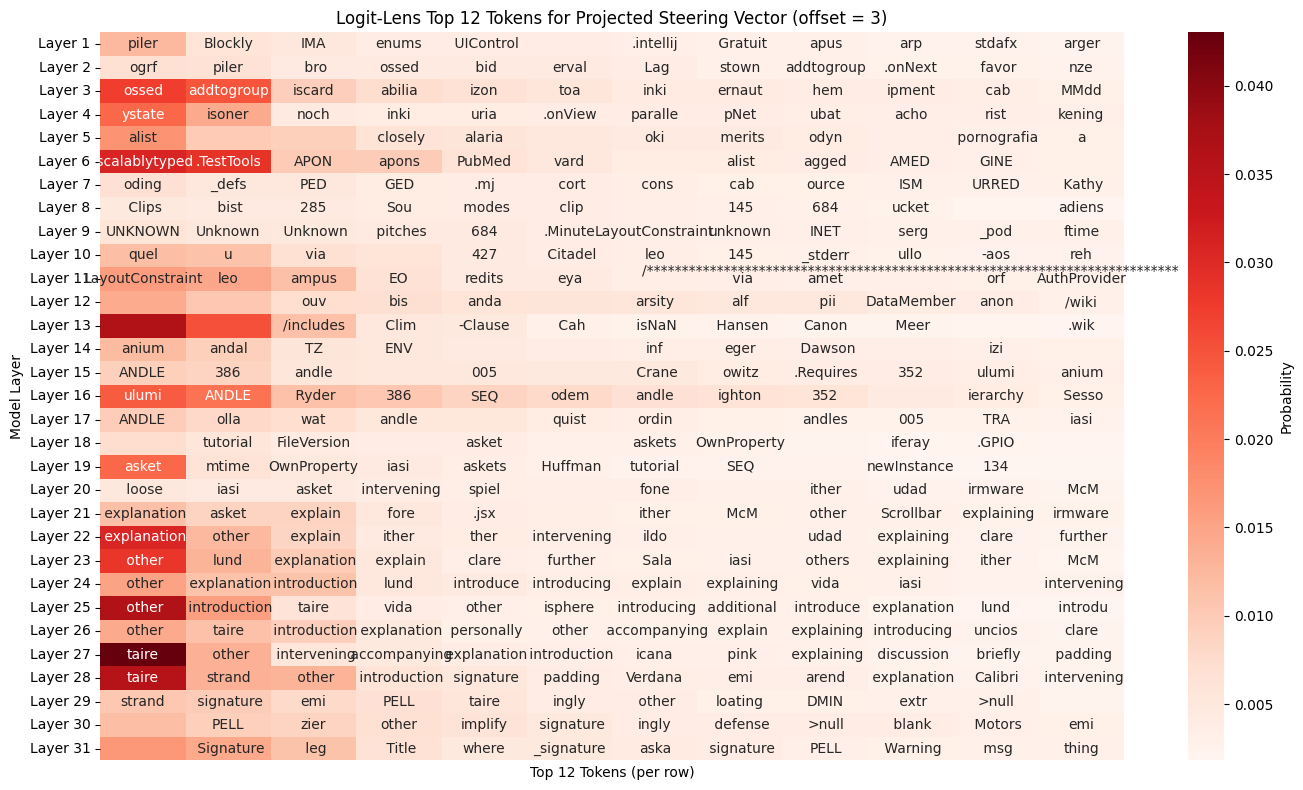

In [43]:
chosen_offset = 3  # e.g. 4th‐from‐last token
map_logit_lens_projected(
    layer_proj=projected_vectors_by_layer,
    model=model,
    tokenizer=tok,                   # pass your tokenizer here
    position=chosen_offset,
    top_k=12,
    suffix=f" (offset = {chosen_offset})"
)


Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10
Loaded-offsets-with-nuisance layers (0-based): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Offsets per layer example (layer 0): 10
Loaded-proj-offsets layers (0-based): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Offsets per layer example (layer 0): 10
Layers for average nuisance: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


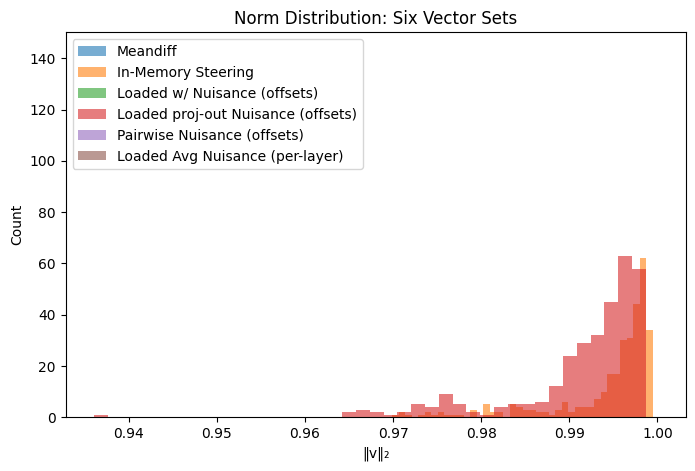

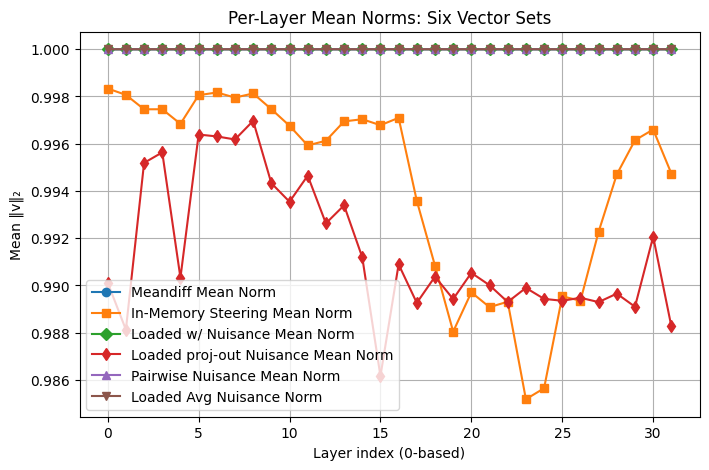

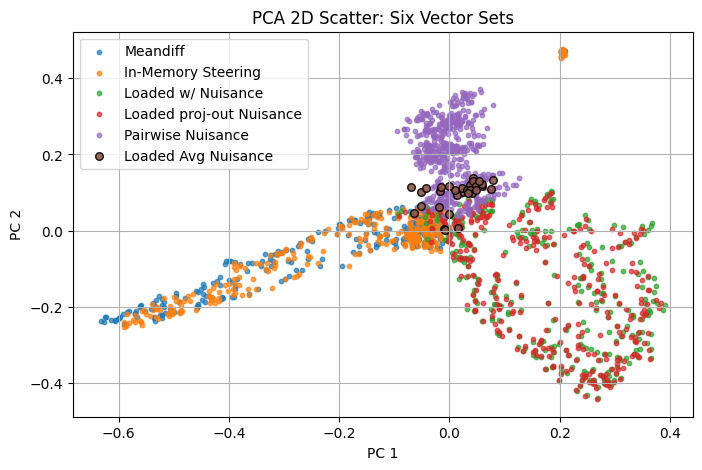

Average within-group cosines:
  Meandiff:                      0.093
  In-Memory Steering:            0.093
  Loaded w/ Nuisance (offsets):  0.115
  Loaded proj-out Nuisance:      0.113
  Pairwise Nuisance (offsets):   0.091
  Loaded Avg Nuisance (per-layer): 0.188

Average cross-group cosines:
  Meandiff vs In-Memory Steering: 0.095
  Meandiff vs Loaded w/ Nuisance: 0.013
  Meandiff vs Loaded proj-out Nuisance: 0.013
  Meandiff vs Pairwise Nuisance: 0.001
  Meandiff vs Loaded Avg Nuisance: 0.005
  In-Memory Steering vs Loaded w/ Nuisance: 0.013
  In-Memory Steering vs Loaded proj-out Nuisance: 0.013
  In-Memory Steering vs Pairwise Nuisance: -0.001
  In-Memory Steering vs Loaded Avg Nuisance: 0.006
  Loaded w/ Nuisance vs Loaded proj-out Nuisance: 0.116
  Loaded w/ Nuisance vs Pairwise Nuisance: 0.006
  Loaded w/ Nuisance vs Loaded Avg Nuisance: 0.027
  Loaded proj-out Nuisance vs Pairwise Nuisance: 0.004
  Loaded proj-out Nuisance vs Loaded Avg Nuisance: 0.008
  Pairwise Nuisance vs 

In [50]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# ─── 0. LOAD ALL STEERING-VECTOR SETS ─────────────────────────────────────────────

# (A) In-memory steering vectors (already computed elsewhere in your script)
#     We assume `projected_vectors_by_layer` is defined before this block.
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

# (B) Loaded steering vectors “with nuisance” (original pickle: per-offset)
with open('steering_vectors_newbalancedtask3_meandiff.pkl', 'rb') as f:
    loaded_offsets_with_nuisance = pickle.load(f)
print("Loaded-offsets-with-nuisance layers (0-based):", sorted(loaded_offsets_with_nuisance.keys()))
print("Offsets per layer example (layer 0):", len(loaded_offsets_with_nuisance[0]))

# (C) Loaded steering vectors “projected-out nuisance” (new pickle: per-offset)
with open('steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl', 'rb') as f:
    loaded_proj = pickle.load(f)
print("Loaded-proj-offsets layers (0-based):", sorted(loaded_proj.keys()))
print("Offsets per layer example (layer 0):", len(loaded_proj[0]))


# ─── 0.5 COMPUTE AVERAGE NUISANCE VECTOR PER LAYER (from loaded offsets) ───────────

loaded_avg_nuisance = {}
for layer in sorted(loaded_offsets_with_nuisance.keys()):
    diffs = []
    for i in range(len(loaded_offsets_with_nuisance[layer])):
        w = loaded_offsets_with_nuisance[layer][i].numpy()
        p = loaded_proj[layer][i].numpy()
        diffs.append(w - p)               # this is the nuisance component for offset i

    diffs = np.vstack(diffs)             # shape (K, hidden)
    avg_nuis = diffs.mean(axis=0)        # average difference across offsets
    avg_nuis = avg_nuis / np.linalg.norm(avg_nuis)
    loaded_avg_nuisance[layer] = avg_nuis  # unit‐norm nuisance for this layer

print("Layers for average nuisance:", sorted(loaded_avg_nuisance.keys()))


# ─── 1. CONVERT ALL VECTORS TO NUMPY ARRAYS ───────────────────────────────────────

# 1A. Mean-diff: layer_diffs[ℓ] → list of length K Tensors
meandiff_np_list = [v.numpy() for vs in layer_diffs.values() for v in vs]        # 320 × hidden

# 1B. In-memory steering (residual) from projected_vectors_by_layer
steering_np_list = [v.numpy() for vs in projected_vectors_by_layer.values() for v in vs]  # 320 × hidden

# 1C. Loaded-with-nuisance offsets (original pickle)
loaded_wn_np_list = [v.numpy() for vs in loaded_offsets_with_nuisance.values() for v in vs]  # 320 × hidden

# 1D. Loaded-proj offsets (project-out-nuisance pickle)
loaded_proj_np_list = [v.numpy() for vs in loaded_proj.values() for v in vs]                # 320 × hidden

# 1E. Pairwise nuisance offsets: pairwise_nuisance[ℓ] may have M vectors per layer
nuisance_np_list = [v.numpy() for vs in pairwise_nuisance.values() for v in vs]             # (~480) × hidden

# 1F. Loaded-average-nuisance: one vector per layer
loaded_avg_nuis_np_list = [vec for layer, vec in sorted(loaded_avg_nuisance.items())]       # 32 × hidden

# Stack into matrices
meandiff_mat         = np.vstack(meandiff_np_list)       # (320, hidden)
steering_mat         = np.vstack(steering_np_list)       # (320, hidden)
loaded_wn_mat        = np.vstack(loaded_wn_np_list)      # (320, hidden)
loaded_proj_mat      = np.vstack(loaded_proj_np_list)    # (320, hidden)
pairwise_nuis_mat    = np.vstack(nuisance_np_list)       # (~480, hidden)
loaded_avg_nuis_mat  = np.vstack(loaded_avg_nuis_np_list)  # (32, hidden)


# ─── 2. NORM HISTOGRAMS FOR EACH SET ─────────────────────────────────────────────

meandiff_norms     = np.linalg.norm(meandiff_mat, axis=1)
steering_norms     = np.linalg.norm(steering_mat, axis=1)
loaded_wn_norms    = np.linalg.norm(loaded_wn_mat, axis=1)
loaded_proj_norms  = np.linalg.norm(loaded_proj_mat, axis=1)
pairwise_nu_norms  = np.linalg.norm(pairwise_nuis_mat, axis=1)
loaded_avg_nu_norms = np.linalg.norm(loaded_avg_nuis_mat, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(meandiff_norms,      bins=40, alpha=0.6, label="Meandiff")
plt.hist(steering_norms,      bins=40, alpha=0.6, label="In-Memory Steering")
plt.hist(loaded_wn_norms,     bins=40, alpha=0.6, label="Loaded w/ Nuisance (offsets)")
plt.hist(loaded_proj_norms,   bins=40, alpha=0.6, label="Loaded proj-out Nuisance (offsets)")
plt.hist(pairwise_nu_norms,   bins=40, alpha=0.6, label="Pairwise Nuisance (offsets)")
plt.hist(loaded_avg_nu_norms, bins=40, alpha=0.6, label="Loaded Avg Nuisance (per-layer)")
plt.title("Norm Distribution: Six Vector Sets")
plt.xlabel("‖v‖₂")
plt.ylabel("Count")
plt.legend()
plt.show()


# ─── 3. PER-LAYER MEAN NORMS ─────────────────────────────────────────────────────

num_layers = len(layer_diffs)      # should be 32
K = len(next(iter(layer_diffs.values())))  # should be 10

# 3A. Meandiff norms per layer × offset
meandiff_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(layer_diffs.keys())):
    for j, v in enumerate(layer_diffs[ℓ]):
        meandiff_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3B. In-memory steering norms per layer × offset
steering_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(projected_vectors_by_layer.keys())):
    for j, v in enumerate(projected_vectors_by_layer[ℓ]):
        steering_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3C. Loaded-with-nuisance norms per layer × offset
loaded_wn_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(loaded_offsets_with_nuisance.keys())):
    for j, v in enumerate(loaded_offsets_with_nuisance[ℓ]):
        loaded_wn_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3D. Loaded-proj (project-out-nuisance) norms per layer × offset
loaded_proj_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(loaded_proj.keys())):
    for j, v in enumerate(loaded_proj[ℓ]):
        loaded_proj_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3E. Pairwise nuisance mean norm per layer (variable # per layer)
pairwise_nu_norms_per_layer = np.zeros(num_layers)
for i, ℓ in enumerate(sorted(pairwise_nuisance.keys())):
    nu_norms = [np.linalg.norm(v.numpy()) for v in pairwise_nuisance[ℓ]]
    pairwise_nu_norms_per_layer[i] = np.mean(nu_norms)

# 3F. Loaded-average-nuisance norm per layer (single value per layer)
loaded_avg_nu_norms_per_layer = np.zeros(num_layers)
for i, ℓ in enumerate(sorted(loaded_avg_nuisance.keys())):
    loaded_avg_nu_norms_per_layer[i] = np.linalg.norm(loaded_avg_nuisance[ℓ])

# Plot per-layer mean norms
layers = np.arange(num_layers)
plt.figure(figsize=(8, 5))
plt.plot(layers, meandiff_norms_per_layer.mean(axis=1),    marker='o', label='Meandiff Mean Norm')
plt.plot(layers, steering_norms_per_layer.mean(axis=1),    marker='s', label='In-Memory Steering Mean Norm')
plt.plot(layers, loaded_wn_norms_per_layer.mean(axis=1),   marker='D', label='Loaded w/ Nuisance Mean Norm')
plt.plot(layers, loaded_proj_norms_per_layer.mean(axis=1), marker='d', label='Loaded proj-out Nuisance Mean Norm')
plt.plot(layers, pairwise_nu_norms_per_layer,               marker='^', label='Pairwise Nuisance Mean Norm')
plt.plot(layers, loaded_avg_nu_norms_per_layer,             marker='v', label='Loaded Avg Nuisance Norm')
plt.title("Per-Layer Mean Norms: Six Vector Sets")
plt.xlabel("Layer index (0-based)")
plt.ylabel("Mean ‖v‖₂")
plt.legend()
plt.grid(True)
plt.show()


# ─── 4. PCA 2D SCATTER FOR ALL VECTORS ────────────────────────────────────────────

all_mat = np.vstack([
    meandiff_mat,
    steering_mat,
    loaded_wn_mat,
    loaded_proj_mat,
    pairwise_nuis_mat,
    loaded_avg_nuis_mat
])
pca = PCA(n_components=2)
coords = pca.fit_transform(all_mat)  # shape (N_total, 2)

# Split back into groups
n1 = meandiff_mat.shape[0]
n2 = steering_mat.shape[0]
n3 = loaded_wn_mat.shape[0]
n4 = loaded_proj_mat.shape[0]
n5 = pairwise_nuis_mat.shape[0]
n6 = loaded_avg_nuis_mat.shape[0]

coords_meandiff      = coords[:n1]
coords_steering      = coords[n1:n1+n2]
coords_loaded_wn     = coords[n1+n2:n1+n2+n3]
coords_loaded_pr     = coords[n1+n2+n3:n1+n2+n3+n4]
coords_pairwise_nu   = coords[n1+n2+n3+n4:n1+n2+n3+n4+n5]
coords_loaded_avg_nu = coords[-n6:]

plt.figure(figsize=(8, 5))
plt.scatter(coords_meandiff[:, 0],      coords_meandiff[:, 1],      s=10, label='Meandiff', alpha=0.7)
plt.scatter(coords_steering[:, 0],      coords_steering[:, 1],      s=10, label='In-Memory Steering', alpha=0.7)
plt.scatter(coords_loaded_wn[:, 0],     coords_loaded_wn[:, 1],     s=10, label='Loaded w/ Nuisance', alpha=0.7)
plt.scatter(coords_loaded_pr[:, 0],     coords_loaded_pr[:, 1],     s=10, label='Loaded proj-out Nuisance', alpha=0.7)
plt.scatter(coords_pairwise_nu[:, 0],   coords_pairwise_nu[:, 1],   s=10, label='Pairwise Nuisance', alpha=0.7)
plt.scatter(coords_loaded_avg_nu[:, 0], coords_loaded_avg_nu[:, 1], s=30, label='Loaded Avg Nuisance', alpha=0.9, edgecolors='k')
plt.title("PCA 2D Scatter: Six Vector Sets")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


# ─── 5. COSINE SIMILARITY ANALYSIS ───────────────────────────────────────────────

# 5A. Within-group average cosine for each of the six sets
cos_md    = cosine_similarity(meandiff_mat)
avg_cos_md = np.mean(cos_md[np.triu_indices_from(cos_md, k=1)])

cos_st    = cosine_similarity(steering_mat)
avg_cos_st = np.mean(cos_st[np.triu_indices_from(cos_st, k=1)])

cos_wn    = cosine_similarity(loaded_wn_mat)
avg_cos_wn = np.mean(cos_wn[np.triu_indices_from(cos_wn, k=1)])

cos_pr    = cosine_similarity(loaded_proj_mat)
avg_cos_pr = np.mean(cos_pr[np.triu_indices_from(cos_pr, k=1)])

cos_pn    = cosine_similarity(pairwise_nuis_mat)
avg_cos_pn = np.mean(cos_pn[np.triu_indices_from(cos_pn, k=1)])

cos_an    = cosine_similarity(loaded_avg_nuis_mat)
avg_cos_an = np.mean(cos_an[np.triu_indices_from(cos_an, k=1)])

print("Average within-group cosines:")
print(f"  Meandiff:                      {avg_cos_md:.3f}")
print(f"  In-Memory Steering:            {avg_cos_st:.3f}")
print(f"  Loaded w/ Nuisance (offsets):  {avg_cos_wn:.3f}")
print(f"  Loaded proj-out Nuisance:      {avg_cos_pr:.3f}")
print(f"  Pairwise Nuisance (offsets):   {avg_cos_pn:.3f}")
print(f"  Loaded Avg Nuisance (per-layer): {avg_cos_an:.3f}\n")

# 5B. Between-group average cosines
def avg_cross_cos(matA, matB):
    return float(np.mean(cosine_similarity(matA, matB)))

pairs = [
    ("Meandiff", meandiff_mat, "In-Memory Steering", steering_mat),
    ("Meandiff", meandiff_mat, "Loaded w/ Nuisance", loaded_wn_mat),
    ("Meandiff", meandiff_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("Meandiff", meandiff_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Meandiff", meandiff_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("In-Memory Steering", steering_mat, "Loaded w/ Nuisance", loaded_wn_mat),
    ("In-Memory Steering", steering_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("In-Memory Steering", steering_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("In-Memory Steering", steering_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Loaded proj-out Nuisance", loaded_proj_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Loaded proj-out Nuisance", loaded_proj_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Pairwise Nuisance", pairwise_nuis_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
]

print("Average cross-group cosines:")
for nameA, matA, nameB, matB in pairs:
    print(f"  {nameA} vs {nameB}: {avg_cross_cos(matA, matB):.3f}")
